# Data Extraction

## Parsing Y- axis Ticks and Y- vals 
This code parses the x and y axes (horizontal and vertical axes) detection for the y-ticks, calculates the ratio to normalize the figure contents, specifically the bar plots with respect to the y-ticks and finally connects the evaluated y-values with their correspinding legends using clustering algorithm. 
* Note that all the figures recorded have their respective dois as a unique key of identification.

In [1]:
import cv2, imutils, re, xlsxwriter, json
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
from pathlib import Path
from matplotlib import rcParams
from pytesseract import Output

In [2]:
# Directory of images to run the code on
img_dir = 'processed_images'
data_dir = 'data'

# Directory to save the output images
save_dir = 'out'

### Using json to parse the captions and dois for each image

In [3]:
with open('urldata.json') as handler:
    urldata = json.load(handler)


In [4]:
with open('doi_data.json') as doihandler:
    doidata = json.load(doihandler)


### Function to detect x-axis and y-axis for a plot

In [5]:
def findMaxConsecutiveOnes(nums) -> int:
    count = maxCount = 0
    
    for i in range(len(nums)):
        if nums[i] == 1:
            count += 1
        else:
            maxCount = max(count, maxCount)
            count = 0
                
    return max(count, maxCount)

In [6]:
def detectAxes(filepath, threshold=None, debug=False):
    if filepath is None:
        return None, None
    
    if threshold is None:
        threshold = 10
    
    image = cv2.imread(filepath)
    height, width, channels = image.shape
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    maxConsecutiveOnes = [findMaxConsecutiveOnes(gray[:, idx] < 200) for idx in range(width)]
    start_idx, maxindex, maxcount = 0, 0, max(maxConsecutiveOnes)
    while start_idx < width:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            maxindex = start_idx
            break
            
        start_idx += 1
           
    yaxis = (maxindex, 0, maxindex, height)
    
    if debug:
        fig, ax = plt.subplots(1, 2)

        ax[0].imshow(image)

        ax[1].plot(maxConsecutiveOnes, color = 'k')
        ax[1].axhline(y = max(maxConsecutiveOnes) - 10, color = 'r', linestyle = 'dashed')
        ax[1].axhline(y = max(maxConsecutiveOnes) + 10, color = 'r', linestyle = 'dashed')
        ax[1].vlines(x = maxindex, ymin = 0.0, ymax = maxConsecutiveOnes[maxindex], color = 'b', linewidth = 4)

        plt.show()

    maxConsecutiveOnes = [findMaxConsecutiveOnes(gray[idx, :] < 200) for idx in range(height)]
    start_idx, maxindex, maxcount = 0, 0, max(maxConsecutiveOnes)
    while start_idx < height:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            maxindex = start_idx
            
        start_idx += 1
            
    cv2.line(image, (0, maxindex), (width, maxindex),  (255, 0, 0), 2)
    xaxis = (0, maxindex, width, maxindex)
    
    if debug:
        rcParams['figure.figsize'] = 15, 8

        fig, ax = plt.subplots(1, 1)
        ax.imshow(image, aspect = 'auto')
        
    return xaxis, yaxis

### Here we try to get text from the image using pytesseract

In [7]:
def getTextFromImageArray(image, mode):
    image_text = []
    
    if mode == 'y-text':
        image = cv2.transpose(image)
        image = cv2.flip(image, flipCode = 1)
        config = "-l eng --oem 1 --psm 11"
    elif mode == 'y-labels':
        config = "-l eng --oem 1 --psm 6 -c tessedit_char_whitelist=.0123456789"
    
    d = pytesseract.image_to_data(image, config = config, output_type = Output.DICT)
    
    n_boxes = len(d['text'])

    # Pick only the positive confidence boxes
    for i in range(n_boxes):
            
        if int(d['conf'][i]) >= 0:
                
            text = d['text'][i].strip()
            
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image_text.append((d['text'][i], (x, y, w, h)))
            
    # Remove all the duplicates in (text, box) pairs
    return list(set(image_text))

In [8]:
def getTextFromImage(filepath, bw=False, debug=False):
    image_text = []
    
    image = cv2.imread(filepath)
    height, width, _ = image.shape
        
    if bw:
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # define range of black color in HSV
        lower_val = np.array([0, 0, 0])
        upper_val = np.array([179, 255, 179])

        # Threshold the HSV image to get only black colors
        mask = cv2.inRange(hsv, lower_val, upper_val)

        # Bitwise-AND mask and original image
        res = cv2.bitwise_and(image, image, mask = mask)

        # invert the mask to get black letters on white background
        image = cv2.bitwise_not(mask)
            
    d = pytesseract.image_to_data(image, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
    n_boxes = len(d['text'])

    # Pick only the positive confidence boxes
    for i in range(n_boxes):
            
        if int(d['conf'][i]) >= 0:
                
            text = d['text'][i].strip()
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image_text.append((d['text'][i], (x, y, w, h)))
     
    if bw:  
        image = cv2.imread(filepath)
        image_text = list(set(image_text))
        white_bg = 255 * np.ones_like(image)
        
        for text, (textx, texty, w, h) in image_text:
            roi = image[texty:texty + h, textx:textx + w]
            white_bg[texty:texty + h, textx:textx + w] = roi
            
        image_text = []
        d = pytesseract.image_to_data(white_bg, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
        n_boxes = len(d['text'])

        # Pick only the positive confidence boxes
        for i in range(n_boxes):

            if int(d['conf'][i]) >= 0:

                text = d['text'][i].strip()
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                image_text.append((d['text'][i], (x, y, w, h)))
        
    # Remove all the duplicates in (text, box) pairs
    return list(set(image_text))

In [9]:
def getProbableLabels(image, image_text, xaxis, yaxis):
    y_labels = []
    x_labels = []
    legends = []
    
    height, width, channels = image.shape
    
    for text, (textx, texty, w, h) in image_text:
        text = text.strip()
                    
        (x1, y1, x2, y2) = xaxis
        (x11, y11, x22, y22) = yaxis
            
        # To the left of y-axis and top of x-axis
        if (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == 1):
            y_labels.append((text, (textx, texty, w, h)))
            
        # To the right of y-axis and bottom of x-axis
        elif (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == 1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == -1):
            x_labels.append((text, (textx, texty, w, h)))
            
        # Top of x-axis and to the right of y-axis
        elif (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == -1):
            
            # Consider non-numeric only for legends
            if not bool(re.findall(r'\b[\d\.\d]+\b', text)):
                legends.append((text, (textx, texty, w, h)))
            
    # Get the y-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(x11):
        count = 0
        current = []
        for index, (text, rect) in enumerate(y_labels):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(y_labels[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
        
    y_labels = []
    for text, (textx, texty, w, h) in maxList:
        y_labels.append(text)
        #cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 0), 2)
        
    # Get the x-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(y1, height):
        count = 0
        current = []
        for index, (text, rect) in enumerate(x_labels):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(x_labels[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
    
    # Sort bounding rects by x coordinate
    def getYFromRect(item):
        return item[1]

    maxList.sort(key = getYFromRect)
    
    x_labels = []
    for text, (textx, texty, w, h) in maxList:
        x_labels.append(text)
        #cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 0), 2)
    
    # Get possible legend text
    # For this, we need to search both top to
    # bottom and also from left to right.
    maxIntersection = 0
    maxList = []
    for i in range(y1):
        count = 0
        current = []
        for index, (text, rect) in enumerate(legends):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(legends[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
            
    for i in range(x11, width):
        count = 0
        current = []
        for index, (text, rect) in enumerate(legends):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(legends[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
        
    legends = []
    #legendBoxes = []
    for text, (textx, texty, w, h) in maxList:
        legends.append(text)
    #    legendBoxes.append((textx, texty, w, h))
        #cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)
    
    #legendBoxes = mergeRects(legendBoxes)
    
    #for (textx, texty, w, h) in legendBoxes:
    #    cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)
    
    return image, x_labels, y_labels, legends

In [10]:
def lineIntersectsRectX(candx, rect):
    (x, y, w, h) = rect
    
    if x <= candx <= x + w:
        return True
    else:
        return False
    
def lineIntersectsRectY(candy, rect):
    (x, y, w, h) = rect
    
    if y <= candy <= y + h:
        return True
    else:
        return False

In [11]:
def maskImageForwardPass(filepath, start_idx):
    image = cv2.imread(filepath)
    height, width, channels = image.shape
        
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    start_idx = 1
    try:
        while start_idx <= width:
            if sum(gray[:, start_idx] < 200) != 0:
                break
            else:
                start_idx += 1

        end_idx = start_idx
        while end_idx <= width:
            if sum(gray[:, end_idx] < 200) == 0:
                break
            else:
                end_idx += 1
    except IndexError:
        pass

    gray[:, 1:start_idx] = 255
    gray[:, end_idx:width] = 255
        
    return gray, start_idx, end_idx

In [12]:
def maskImageBackwardPass(filepath, end_idx):
    image = cv2.imread(filepath)
    height, width, channels = image.shape

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    while end_idx > 0:
        if sum(gray[:, end_idx] < 200) == 0:
            break
        else:
            end_idx -= 1
        
    gray[:, end_idx:width] = 255
        
    return gray

## Getting the Ratio for y-value matching 

Similar to the label detection logic, y-ticks are detected: 

Y-ticks 

*  Check only the numerical boxes which are to the left of y-axis and to the top of x-axis.
*  Run a line sweep from left end of the image to the y-axis position, and check when the sweeping line intersects with the maximum number of numerical boxes.
* The numerical boxes are then used as bounding boxes for calculating the y-ticks.

Ratio:
* Difference between the y-ticks is then calculated.  
* Only consider the mean difference between the y-ticks, rejecting the outliers from the calculated values.
* The final ratio is: <br> ``normalize_ratio := ticks_diff.mean() / y-ticks.mean()``.

In [13]:
def getRatio(filepath, xaxis, yaxis):
    list_text = []
    list_ticks = []
    
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, channels = image.shape

    # Make a backward pass to skip the ticks
    gray = maskImageBackwardPass(filepath, yaxis[0])

    # Processing the image so that the contours are drawn to labels and text
    ret, thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
    thresh = cv2.dilate(thresh, rect_kernel, iterations = 1)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
    thresh = cv2.dilate(thresh, rect_kernel, iterations = 1)

    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    rects = [cv2.boundingRect(contour) for contour in contours]
    
    image_text = getTextFromImage(filepath, bw=True)
    image, y_labels = getProbableYLabels(image, rects, xaxis, yaxis)
    white_bg = 255 * np.ones_like(gray.copy())

    for (textx, texty, w, h) in y_labels:
        roi = gray[texty:texty + h, textx:textx + w]
        white_bg[texty:texty + h, textx:textx + w] = roi

    # Get y-labels
    y_labels_list = getTextFromImageArray(white_bg, 'y-labels')
    
    # Sort bounding rects by y coordinate
    def getYFromRect(item):
        return item[1][1]

    # Whiten y-labels and get y-text
    y_labels_list.sort(key = getYFromRect)
    
    # Get list of text and ticks
    list_text = []
    for text, (textx, texty, w, h) in y_labels_list:
        list_text.append(float(text))
        list_ticks.append(float(texty + h))
        
    text_sorted = (sorted(list_text))
    ticks_sorted  = (sorted(list_ticks))
    
    ticks_diff = ([ticks_sorted[i] - ticks_sorted[i-1] for i in range(1, len(ticks_sorted))])
    text_diff = ([text_sorted[i] - text_sorted[i-1] for i in range(1, len(text_sorted))])
    print("[get text-to-tick ratio] ticks_diff: {0}, text_diff: {1}".format(ticks_diff, text_diff))
    
    # Detected text may not be perfect! Remove the outliers.
    ticks_diff = reject_outliers(np.array(ticks_diff), m=1)
    text_diff = reject_outliers(np.array(text_diff), m=1)
    print("[reject_outliers] ticks_diff: {0}, text_diff: {1}".format(ticks_diff, text_diff))
    
    normalize_ratio = np.array(text_diff).mean() / np.array(ticks_diff).mean()

    return text_sorted, normalize_ratio

In [14]:
def lineIntersectsRectX(candx, rect):
    (x, y, w, h) = rect
    
    if x <= candx <= x + w:
        return True
    else:
        return False
    
def lineIntersectsRectY(candy, rect):
    (x, y, w, h) = rect
    
    if y <= candy <= y + h:
        return True
    else:
        return False

In [15]:
def reject_outliers(data, m=1):
    return data[abs(data - np.mean(data)) <= m * np.std(data)]

## Writing to Excel workbook

In [16]:
def addToExcel(dataname, data, row):
    col = 0

    worksheet.write(row, col, dataname)
    for content in data:
        col += 1
        worksheet.write(row, col, content)

## Matching the ratio for final data extraction 

Y-val data:
* The height of each bounding box is calculated by cluster count estimation method. 
* This ratio previously calculated is then used to calculate the <br> ``y_values :=  v_value = normalize_ratio x height of bounding box``.

In [17]:
def mergeRects(contours):
    rects = []
    rectsUsed = []

    # Just initialize bounding rects and set all bools to false
    for cnt in contours:
        rects.append(cv2.boundingRect(cnt))
        rectsUsed.append(False)

    # Sort bounding rects by x coordinate
    def getXFromRect(item):
        return item[0]

    rects.sort(key = getXFromRect)

    # Array of accepted rects
    acceptedRects = []

    # Merge threshold for x coordinate distance
    xThr = 5
    yThr = 5

    # Iterate all initial bounding rects
    for supIdx, supVal in enumerate(rects):
        if (rectsUsed[supIdx] == False):

            # Initialize current rect
            currxMin = supVal[0]
            currxMax = supVal[0] + supVal[2]
            curryMin = supVal[1]
            curryMax = supVal[1] + supVal[3]

            # This bounding rect is used
            rectsUsed[supIdx] = True

            # Iterate all initial bounding rects
            # starting from the next
            for subIdx, subVal in enumerate(rects[(supIdx+1):], start = (supIdx+1)):

                # Initialize merge candidate
                candxMin = subVal[0]
                candxMax = subVal[0] + subVal[2]
                candyMin = subVal[1]
                candyMax = subVal[1] + subVal[3]

                # Check if x distance between current rect
                # and merge candidate is small enough
                if (candxMin <= currxMax + xThr):

                    if not nearbyRectangle((candxMin, candyMin, candxMax - candxMin, candyMax - candyMin),
                                           (currxMin, curryMin, currxMax - currxMin, curryMax - curryMin), yThr):
                        break

                    # Reset coordinates of current rect
                    currxMax = candxMax
                    curryMin = min(curryMin, candyMin)
                    curryMax = max(curryMax, candyMax)

                    # Merge candidate (bounding rect) is used
                    rectsUsed[subIdx] = True
                else:
                    break

            # No more merge candidates possible, accept current rect
            acceptedRects.append([currxMin, curryMin, currxMax - currxMin, curryMax - curryMin])

    #for rect in acceptedRects:
    #    img = cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (121, 11, 189), 2)
    
    return acceptedRects

In [18]:
def nearbyRectangle(current, candidate, threshold):
    (currx, curry, currw, currh) = current
    (candx, candy, candw, candh) = candidate
    
    currxmin = currx
    currymin = curry
    currxmax = currx + currw
    currymax = curry + currh
    
    candxmin = candx
    candymin = candy
    candxmax = candx + candw
    candymax = candy + candh
    
    # If candidate is on top, and is close
    if candymax <= currymin and candymax + threshold >= currymin:
        return True
    
    # If candidate is on bottom and is close
    if candymin >= currymax and currymax + threshold >= candymin:
        return True
    
    # If intersecting at the top, merge it
    if candymax >= currymin and candymin <= currymin:
        return True
    
    # If intersecting at the bottom, merge it
    if currymax >= candymin and currymin <= candymin:
        return True
    
    # If intersecting on the sides or is inside, merge it
    if (candymin >= currymin and
        candymin <= currymax and
        candymax >= currymin and
        candymax <= currymax):
        return True
    
    return False

In [19]:
def euclidean(v1, v2):
    return sum((p - q) ** 2 for p, q in zip(v1, v2)) ** .5

def angle_between(p1, p2):
    
    deltaX = p1[0] - p2[0]
    deltaY = p1[1] - p2[1]

    #print(deltaX)
    #print(deltaY)
    return math.atan2(deltaY, deltaX) / math.pi * 180
    
def RectDist(rectA, rectB):
    (rectAx, rectAy, rectAw, rectAh) = rectA
    (rectBx, rectBy, rectBw, rectBh) = rectB
    
    angle = angle_between((rectAx + rectAw / 2, rectAy + rectAh / 2), (rectBx + rectBw / 2, rectBy + rectBh / 2))
    
    if (angle >= -5 and angle <= 5) or (angle <= -175 and angle >= -185) or (angle >= 175 and angle <= 185):
        if (rectBx > rectAx + rectAw):
            #print(rectA)
            #print(rectB)
            #print(angle)
            return euclidean([rectAx + rectAw / 2, rectAy + rectAh / 2], [rectBx + rectBw / 2, rectBy + rectBh / 2])
        else:
            return sys.maxsize
    else:
        return sys.maxsize

In [20]:
def getProbableYLabels(image, contours, xaxis, yaxis):
    y_labels = []
    
    height, width, channels = image.shape
    
    (x1, y1, x2, y2) = xaxis
    (x11, y11, x22, y22) = yaxis
    
    # Get the y-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(x11):
        count = 0
        current = []
        for index, rect in enumerate(contours):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(contours[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
                    
    return image, maxList

## Saving y-values in our data excel sheet 

In [21]:
import ast, cv2, re, sys
import math
import json


images = []
texts = []

def getYVal(img_dir):
    yValueDict = {}
    for index, path in enumerate(Path(img_dir).iterdir()):
        if path.name.endswith('.png') or path.name.endswith('.jpg'):
            filepath = img_dir + "/" + path.name
            img = cv2.imread(filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            xaxis, yaxis = detectAxes(filepath)
            
            for (x1, y1, x2, y2) in [xaxis]:
                xaxis = (x1, y1, x2, y2)

            for (x1, y1, x2, y2) in [yaxis]:
                yaxis = (x1, y1, x2, y2)

            image_text = getTextFromImage(filepath, bw=True)
            img, x_labels, _, legends = getProbableLabels(img, image_text, xaxis, yaxis)
            try:
                list_text, normalize_ratio = getRatio(filepath, xaxis, yaxis)
                print("[{0}] path: {1}, ratio: {2}".format(index, path.name, normalize_ratio), end='\n\n')

                #rcParams['figure.figsize'] = 15, 8
                #plt.imshow(img)

                d = pytesseract.image_to_data(img, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
                n_boxes = len(d['text'])

                # Color detection
                h, w, _ = np.shape(img)

                image = img.reshape((h * w, 3))

                # Remove white and near-by pixels
                threshold = 5
                for r in range(255 - threshold, 256):
                    for g in range(255 - threshold, 256):
                        for b in range(255 - threshold, 256):
                            image = image[np.where((image != [r, g, b]).any(axis = 1))]

                values, counts = np.unique(image, axis = 0, return_counts = True)

                greater_counts = np.where(counts >= 100)
                values, counts = values[greater_counts], counts[greater_counts]

                sort_indices = np.argsort(-counts)
                values, counts = values[sort_indices], counts[sort_indices]

                groups = []
                groupcounts = []

                for idx, value in enumerate(values):
                    grouped = False

                    for groupid, group in enumerate(groups):
                        for member in group:
                            r, g, b = member
                            vr, vg, vb = value

                            if (abs(vr.astype(np.int16) - r.astype(np.int16)) <= 5 and
                                abs(vg.astype(np.int16) - g.astype(np.int16)) <= 5 and
                                abs(vb.astype(np.int16) - b.astype(np.int16)) <= 5):
                                group.append(value)
                                groupcounts[groupid] += counts[idx]
                                grouped = True
                                break

                        if grouped:
                            break

                    if not grouped:
                        groups.append([value])
                        groupcounts.append(counts[idx])

                groupcounts = np.array(groupcounts)
                sort_indices = np.argsort(-groupcounts)
                new_groups = [groups[i] for i in sort_indices]
                groups = new_groups
                
                for i in range(len(groups[:4])):

                    img = cv2.imread(img_dir + "/" + path.name)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    mask = None
                    for value in groups[i]:
                        COLOR_MIN = np.array([value[0], value[1], value[2]], np.uint8)
                        COLOR_MAX = np.array([value[0], value[1], value[2]], np.uint8)

                        if mask is None:
                            mask = cv2.inRange(img, COLOR_MIN, COLOR_MAX)
                        else:
                            mask = mask | cv2.inRange(img, COLOR_MIN, COLOR_MAX)

                    image = cv2.bitwise_and(img, img, mask = mask)
                    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, (3, 3))

                    edged = cv2.Canny(image, 0, 250)
                    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    contours = [contour for contour in contours if cv2.contourArea(contour) > 0.]

                    # Remove noisy ones!
                    if len(contours) == 0 or len(contours) > 100:
                        continue

                    contours = [cv2.approxPolyDP(contour, 3, True) for contour in contours]

                    rects = mergeRects(contours)
                    textBoxes = []
                    legends = []
                    
                    for rectBox in rects:
                        min_distance = sys.maxsize
                        closestBox = None
                        legendtext = None

                        for text, textBox in image_text:    
                            if RectDist(rectBox, textBox) < min_distance:
                                closestBox = textBox
                                min_distance = RectDist(rectBox, textBox)
                                legendtext = text

                        if closestBox is not None:
                            textBoxes.append(closestBox)

                        if legendtext is not None:
                            legends.append(legendtext)

                    list_len = []
                    
                    for rect in rects:
                        img = cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (121, 11, 189), 2)
                        list_len.append(float(rect[3]))

                    # y-values will be a product of the normalize ratio and each length              
                    y_val = [round(l* normalize_ratio, 1) for l in list_len]

                    if path.name in yValueDict:
                        yValueDict[path.name].append([legends[-1]])
                        yValueDict[path.name].append(y_val)
                    else:
                        yValueDict[path.name] = [legends[-1]]
                        yValueDict[path.name].append(y_val)
                        
                    for box in textBoxes:
                        (x, y, w, h) = box
                        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

                    for (x1, y1, x2, y2) in [xaxis]:
                        cv2.line(img, (x1, y1), (x2, y2),  (0, 0, 255), 2)

                    for (x1, y1, x2, y2) in [yaxis]:
                        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        
            except Exception as e:
                print(e)
                continue
            
    return yValueDict

In [22]:
yValueDict = getYVal(img_dir)

[get text-to-tick ratio] ticks_diff: [25.0, 11.0, 17.0], text_diff: [1.0, 2.0, 825.0]
[reject_outliers] ticks_diff: [17.], text_diff: [1. 2.]
[0] path: 1-s2.0-S0165237018301529-main-Figure5-1-2.png, ratio: 0.08823529411764706

[get text-to-tick ratio] ticks_diff: [26.0, 25.0, 25.0, 26.0, 25.0, 25.0, 25.0, 26.0, 25.0], text_diff: [0.0, 10.0, 10.0, 0.0, 20.0, 10.0, 10.0, 10.0, 30.0]
[reject_outliers] ticks_diff: [25. 25. 25. 25. 25. 25.], text_diff: [10. 10. 10. 10. 10.]
[1] path: 1-s2.0-S0960852416306198-main-Figure2-1-2.png, ratio: 0.4

could not convert string to float: '.'
[get text-to-tick ratio] ticks_diff: [87.0, 53.0, 34.0, 87.0], text_diff: [0.0, 0.0, 2.0, 18.0]
[reject_outliers] ticks_diff: [87. 53. 87.], text_diff: [0. 0. 2.]
[3] path: 1-s2.0-S0960852414011213-main-Figure2-1-4.png, ratio: 0.008810572687224669

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[4] path: 1-s2.0-S0960852410010096-main-Figure1-1-3.png, ratio: na

/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [38.0, 38.0, 37.0, 38.0, 37.0, 38.0, 38.0, 37.0, 38.0, 37.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 310.0]
[reject_outliers] ticks_diff: [38. 38. 38. 38. 38. 38.], text_diff: [10. 10. 10. 10. 10. 10. 10. 10. 10.]
[5] path: ef201415s-Figure5-1-2.png, ratio: 0.2631578947368421

[get text-to-tick ratio] ticks_diff: [69.0, 68.0, 69.0, 69.0, 69.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [69. 69. 69. 69.], text_diff: [20. 20. 20. 20. 20.]
[6] path: 1-s2.0-S0896844617309117-main-Figure3-1-1.png, ratio: 0.2898550724637681

[get text-to-tick ratio] ticks_diff: [26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0], text_diff: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 4.0]
[reject_outliers] ticks_diff: [26. 26. 26. 26. 26. 26.], text_diff: [5. 5. 5. 5. 5. 5.]
[7] path: ef502773w-Figure2-1-1.png, ratio: 0.19230769230769232

list index out of range
[get text-to-tick ratio] ticks_diff: [33.0, 33.0, 32.0, 33.0, 33.

/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [30.0, 37.0, 27.0, 32.0, 29.0, 17.0, 10.0, 30.0, 31.0, 30.0], text_diff: [0.0, 1.0, 2.0, 1.0, 4.0, 23.0, 1.0, 6.0, 10.0, 182.0]
[reject_outliers] ticks_diff: [30. 27. 32. 29. 30. 31. 30.], text_diff: [ 0.  1.  2.  1.  4. 23.  1.  6. 10.]
[10] path: 1-s2.0-S0378382018307574-main-Figure1-1-1.png, ratio: 0.17862838915470494

[get text-to-tick ratio] ticks_diff: [39.0, 38.0, 39.0, 39.0, 39.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [39. 39. 39. 39.], text_diff: [20. 20. 20. 20. 20.]
[11] path: 1-s2.0-S0960852410010096-main-Figure1-1-2.png, ratio: 0.5128205128205128

[get text-to-tick ratio] ticks_diff: [77.0, 18.0, 59.0, 11.0, 13.0, 53.0], text_diff: [0.05, 0.04999999999999999, 1.85, 0.0, 0.0, 0.0]
[reject_outliers] ticks_diff: [18. 59. 13. 53.], text_diff: [0.05 0.05 0.   0.   0.  ]
[12] path: 1-s2.0-S0360544218308648-main-Figure5-1-2.png, ratio: 0.0005594405594405593

[get text-to-tick ratio] ticks_diff: [13.0, 17.0, 1

/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [51.0, 102.0, 51.0], text_diff: [40.0, 40.0, 20.0]
[reject_outliers] ticks_diff: [51. 51.], text_diff: [40. 40.]
[25] path: C4RA13359E-Figure12-1.png, ratio: 0.7843137254901961

[get text-to-tick ratio] ticks_diff: [30.0, 31.0, 63.0, 33.0, 28.0, 58.0, 30.0], text_diff: [5.0, 30.0, 5.0, 5.0, 170.0, 10.0, 95.0]
[reject_outliers] ticks_diff: [30. 31. 33. 28. 30.], text_diff: [ 5. 30.  5.  5. 10. 95.]
[26] path: 1-s2.0-S0378382018307574-main-Figure1-1-2.png, ratio: 0.8223684210526316

[get text-to-tick ratio] ticks_diff: [43.0, 43.0, 43.0, 43.0, 43.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [43. 43. 43. 43. 43.], text_diff: [20. 20. 20. 20. 20.]
[27] path: 1-s2.0-S0960852410010096-main-Figure1-1-1.png, ratio: 0.46511627906976744

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[28] path: acssuschemeng.7b01473-Figure1-1.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

list index out of range
could not convert string to float: '.'
[get text-to-tick ratio] ticks_diff: [94.0, 9.0, 24.0, 45.0, 87.0], text_diff: [1.0, 4.0, 0.0, 19.0, 12.0]
[reject_outliers] ticks_diff: [24. 45.], text_diff: [ 1.  4.  0. 12.]
[30] path: 1-s2.0-S0360544218308648-main-Figure5-1-1.png, ratio: 0.12318840579710146

[get text-to-tick ratio] ticks_diff: [24.0, 28.0, 24.0, 27.0, 17.0, 22.0, 20.0, 23.0, 23.0, 23.0], text_diff: [5.0, 5.0, 10.0, 10.0, 5.0, 10.0, 290.0, 5.0, 185.0, 5.0]
[reject_outliers] ticks_diff: [24. 24. 22. 23. 23. 23.], text_diff: [ 5.  5. 10. 10.  5. 10.  5.  5.]
[31] path: 1-s2.0-S0306261919313431-main-Figure8-1.png, ratio: 0.29676258992805754

list index out of range
[get text-to-tick ratio] ticks_diff: [39.0, 39.0, 39.0, 39.0, 39.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [39. 39. 39. 39. 39.], text_diff: [20. 20. 20. 20. 20.]
[32] path: Brilman2017_Article_HydrothermalCo-liquefactionOfM-Figure5-1.png, ratio: 0.5128205128205

/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

list index out of range
[get text-to-tick ratio] ticks_diff: [49.0, 47.0, 48.0, 48.0, 48.0], text_diff: [3.0, 7.0, 5.0, 5.0, 5.0]
[reject_outliers] ticks_diff: [48. 48. 48.], text_diff: [5. 5. 5.]
[38] path: acssuschemeng.7b01473-Figure5-1.png, ratio: 0.10416666666666667

[get text-to-tick ratio] ticks_diff: [82.0, 82.0, 82.0], text_diff: [20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [82. 82. 82.], text_diff: [20. 20. 20.]
[39] path: 1-s2.0-S0960852414011213-main-Figure2-1-3.png, ratio: 0.24390243902439024

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[40] path: C4RA13359E-Figure7-1.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

list index out of range
[get text-to-tick ratio] ticks_diff: [23.0, 24.0, 22.0, 23.0, 23.0, 22.0, 23.0, 23.0, 23.0], text_diff: [7.0, 3.0, 10.0, 10.0, 0.0, 10.0, 10.0, 10.0, 240.0]
[reject_outliers] ticks_diff: [23. 23. 23. 23. 23. 23.], text_diff: [ 7.  3. 10. 10.  0. 10. 10. 10.]
[41] path: 1-s2.0-S0960852414010724-main-Figure6-1-4.png, ratio: 0.32608695652173914

[get text-to-tick ratio] ticks_diff: [74.0], text_diff: [20.0]
[reject_outliers] ticks_diff: [74.], text_diff: [20.]
[42] path: 1-s2.0-S0960852414011213-main-Figure2-1-1.png, ratio: 0.2702702702702703

[get text-to-tick ratio] ticks_diff: [33.0, 34.0, 34.0, 33.0, 33.0, 34.0, 34.0, 33.0, 34.0, 33.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [33. 34. 34. 33. 33. 34. 34. 33. 34. 33.], text_diff: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
[43] path: ef201415s-Figure4-1-2.png, ratio: 0.29850746268656714

[get text-to-tick ratio] ticks_diff: [32.0, 31.0, 32.0, 31.0, 31.0

/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[49] path: acssuschemeng.7b00233-Figure3-1.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [49.0, 50.0, 49.0, 49.0, 50.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [49. 49. 49.], text_diff: [20. 20. 20. 20. 20.]
[50] path: 1-s2.0-S0960852410010096-main-Figure2-1-1.png, ratio: 0.40816326530612246

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[51] path: 1-s2.0-S2211926415300345-main-Figure6-1-1.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [39.0, 40.0, 40.0, 40.0, 40.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [40. 40. 40. 40.], text_diff: [20. 20. 20. 20. 20.]
[52] path: 1-s2.0-S0960852410010096-main-Figure2-1-3.png, ratio: 0.5

[get text-to-tick ratio] ticks_diff: [23.0, 9.0, 10.0, 34.0, 21.0, 33.0], text_diff: [3.0, 5.0, 1.0, 24.0, 5.0, 174.0]
[reject_outliers] ticks_diff: [23. 21.], text_diff: [ 3.  5.  1. 24.  5.]
[53] path: acs.est.8b04035-Figure2-1-4.png, ratio: 0.34545454545454546

[get text-to-tick ratio] ticks_diff: [35.0, 36.0, 35.0, 35.0, 36.0, 35.0, 36.0, 35.0, 35.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [35. 35. 35. 35. 35. 35.], text_diff: [10. 10. 10. 10. 10. 10. 10. 10. 10.]
[54] path: acssuschemeng.7b01473-Figure2-1.png, ratio: 0.2857142857142857

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[55] path: 1-s2.0-S2211926412

/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [39.0, 39.0, 38.0, 39.0, 39.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [39. 39. 39. 39.], text_diff: [10. 10. 10. 10. 10.]
[56] path: 1-s2.0-S096085241730038X-main-Figure3-1.png, ratio: 0.2564102564102564

[get text-to-tick ratio] ticks_diff: [47.0, 46.0, 47.0, 46.0, 47.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [47. 47. 47.], text_diff: [20. 20. 20. 20. 20.]
[57] path: 1-s2.0-S0960852410010096-main-Figure2-1-2.png, ratio: 0.425531914893617

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[58] path: 1-s2.0-S2211926415300345-main-Figure6-1-2.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [66.0, 65.0, 66.0, 65.0, 66.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [66. 66. 66.], text_diff: [20. 20. 20. 20. 20.]
[59] path: 1-s2.0-S0896844617309117-main-Figure1-1-1.png, ratio: 0.30303030303030304

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[60] path: 1-s2.0-S096085241100099X-main-Figure3-1-2.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [41.0, 41.0, 41.0, 41.0, 41.0, 41.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [41. 41. 41. 41. 41. 41.], text_diff: [10. 10. 10. 10. 10. 10.]
[61] path: Brilman2017_Article_HydrothermalCo-liquefactionOfM-Figure3-1-3.png, ratio: 0.24390243902439024

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[62] path: 1-s2.0-S2211926418307756-main-Figure4-1.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [37.0, 37.0, 36.0, 37.0, 37.0, 36.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [37. 37. 37. 37.], text_diff: [20. 20. 20. 20. 20. 20.]
[63] path: 1-s2.0-S0960852416314286-main-Figure1-1.png, ratio: 0.5405405405405406

[get text-to-tick ratio] ticks_diff: [23.0, 22.0, 23.0, 19.0, 25.0, 25.0, 24.0], text_diff: [5.0, 5.0, 30.0, 5.0, 15.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [23. 22. 23. 24.], text_diff: [15. 20. 20.]
[64] path: acs.est.8b04035-Figure2-1-1.png, ratio: 0.7971014492753623

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[65] path: 1-s2.0-S0960852416311816-main-Figure3-1-2.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [54.0, 54.0, 53.0, 54.0, 54.0, 53.0], text_diff: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[reject_outliers] ticks_diff: [54. 54. 54. 54.], text_diff: [5. 5. 5. 5. 5. 5.]
[66] path: 1-s2.0-S0960852417322113-main-Figure4-1-2.png, ratio: 0.09259259259259259

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[67] path: acs.energyfuels.5b00321-Figure1-1.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [58.0, 57.0, 58.0, 57.0, 58.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [58. 58. 58.], text_diff: [20. 20. 20. 20. 20.]
[68] path: 1-s2.0-S0960852418306631-main-Figure3-1.png, ratio: 0.3448275862068966

[get text-to-tick ratio] ticks_diff: [41.0, 41.0, 41.0, 41.0, 41.0, 41.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [41. 41. 41. 41. 41. 41.], text_diff: [10. 10. 10. 10. 10. 10.]
[69] path: Brilman2017_Article_HydrothermalCo-liquefactionOfM-Figure3-1-2.png, ratio: 0.24390243902439024

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[70] path: 1-s2.0-S2211926415300345-main-Figure7-1-2.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[71] path: 1-s2.0-S096085241100099X-main-Figure3-1-1.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [64.0, 63.0, 64.0, 64.0, 63.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [64. 64. 64.], text_diff: [20. 20. 20. 20. 20.]
[72] path: 1-s2.0-S0960852418306631-main-Figure1-1.png, ratio: 0.3125

list index out of range
[get text-to-tick ratio] ticks_diff: [65.0, 66.0, 65.0, 65.0, 66.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [65. 65. 65.], text_diff: [20. 20. 20. 20. 20.]
[73] path: 1-s2.0-S0896844617309117-main-Figure1-1-2.png, ratio: 0.3076923076923077

list index out of range
[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[74] path: 1-s2.0-S0960852412000144-main-Figure3-1.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [22.0, 22.0, 22.0, 36.0, 20.0, 19.0, 20.0], text_diff: [250.0, 250.0, 250.0, 19250.0, 10000.0, 10000.0, 0.0]
[reject_outliers] ticks_diff: [22. 22. 22. 20. 19. 20.], text_diff: [  250.   250.   250. 10000. 10000.     0.]
[75] path: acs.est.8b04035-Figure2-1-2.png, ratio: 166.00000000000003

[get text-to-tick ratio] ticks_diff: [31.0, 31.0, 32.0, 31.0, 31.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [31. 31. 31. 31.], text_diff: [20. 20. 20. 20. 20.]
[76] path: 1-s2.0-S2211926419300359-main-Figure8-1-8.png, ratio: 0.6451612903225806

[get text-to-tick ratio] ticks_diff: [37.0], text_diff: [0.0]
[reject_outliers] ticks_diff: [37.], text_diff: [0.]
[77] path: 1-s2.0-S0960852416311816-main-Figure3-1-1.png, ratio: 0.0

[get text-to-tick ratio] ticks_diff: [32.0, 32.0, 33.0, 32.0, 32.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [32. 32. 32. 32.], text_diff: [20. 20. 20. 20. 20.]
[78] path: acs.

/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [56.0, 56.0, 56.0, 56.0, 57.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [56. 56. 56. 56.], text_diff: [10. 10. 10. 10. 10.]
[82] path: acs.iecr.9b06655-Figure2-1-4.png, ratio: 0.17857142857142858

[get text-to-tick ratio] ticks_diff: [39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 40.0, 39.0, 39.0, 39.0, 39.0], text_diff: [10.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [39. 39. 39. 39. 39. 39. 39. 39. 39. 39.], text_diff: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
[83] path: 1-s2.0-S0016236118318489-main-Figure5-1.png, ratio: 0.2564102564102564

[get text-to-tick ratio] ticks_diff: [31.0, 32.0, 31.0, 31.0, 32.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [31. 31. 31.], text_diff: [20. 20. 20. 20. 20.]
[84] path: 1-s2.0-S2211926419300359-main-Figure8-1-4.png, ratio: 0.6451612903225806

[get text-to-tick ratio] ticks_diff: [32.0, 31.0, 31.0, 31.0], text_d

/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [41.0, 41.0, 40.0, 81.0, 40.0, 41.0, 40.0, 41.0], text_diff: [0.0, 10.0, 10.0, 10.0, 10.0, 30.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [41. 41. 40. 40. 41. 40. 41.], text_diff: [10. 10. 10. 10. 10. 10.]
[92] path: ep.12172-Figure4-1.png, ratio: 0.24647887323943662

[get text-to-tick ratio] ticks_diff: [66.0, 63.0, 16.0, 55.0, 66.0], text_diff: [10.0, 20.0, 10.0, 280.0, 5189.0]
[reject_outliers] ticks_diff: [66. 63. 55. 66.], text_diff: [ 10.  20.  10. 280.]
[93] path: 1-s2.0-S0165237018301529-main-Figure2-1-3.png, ratio: 1.28

[get text-to-tick ratio] ticks_diff: [29.0, 29.0, 29.0, 18.0, 13.0, 31.0, 34.0, 19.0], text_diff: [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[reject_outliers] ticks_diff: [29. 29. 29. 31. 19.], text_diff: [1. 1. 1. 1. 1. 1. 1.]
[94] path: 1-s2.0-S0306261919313431-main-Figure7-1.png, ratio: 0.03649635036496351

list index out of range
[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], tex

/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [31.0, 31.0, 31.0, 32.0, 31.0, 31.0], text_diff: [9.0, 11.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [31. 31. 31. 31. 31.], text_diff: [20. 20. 20. 20.]
[96] path: 1-s2.0-S2211926419300359-main-Figure8-1-7.png, ratio: 0.6451612903225806

list index out of range
[get text-to-tick ratio] ticks_diff: [35.0, 34.0, 35.0, 34.0, 35.0, 34.0, 35.0, 34.0, 35.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [35. 35. 35. 35. 35.], text_diff: [10. 10. 10. 10. 10. 10. 10. 10. 10.]
[97] path: acs.iecr.9b02442-Figure3-1.png, ratio: 0.2857142857142857

[get text-to-tick ratio] ticks_diff: [32.0, 31.0, 31.0, 32.0, 31.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [31. 31. 31.], text_diff: [20. 20. 20. 20. 20.]
[98] path: 1-s2.0-S2211926419300359-main-Figure8-1-6.png, ratio: 0.6451612903225806

[get text-to-tick ratio] ticks_diff: [24.0, 24.0, 24.0, 25.0, 24.0, 25.0, 24.0, 24

/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [64.0, 58.0, 15.0, 41.0, 59.0], text_diff: [3.0, 7.09, 19.95, 9.96, 3160.0]
[reject_outliers] ticks_diff: [64. 58. 41. 59.], text_diff: [ 3.    7.09 19.95  9.96]
[101] path: 1-s2.0-S0165237018301529-main-Figure2-1-2.png, ratio: 0.18018018018018017

[get text-to-tick ratio] ticks_diff: [51.0, 51.0, 51.0, 51.0, 51.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [51. 51. 51. 51. 51.], text_diff: [20. 20. 20. 20. 20.]
[102] path: C5GC02953H-Figure6-1-2.png, ratio: 0.39215686274509803

[get text-to-tick ratio] ticks_diff: [25.0, 25.0, 24.0, 25.0, 25.0, 25.0], text_diff: [4.0, 5.0, 10.0, 5.0, 5.0, 5.0]
[reject_outliers] ticks_diff: [25. 25. 25. 25. 25.], text_diff: [4. 5. 5. 5. 5.]
[103] path: 1-s2.0-S0960852412015222-main-Figure3-1-1.png, ratio: 0.192

[get text-to-tick ratio] ticks_diff: [30.0, 31.0, 31.0, 30.0, 31.0, 31.0, 30.0, 31.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: 

/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

could not convert string to float: '.'
[get text-to-tick ratio] ticks_diff: [31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0], text_diff: [5.0, 5.0, 8.0, 2.0, 5.0, 5.0, 5.0, 5.0]
[reject_outliers] ticks_diff: [31. 31. 31. 31. 31. 31. 31. 31.], text_diff: [5. 5. 5. 5. 5. 5.]
[125] path: 1-s2.0-S2211926418307756-main-Figure3-1-1.png, ratio: 0.16129032258064516

list index out of range
[get text-to-tick ratio] ticks_diff: [41.0, 41.0, 42.0, 41.0, 41.0, 41.0, 41.0], text_diff: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[reject_outliers] ticks_diff: [41. 41. 41. 41. 41. 41.], text_diff: [5. 5. 5. 5. 5. 5. 5.]
[126] path: acs.iecr.9b02442-Figure2-1.png, ratio: 0.12195121951219512

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[127] path: 1-s2.0-S2211926418307756-main-Figure10-1-1.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

list index out of range
[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[128] path: acssuschemeng.6b00226-Figure2-1.png, ratio: nan



/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [82.0, 82.0, 82.0, 82.0, 82.0], text_diff: [1.0, 0.0, 0.0, 1.0, 1.0]
[reject_outliers] ticks_diff: [82. 82. 82. 82. 82.], text_diff: [1. 1. 1.]
[129] path: 1-s2.0-S0960852419304353-main-Figure3-1.png, ratio: 0.012195121951219513

[get text-to-tick ratio] ticks_diff: [47.0, 94.0, 47.0], text_diff: [40.0, 40.0, 20.0]
[reject_outliers] ticks_diff: [47. 47.], text_diff: [40. 40.]
[130] path: c9ra07150d-Figure2-1-2.png, ratio: 0.851063829787234

[get text-to-tick ratio] ticks_diff: [53.0, 53.0, 54.0], text_diff: [20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [53. 53.], text_diff: [20. 20. 20.]
[131] path: 1-s2.0-S0960852417311409-main-Figure2-1-1.png, ratio: 0.37735849056603776

[get text-to-tick ratio] ticks_diff: [47.0, 22.0, 9.0, 14.0, 33.0, 9.0, 14.0, 9.0, 17.0, 9.0, 12.0, 12.0, 5.0, 36.0], text_diff: [2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 3.0, 17.0, 5.0, 190.0, 290.0, 305.0]
[reject_outliers] ticks_diff: [22.  9. 14.  9. 14.  9. 17.  9. 12. 12.]

/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [38.0, 38.0, 39.0, 38.0, 39.0, 38.0, 39.0, 38.0, 39.0, 38.0, 39.0], text_diff: [10.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [38. 38. 38. 38. 38. 38.], text_diff: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
[134] path: 1-s2.0-S0016236118318489-main-Figure4-1.png, ratio: 0.2631578947368421

[get text-to-tick ratio] ticks_diff: [53.0, 53.0, 53.0, 52.0, 53.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [53. 53. 53. 53.], text_diff: [20. 20. 20. 20. 20.]
[135] path: 1-s2.0-S004896971831547X-main-Figure2-1.png, ratio: 0.37735849056603776

[get text-to-tick ratio] ticks_diff: [57.0, 56.0, 56.0, 56.0, 56.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [56. 56. 56. 56.], text_diff: [10. 10. 10. 10. 10.]
[136] path: acs.iecr.9b06655-Figure1-1-4.png, ratio: 0.17857142857142858

[get text-to-tick ratio] ticks_diff: [51.0, 51.0, 51.0, 50.0, 51.0], text_diff:

/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chinmayeerane/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of 

[get text-to-tick ratio] ticks_diff: [37.0, 37.0, 36.0, 36.0, 37.0, 36.0, 37.0, 37.0, 37.0], text_diff: [10.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 120.0]
[reject_outliers] ticks_diff: [37. 37. 37. 37. 37. 37.], text_diff: [10.  0. 10. 10. 10. 10. 10. 10.]
[143] path: ep.12172-Figure3-1.png, ratio: 0.23648648648648649

[get text-to-tick ratio] ticks_diff: [52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0], text_diff: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[reject_outliers] ticks_diff: [52. 52. 52. 52. 52. 52. 52.], text_diff: [5. 5. 5. 5. 5. 5. 5.]
[144] path: 1-s2.0-S0896844617309117-main-Figure6-1-3.png, ratio: 0.09615384615384616

[get text-to-tick ratio] ticks_diff: [47.0, 46.0, 46.0, 46.0, 46.0, 47.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [46. 46. 46. 46.], text_diff: [10. 10. 10. 10. 10. 10.]
[145] path: Brilman2017_Article_HydrothermalCo-liquefactionOfM-Figure4-1-1.png, ratio: 0.21739130434782608

[get text-to-tick ratio] ticks_diff: [56.0, 56.0

number of contours:  4
0 Aliphatic
1 [0.1, 0.1, 7.3, 7.3, 1.4, 1.1, 0.3, 0.2]
2 ['Heterocyclic']
3 [7.3, 7.2, 1.1]
4 ['BE%']
5 [1.1, 7.3, 7.3]
6 ['Amides']
7 [7.3, 7.3, 1.1]
file name    :   1-s2.0-S0165237018301529-main-Figure5-1-2.png
doi          :   ['doi:10.1016/j.jaap.2018.07.008']
x-labels     :   ['20', '40', '60', '80', '100']
y-text       :   ['R', 'nie', 'time', '[min]', 'a']
y-labels     :   ['2', '5', '3', '830']
legends      :   ['hydrocarbons', 'Nitrles', 'iB', 'compounds', '‘Aromatic', 'Amides', '[JJ', 'Amines', 'iB', '[MJ', 'Aliphatic', 'MJ', 'compounds', 'Heterocyclic']
Y- Values    :   Aliphatic [0.1, 0.1, 7.3, 7.3, 1.4, 1.1, 0.3, 0.2] ['Heterocyclic'] [7.3, 7.2, 1.1] ['BE%'] [1.1, 7.3, 7.3] ['Amides'] [7.3, 7.3, 1.1]

number of contours:  13
0 gap
1 [0.8, 1.6, 5.2, 3.2, 1.6, 0.4, 0.4, 2.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 1.2, 0.8, 0.8, 0.8, 0.4, 0.8, 0.8, 0.8, 0.8, 0.4, 3.2, 0.4, 0.8, 0.8, 0.8, 0.8, 2.0, 0.4, 4.0, 0.8, 0.8, 0.8, 1.6, 0.4, 2.0, 0.4, 0.4,

number of contours:  6
0 XS
1 [103.6, 5.1, 7.2, 11.8, 5.6, 4.6, 4.6, 3.1, 6.2, 0.5, 8.2, 6.2, 2.6, 2.6, 6.7, 2.6, 8.7, 4.1, 4.1, 4.1, 3.1, 0.5, 2.1, 6.7, 3.6, 5.6, 17.4, 3.1, 6.2, 3.1, 3.1, 12.8, 11.3, 2.1, 8.2, 4.6, 8.7, 2.1, 1.0, 2.1, 0.5, 71.3]
file name    :   1-s2.0-S0960852410010096-main-Figure1-1-2.png
doi          :   ['doi:10.1016/j.biortech.2010.06.028']
x-labels     :   []
y-text       :   []
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['ee', '“wy', 'os', 'a', 'we', 'wy']
Y- Values    :   XS [103.6, 5.1, 7.2, 11.8, 5.6, 4.6, 4.6, 3.1, 6.2, 0.5, 8.2, 6.2, 2.6, 2.6, 6.7, 2.6, 8.7, 4.1, 4.1, 4.1, 3.1, 0.5, 2.1, 6.7, 3.6, 5.6, 17.4, 3.1, 6.2, 3.1, 3.1, 12.8, 11.3, 2.1, 8.2, 4.6, 8.7, 2.1, 1.0, 2.1, 0.5, 71.3]

number of contours:  6
0 GHe
1 [0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0]
2 ['0']
3 [0.2, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.1]
file name    :   1-s2.0-S0360544218308648-main-Figure5-1-2.png
doi          :   ['d

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  2
0 |
1 [nan, nan, nan, nan, nan]
2 ['|']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
4 ['350']
5 [nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S2211926415300345-main-Figure5-1-1.png
doi          :   []
x-labels     :   ['(a)']
y-text       :   []
y-labels     :   []
legends      :   ['Ph', 'OC', 'OA', 'Ph', 'Ph', 'OA', 'OC', 'NC', 'NC', 'OC', 'HC', 'HC', 'NC', 'OA', 'HC']
Y- Values    :   | [nan, nan, nan, nan, nan] ['|'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['350'] [nan, nan, nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 BMD)
1 [3.1, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 15.7, 158.4, 0.8, 0.8, 0.8]
file name    :   C4RA13359E-Figure12-1.png
doi          :   
x-labels     :   ['20', '40', 'oo', '80', '100']
y-text       :   ['Yield', '(%)', 's']
y-labels     :   ['100', '80', '40', '0']
legends      :   ['RS', 'WN', '.', 'SS', '—', 'i', 'x', 'ass', 'Or)']
Y- Values    :   BMD) [3.1, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 15.7, 158.4, 0.8, 0.8, 0.8]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  11
0 Microwave
1 [100.3, 181.7, 166.9, 186.7, 6.6]
2 ['Soxhlet']
3 [114.3, 149.7, 183.4, 195.7, 5.8]
4 ['Filtration']
5 [75.7, 160.4, 162.8, 190.0, 5.8]
6 ['SCG']
7 [0.8, 0.8, 0.8, 0.8, 1.6, 0.8, 0.8, 0.8, 1.6, 1.6, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 4.1, 0.8, 0.8, 0.8, 251.6, 7.4, 2.5, 0.8, 0.8, 0.8, 7.4, 0.8, 4.1, 0.8, 0.8, 6.6, 0.8, 0.8, 0.8, 9.9, 0.8, 4.1, 1.6, 9.0, 6.6, 7.4, 6.6, 0.8, 0.8, 4.9, 0.8, 0.8, 4.9, 1.6]
file name    :   1-s2.0-S0378382018307574-main-Figure1-1-2.png
doi          :   ['doi:10.1016/j.fuproc.2018.07.006']
x-labels     :   ['Hexane', 'Acetone', 'DCM']
y-text       :   ['Bioc', 'e', 'di', 'a']
y-labels     :   ['50', '45', '40', '230', '325', '220', '10', '5']
legends      :   ['Hil', 'Microwave', '=']
Y- Values    :   Microwave [100.3, 181.7, 166.9, 186.7, 6.6] ['Soxhlet'] [114.3, 149.7, 183.4, 195.7, 5.8] ['Filtration'] [75.7, 160.4, 162.8, 190.0, 5.8] ['SCG'] [0.8, 0.8, 0.8, 0.8, 1.6, 0.8, 0.8, 0.8, 1.6, 1.6, 0.8, 0.8, 0.8, 0.8, 0

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 “wy
1 [103.3, 100.9, 7.4, 1.4, 43.7, 2.3, 3.3, 3.3, 16.7, 100.9, 7.4, 8.8, 20.5, 5.1, 5.1, 5.1, 4.7, 9.8, 1.4, 2.8, 5.6, 0.5, 101.4, 7.0, 2.3, 41.4, 3.3, 1.9, 7.0, 8.8, 36.7, 3.7, 2.3, 4.2, 2.8, 60.0, 37.2, 100.9]
file name    :   1-s2.0-S0960852410010096-main-Figure1-1-1.png
doi          :   ['doi:10.1016/j.biortech.2010.06.028']
x-labels     :   []
y-text       :   []
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['RB', 'RA', 'RB', 'Rh', 'we,', 'ww', 'RB', 'Za', 'RS', 'MA', 'we', 'A', 'RY', 'ww', 'w']
Y- Values    :   “wy [103.3, 100.9, 7.4, 1.4, 43.7, 2.3, 3.3, 3.3, 16.7, 100.9, 7.4, 8.8, 20.5, 5.1, 5.1, 5.1, 4.7, 9.8, 1.4, 2.8, 5.6, 0.5, 101.4, 7.0, 2.3, 41.4, 3.3, 1.9, 7.0, 8.8, 36.7, 3.7, 2.3, 4.2, 2.8, 60.0, 37.2, 100.9]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  0
0 Asphaltene
1 [nan, nan, nan, nan, nan, nan, nan, nan]
2 ['300']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   acssuschemeng.7b01473-Figure1-1.png
doi          :   
x-labels     :   ['150', '160', '170', '180', '190', '200', '225', '250', '275', '300']
y-text       :   []
y-labels     :   []
legends      :   []
Y- Values    :   Asphaltene [nan, nan, nan, nan, nan, nan, nan, nan] ['300'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  6
0 2
1 [24.4, 26.5, 1.1, 24.5, 30.3, 24.8, 27.6, 29.7, 18.5]
2 ['2']
3 [13.3, 23.3, 29.8, 14.5, 1.1, 24.9, 22.8, 29.8, 33.8]
file name    :   1-s2.0-S0360544218308648-main-Figure5-1-1.png
doi          :   ['doi:10.1016/j.energy.2018.05.044']
x-labels     :   ['AuP', 'ArP', 'SL', 'UP', 'SJ', 'ZM', 'GEH']
y-text       :   ['re', 'ige']
y-labels     :   ['36', '24', '5', '5', '1', '0']
legends      :   ['co', 'He', 'CO', '=GHs', 'C:He', 'mCHe']
Y- Values    :   2 [24.4, 26.5, 1.1, 24.5, 30.3, 24.8, 27.6, 29.7, 18.5] ['2'] [13.3, 23.3, 29.8, 14.5, 1.1, 24.9, 22.8, 29.8, 33.8]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  1
0 £0
1 [1.8, 0.6, 51.3, 32.3, 19.9, 1.8, 3.0]
2 ['50']
3 [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 68.0, 0.3, 0.6, 1.2, 0.3, 0.6, 0.3, 1.8, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.6, 1.5, 0.3, 0.6, 0.9, 0.3, 0.3, 0.3, 0.6, 0.3, 0.3, 0.6, 0.3]
file name    :   1-s2.0-S0306261919313431-main-Figure8-1.png
doi          :   
x-labels     :   ['1t05', '6', 'tol0', '11', 'to', '15', '16', '25', '31', '41', 'to', '50']
y-text       :   ['F', '1']
y-labels     :   ['30', '45', '340', '335', '530', '525', '20', '35', '10', '5', '0']
legends      :   ['t0', 'to', 'to']
Y- Values    :   £0 [1.8, 0.6, 51.3, 32.3, 19.9, 1.8, 3.0] ['50'] [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 68.0, 0.3, 0.6, 1.2, 0.3, 0.6, 0.3, 1.8, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.6, 1.5, 0.3, 0.6, 0.9, 0.3, 0.3, 0.3, 0.6, 0.3, 0.3, 0.6, 0.3]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 fell
1 [32.8, 6.2, 46.2, 25.1, 44.1, 33.3, 51.8, 25.6, 35.4, 22.1, 33.3]
file name    :   Brilman2017_Article_HydrothermalCo-liquefactionOfM-Figure5-1.png
doi          :   
x-labels     :   ['Algae', 'Algae', 'Wood', 'Wood', 'Sugar', 'Sugar', 'Algae', '+', 'Algae', '+', 'Sugar', '+', 'Sugar', '+', 'Wood', 'Wood', 'Algae', '-', 'Algae', '-']
y-text       :   ['Energy', 'Recovery', '(%)']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['Recovery', 'incl.', 'by', 'Energy', 'MB', 'est.', 'averaging', 'correction', '(%),']
Y- Values    :   fell [32.8, 6.2, 46.2, 25.1, 44.1, 33.3, 51.8, 25.6, 35.4, 22.1, 33.3]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  4
0 se
1 [50.2, 51.5, 52.1, 2.4, 52.9, 54.8, 54.0, 53.2, 53.2, 51.8]
2 ['se']
3 [51.3, 54.0, 54.0, 0.5, 51.8, 51.8]
4 ['se']
5 [50.2, 0.5, 52.9, 53.2, 53.4]
6 ['se']
7 [50.2, 53.2, 52.9, 0.5]
file name    :   1-s2.0-S0960852414011213-main-Figure2-1-2.png
doi          :   ['doi:10.1016/j.biortech.2014.08.014']
x-labels     :   ['0', '5', '10', '2', '30', '40', '50', '0', '240']
y-text       :   ['Vie']
y-labels     :   ['60', '20']
legends      :   ['SiS', 'smo', 'SRDS', 'sas', 'son', 'S86', 'se']
Y- Values    :   se [50.2, 51.5, 52.1, 2.4, 52.9, 54.8, 54.0, 53.2, 53.2, 51.8] ['se'] [51.3, 54.0, 54.0, 0.5, 51.8, 51.8] ['se'] [50.2, 0.5, 52.9, 53.2, 53.4] ['se'] [50.2, 53.2, 52.9, 0.5]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  12
0 organics
1 [0.9, 0.3, 0.3, 21.8, 32.6, 0.9, 1.2, 0.3, 69.1, 1.5, 2.1, 27.6, 41.2, 0.3, 0.6, 0.9, 0.9, 37.9, 1.5, 69.1, 2.9, 2.1, 71.8, 1.8, 2.6, 0.9, 2.1, 0.3, 22.1, 0.9, 0.9, 14.4, 0.9, 0.9, 0.3, 48.2, 14.4, 14.1, 0.9, 1.5, 6.5, 10.0, 0.3, 0.3, 2.1]
file name    :   ef201415s-Figure4-1-1.png
doi          :   []
x-labels     :   ['175', '200', '225', '250', '275', '300', '325', '350', '375', '400', '425', '450']
y-text       :   ['Yield', '(wt.%)']
y-labels     :   ['400', '90', '80', '70', '60', '50', '40', '30', '20', '10']
legends      :   ['[J', 'organics', 'MM', 'Oil', 'soluble', 'residue', 'Gas', '(]', 'WSolid', 'Wate']
Y- Values    :   organics [0.9, 0.3, 0.3, 21.8, 32.6, 0.9, 1.2, 0.3, 69.1, 1.5, 2.1, 27.6, 41.2, 0.3, 0.6, 0.9, 0.9, 37.9, 1.5, 69.1, 2.9, 2.1, 71.8, 1.8, 2.6, 0.9, 2.1, 0.3, 22.1, 0.9, 0.9, 14.4, 0.9, 0.9, 0.3, 48.2, 14.4, 14.1, 0.9, 1.5, 6.5, 10.0, 0.3, 0.3, 2.1]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 360
1 [0.3, 0.3, 0.3, 1.5, 0.3, 0.3, 0.3, 0.3, 0.3, 1.5, 0.3, 0.3, 0.3, 0.3, 1.8, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.6, 0.9, 2.5, 0.3, 0.6, 0.3, 0.3, 0.6, 0.3, 4.9, 0.3, 0.3, 0.3, 0.3, 0.3, 1.5, 0.3, 2.2, 0.3, 0.3, 1.5]
file name    :   1-s2.0-S0896844617309117-main-Figure2-1-2.png
doi          :   ['doi:10.1016/j.supflu.2018.04.011']
x-labels     :   ['300', '320', '340', '360']
y-text       :   ['Vield@wt%:']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['(b)']
Y- Values    :   360 [0.3, 0.3, 0.3, 1.5, 0.3, 0.3, 0.3, 0.3, 0.3, 1.5, 0.3, 0.3, 0.3, 0.3, 1.8, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.6, 0.9, 2.5, 0.3, 0.6, 0.3, 0.3, 0.6, 0.3, 4.9, 0.3, 0.3, 0.3, 0.3, 0.3, 1.5, 0.3, 2.2, 0.3, 0.3, 1.5]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  5
0 samo
1 [50.2, 2.4, 52.0, 0.7, 52.9, 2.0, 54.6, 0.7, 53.2, 52.4, 52.2]
2 ['loading(wt.%)']
3 [0.5, 61.0, 2.9, 1.0, 2.9, 2.0, 2.9, 1.2, 1.0, 2.9, 2.9, 0.5, 0.5, 2.9]
4 ['samo']
5 [50.2, 53.2, 52.4]
6 ['tsa']
7 [52.0, 54.4, 0.5]
file name    :   1-s2.0-S0960852414011213-main-Figure2-1-3.png
doi          :   ['doi:10.1016/j.biortech.2014.08.014']
x-labels     :   ['5', '10', '20', '30', '40', '60.']
y-text       :   ['Yield(wt.)']
y-labels     :   ['60', '40', '20', '0']
legends      :   ['samo', 'SU', 'S29', 'soa', 'tsa']
Y- Values    :   samo [50.2, 2.4, 52.0, 0.7, 52.9, 2.0, 54.6, 0.7, 53.2, 52.4, 52.2] ['loading(wt.%)'] [0.5, 61.0, 2.9, 1.0, 2.9, 2.0, 2.9, 1.2, 1.0, 2.9, 2.9, 0.5, 0.5, 2.9] ['samo'] [50.2, 53.2, 52.4] ['tsa'] [52.0, 54.4, 0.5]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  11
0 se
1 [0.7, 1.0, 0.7]
file name    :   1-s2.0-S0960852414010724-main-Figure6-1-4.png
doi          :   ['doi:10.1016/j.biortech.2014.07.083']
x-labels     :   ['§', 'min', '15']
y-text       :   ['Recovery,', 'wt.', '%']
y-labels     :   ['300', '0', '30', '7', '60', '50', '40', '30', '20', '10']
legends      :   ['Carbon', 'm', 'rogen']
Y- Values    :   se [0.7, 1.0, 0.7]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  5
0 agg
1 [15.7, 32.4, 42.7, 50.5, 52.4, 52.2, 51.9, 51.9, 1.9, 50.5, 48.6, 44.1]
2 ['agg']
3 [32.4, 50.3, 51.6, 50.5, 44.1]
4 ['525']
5 [32.4, 41.6, 52.4, 51.6]
6 ['520']
7 [0.5, 49.5, 52.4, 44.1]
file name    :   1-s2.0-S0960852414011213-main-Figure2-1-1.png
doi          :   ['doi:10.1016/j.biortech.2014.08.014']
x-labels     :   ['200', '230', '250', '290', '310', '320', '330', '340', '350', '370', '410']
y-text       :   ['Mrelewt']
y-labels     :   ['60', '40']
legends      :   ['oa', 'sop', 'agg']
Y- Values    :   agg [15.7, 32.4, 42.7, 50.5, 52.4, 52.2, 51.9, 51.9, 1.9, 50.5, 48.6, 44.1] ['agg'] [32.4, 50.3, 51.6, 50.5, 44.1] ['525'] [32.4, 41.6, 52.4, 51.6] ['520'] [0.5, 49.5, 52.4, 44.1]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  12
0 425
1 [0.9, 0.9, 1.5, 40.0, 1.5, 1.5, 0.9, 37.6, 0.6, 0.3, 62.4, 1.2, 18.2, 18.2, 37.3, 0.3, 0.3, 0.9, 1.5, 45.7, 21.2, 1.5, 1.2, 1.5, 1.5, 22.4, 1.8, 40.0, 2.1, 0.9, 15.8, 94.3, 1.8, 0.9, 0.3, 0.3, 9.0, 0.9, 101.2]
file name    :   ef201415s-Figure4-1-2.png
doi          :   []
x-labels     :   ['175', '200', '225', '250', '275', '300', '325', '350', '375', '400', '425', '450']
y-text       :   ['Yield', '(wt.%)']
y-labels     :   ['100', '90', '80', '70', '60', '50', '40', '30', '20', '10', '0']
legends      :   ['ne', 'a']
Y- Values    :   425 [0.9, 0.9, 1.5, 40.0, 1.5, 1.5, 0.9, 37.6, 0.6, 0.3, 62.4, 1.2, 18.2, 18.2, 37.3, 0.3, 0.3, 0.9, 1.5, 45.7, 21.2, 1.5, 1.2, 1.5, 1.5, 22.4, 1.8, 40.0, 2.1, 0.9, 15.8, 94.3, 1.8, 0.9, 0.3, 0.3, 9.0, 0.9, 101.2]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  12
0 Aqueous
1 [33.3, 22.9, 17.1, 2.2, 21.6, 40.0, 19.0]
2 ['Gas']
3 [0.3, 0.3, 0.3, 0.3, 1.3, 0.3, 0.3, 1.3, 0.3, 0.3, 0.3, 2.2, 0.3, 0.3, 0.3, 0.3, 1.3, 0.3, 0.3, 1.3, 0.3, 0.3, 0.3, 0.3, 10.8, 0.3, 0.3, 0.3, 0.3, 22.9, 0.3, 0.3, 40.3, 1.6, 0.3, 30.8, 0.3, 0.6, 0.3, 2.5, 3.5, 1.6, 2.2, 24.1, 0.3]
file name    :   1-s2.0-S0960852413019238-main-Figure2-1-1.png
doi          :   ['doi:10.1016/j.biortech.2013.12.083']
x-labels     :   []
y-text       :   ['Carbon', '(wt)']
y-labels     :   ['10', '90', '80', '70', '60', '50', '40', '30', '20', '10', '0']
legends      :   ['Biocrude', 'MMMM', 'Biochar', 'Gas', 'GE', 'C1', 'Aqueous']
Y- Values    :   Aqueous [33.3, 22.9, 17.1, 2.2, 21.6, 40.0, 19.0] ['Gas'] [0.3, 0.3, 0.3, 0.3, 1.3, 0.3, 0.3, 1.3, 0.3, 0.3, 0.3, 2.2, 0.3, 0.3, 0.3, 0.3, 1.3, 0.3, 0.3, 1.3, 0.3, 0.3, 0.3, 0.3, 10.8, 0.3, 0.3, 0.3, 0.3, 22.9, 0.3, 0.3, 40.3, 1.6, 0.3, 30.8, 0.3, 0.6, 0.3, 2.5, 3.5, 1.6, 2.2, 24.1, 0.3]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 165
1 [2.8, 0.3, 3.8, 5.6, 6.6, 6.6, 7.5, 0.9, 8.1, 5.3, 0.3, 6.6, 16.2]
file name    :   1-s2.0-S0896844617309117-main-Figure2-1-1.png
doi          :   ['doi:10.1016/j.supflu.2018.04.011']
x-labels     :   ['300', '320', '340', '360']
y-text       :   ['Yield(wt%)']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['(a)']
Y- Values    :   165 [2.8, 0.3, 3.8, 5.6, 6.6, 6.6, 7.5, 0.9, 8.1, 5.3, 0.3, 6.6, 16.2]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  2
0 Biocrude
1 [0.3, 3.3, 3.4, 3.0, 3.4, 3.4, 3.3, 0.4, 1.8, 0.5, 3.2]
2 ['Sol']
3 [0.5, 0.1, 0.5, 0.4, 0.2, 0.5, 0.4, 0.4, 6.1, 4.7, 6.1, 3.4]
4 ['Water']
5 [2.7, 0.0, 2.6, 3.1, 2.6, 0.3, 2.5, 2.8]
file name    :   C9GC00673G-Figure1-1.png
doi          :   
x-labels     :   ['eh', 'v', 'a', '08', '8']
y-text       :   ['jel', '(%)']
y-labels     :   ['1', '3', '5']
legends      :   ['Water', 'MB', 'Biocrude', 'Sol', 'Ml']
Y- Values    :   Biocrude [0.3, 3.3, 3.4, 3.0, 3.4, 3.4, 3.3, 0.4, 1.8, 0.5, 3.2] ['Sol'] [0.5, 0.1, 0.5, 0.4, 0.2, 0.5, 0.4, 0.4, 6.1, 4.7, 6.1, 3.4] ['Water'] [2.7, 0.0, 2.6, 3.1, 2.6, 0.3, 2.5, 2.8]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 BO
1 [33.7, 36.8, 3.2, 42.8, 39.3, 36.1, 32.6, 30.9]
2 ['sk']
3 [39.3, 0.7, 35.8, 32.6, 4.9, 32.3, 28.4, 26.3, 22.5]
file name    :   1-s2.0-S0960852418306631-main-Figure2-1.png
doi          :   
x-labels     :   ['10.', '20', '30', '40', '50,', '60', '120']
y-text       :   ['Yield', '(%)']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['BO', 'BGA', 'sk', 'HM']
Y- Values    :   BO [33.7, 36.8, 3.2, 42.8, 39.3, 36.1, 32.6, 30.9] ['sk'] [39.3, 0.7, 35.8, 32.6, 4.9, 32.3, 28.4, 26.3, 22.5]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  0
0 C18:1Me
1 [nan, nan, nan, nan, nan, nan]
2 ['cis:1']
3 [nan, nan, nan, nan, nan, nan]
4 ['C18:0']
5 [nan, nan, nan]
6 ['eo']
7 [nan, nan, nan, nan, nan, nan]
file name    :   C9GC00673G-Figure6-1.png
doi          :   
x-labels     :   ['of', 'Cs', 'eo', 'ae']
y-text       :   []
y-labels     :   []
legends      :   ['()c18:0Me', 'mmm']
Y- Values    :   C18:1Me [nan, nan, nan, nan, nan, nan] ['cis:1'] [nan, nan, nan, nan, nan, nan] ['C18:0'] [nan, nan, nan] ['eo'] [nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 §iGas
1 [1.2, 1.2, 4.1, 1.2, 1.2, 34.7, 37.1]
file name    :   1-s2.0-S0960852410010096-main-Figure2-1-1.png
doi          :   ['doi:10.1016/j.biortech.2010.06.028']
x-labels     :   []
y-text       :   []
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['residue', '+', 'Phase', 'O', '@', 'Bio-crude', '§iGas', 'Aqueous']
Y- Values    :   §iGas [1.2, 1.2, 4.1, 1.2, 1.2, 34.7, 37.1]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  0
0 Bio-oil
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['Char']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
4 ['HE']
5 [nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S2211926415300345-main-Figure6-1-1.png
doi          :   []
x-labels     :   []
y-text       :   []
y-labels     :   []
legends      :   ['Char', 'a)', 'WSP', 'Bio-oil', '&', 'mGas', 'UA/C']
Y- Values    :   Bio-oil [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['Char'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['HE'] [nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  6
0 ~°
1 [0.5, 0.5, 0.5, 2.0, 0.5, 0.5, 0.5, 2.0, 103.5, 0.5, 2.5, 3.0, 2.5, 3.0, 0.5, 0.5, 3.5, 1.0, 2.0, 1.0, 0.5, 14.5, 14.0, 38.0, 2.0, 10.0, 1.0, 2.5, 1.0, 1.5, 1.0, 3.5, 3.5, 3.5]
file name    :   1-s2.0-S0960852410010096-main-Figure2-1-3.png
doi          :   ['doi:10.1016/j.biortech.2010.06.028']
x-labels     :   ['ce', 's', 'sw', '&', '~°', 'ws', 'a']
y-text       :   []
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['\\N', 'N', '\\', 'N', '\\', '\\', '\\', '\\', '\\N', '\\', 'X', '\\', '\\', 'X', '\\']
Y- Values    :   ~° [0.5, 0.5, 0.5, 2.0, 0.5, 0.5, 0.5, 2.0, 103.5, 0.5, 2.5, 3.0, 2.5, 3.0, 0.5, 0.5, 3.5, 1.0, 2.0, 1.0, 0.5, 14.5, 14.0, 38.0, 2.0, 10.0, 1.0, 2.5, 1.0, 1.5, 1.0, 3.5, 3.5, 3.5]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  6
0 Struvite
1 [12.8, 7.3, 2.8, 17.3, 0.7, 0.7, 1.7, 1.7, 2.1, 2.1, 0.7, 0.7, 2.1, 2.8, 2.8, 1.0, 1.0, 1.0, 1.7, 2.1, 1.7, 3.5, 3.1]
2 ['HTL']
3 [0.3, 0.3, 1.7, 3.1, 0.3, 0.3]
4 ['HTL']
5 [0.3, 0.3, 54.6]
file name    :   acs.est.8b04035-Figure2-1-4.png
doi          :   []
x-labels     :   ['Sol', 'Products']
y-text       :   ['lem', 'c', '(h)']
y-labels     :   ['212', '3', '9', '8', '38', '33', '0']
legends      :   ['‘Theoretical', 'Biochar', 'HTL']
Y- Values    :   Struvite [12.8, 7.3, 2.8, 17.3, 0.7, 0.7, 1.7, 1.7, 2.1, 2.1, 0.7, 0.7, 2.1, 2.8, 2.8, 1.0, 1.0, 1.0, 1.7, 2.1, 1.7, 3.5, 3.1] ['HTL'] [0.3, 0.3, 1.7, 3.1, 0.3, 0.3] ['HTL'] [0.3, 0.3, 54.6]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  11
0 -
1 [4.6, 4.6, 46.9, 63.4, 62.3, 66.0, 46.9, 50.6, 2.6, 2.3]
2 ['5']
3 [0.3, 36.0, 20.0, 2.3, 2.3, 0.6, 4.6]
file name    :   acssuschemeng.7b01473-Figure2-1.png
doi          :   
x-labels     :   ['25', '150', '160', '170', '180', '190', '200', '225', '230', '2758', '300']
y-text       :   ['Carbohydrate', 'recovery', '(“%)']
y-labels     :   ['90', '80', '70', '60', '50', '40', '30', '20', '10', '0']
legends      :   ['Wi', 'Ua', 'EO', 'wm', 'Wa']
Y- Values    :   - [4.6, 4.6, 46.9, 63.4, 62.3, 66.0, 46.9, 50.6, 2.6, 2.3] ['5'] [0.3, 36.0, 20.0, 2.3, 2.3, 0.6, 4.6]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 Lipi
1 [1.3, 0.3, 2.3, 1.5, 0.3, 4.4, 2.3, 4.4, 1.3, 1.0, 2.3, 6.4]
2 ['30']
3 [0.5, 0.8, 0.5, 0.3, 0.8, 0.3, 0.3, 0.3, 31.8, 0.3, 0.3, 0.3, 1.5, 0.3, 0.3, 0.3]
4 ['Carbohydrate']
5 [4.1, 4.4, 0.3, 2.3, 2.3, 2.8, 9.5, 5.4, 3.3, 0.3, 6.4, 2.6]
file name    :   1-s2.0-S096085241730038X-main-Figure3-1.png
doi          :   
x-labels     :   ['4', '6', '8', '10', '12', '14', '16', '18,', '20', '22', '24', '26', '28', '30']
y-text       :   ['Percentage', '(%)']
y-labels     :   ['50', '40', '30', '20', '10', '0']
legends      :   ['Lipid', 'Carbohydrate', 'Protein', 'ME', 'Protein', 'Algae']
Y- Values    :   Lipi [1.3, 0.3, 2.3, 1.5, 0.3, 4.4, 2.3, 4.4, 1.3, 1.0, 2.3, 6.4] ['30'] [0.5, 0.8, 0.5, 0.3, 0.8, 0.3, 0.3, 0.3, 31.8, 0.3, 0.3, 0.3, 1.5, 0.3, 0.3, 0.3] ['Carbohydrate'] [4.1, 4.4, 0.3, 2.3, 2.3, 2.8, 9.5, 5.4, 3.3, 0.3, 6.4, 2.6]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  0
0 =
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['&']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
4 ['a']
5 [nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S2211926415300345-main-Figure6-1-2.png
doi          :   []
x-labels     :   []
y-text       :   []
y-labels     :   []
legends      :   ['b)', 'UA/C', 'Char', '=Gas', '&', 'WSP', 'Bio-oil']
Y- Values    :   = [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['&'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['a'] [nan, nan, nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 18.4
1 [7.6, 9.4, 15.5, 15.5, 18.2]
file name    :   1-s2.0-S0896844617309117-main-Figure1-1-1.png
doi          :   ['doi:10.1016/j.supflu.2018.04.011']
x-labels     :   ['300', '320', '340', '360', '380']
y-text       :   ['‘Yield(wt%)']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['aT', 'aa']
Y- Values    :   18.4 [7.6, 9.4, 15.5, 15.5, 18.2]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  6
0 phas
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['phas']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S096085241100099X-main-Figure3-1-2.png
doi          :   ['doi:10.1016/j.biortech.2011.01.031']
x-labels     :   ['20', '40', '60', '80', '100']
y-text       :   ['x', 'a', 'Zz', 'Element', 'a', '=', '6', '9', 'o']
y-labels     :   []
legends      :   ['+', 'losses', 'Gas', 'O']
Y- Values    :   phas [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  9
0 Solids
1 [3.2, 1.5]
file name    :   Brilman2017_Article_HydrothermalCo-liquefactionOfM-Figure3-1-3.png
doi          :   ['doi:10.1007/s13399-017-0241-2']
x-labels     :   ['B', 'Linear', 'Model', 'Exp.', '250°C', 'E', 'Linear', 'Model', 'm', 'Exp.', '350°']
y-text       :   ['Product', 'yield', '[w%]', 'oO']
y-labels     :   ['60', '50', '40', '30', '20', '10', '0']
legends      :   []
Y- Values    :   Solids [3.2, 1.5]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  4
0 =)
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['residue']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan]
4 ['Insoluble']
5 [nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S2211926418307756-main-Figure4-1.png
doi          :   
x-labels     :   ['residue', 'of', 'aqueous', 'products', '[__]', 'Gaseous', 'products']
y-text       :   ['3']
y-labels     :   []
legends      :   ['=)', '=e', 'BH']
Y- Values    :   =) [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['residue'] [nan, nan, nan, nan, nan, nan, nan, nan, nan] ['Insoluble'] [nan, nan, nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  8
0 ‘Wsc
1 [64.3, 53.0, 4.3, 47.0, 25.4, 20.5, 14.1]
2 ['Gases']
3 [14.1, 20.0, 23.8, 41.6, 43.2, 3.8, 48.1]
4 ['‘Wsc']
5 [20.0, 24.9, 23.2, 21.1, 4.3, 20.5, 20.0]
6 ['mBiochar']
7 [4.3, 4.9, 10.8, 15.7, 16.8]
file name    :   1-s2.0-S0960852416314286-main-Figure1-1.png
doi          :   
x-labels     :   ['180', '200', '225', '250', '275', '300']
y-text       :   ['Yield', '“%']
y-labels     :   ['120', '100', '80', '60', '40', '20', '0']
legends      :   ['‘Wsc', 'Gases', 'mBiochar', 'mBiocrude', 'Hoss']
Y- Values    :   ‘Wsc [64.3, 53.0, 4.3, 47.0, 25.4, 20.5, 14.1] ['Gases'] [14.1, 20.0, 23.8, 41.6, 43.2, 3.8, 48.1] ['‘Wsc'] [20.0, 24.9, 23.2, 21.1, 4.3, 20.5, 20.0] ['mBiochar'] [4.3, 4.9, 10.8, 15.7, 16.8]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  5
0 Bio-oi
1 [5.6, 27.9, 0.8, 0.8, 0.8, 0.8, 24.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 1.6, 0.8, 8.0, 4.0, 0.8, 0.8, 4.0, 1.6, 8.8, 8.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
2 ['crude']
3 [7.2, 4.0, 7.2, 0.8, 7.2, 3.2, 7.2, 3.2, 3.2, 8.0, 4.8, 3.2, 0.8, 0.8]
4 ['i']
5 [6.4, 0.8, 4.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 4.0, 0.8, 0.8, 0.8, 0.8, 127.5, 0.8, 0.8, 0.8, 3.2, 2.4, 0.8, 1.6, 0.8, 0.8, 75.7]
file name    :   acs.est.8b04035-Figure2-1-1.png
doi          :   []
x-labels     :   ['.', 'N', 'oO', 'HHV']
y-text       :   ['Elemental', 'or', 'HHV', 'Contents', '(MJ-ka“)', 'oO', '(%']
y-labels     :   ['100', '80', '60', '40', '45', '10', '5', '0']
legends      :   ['i', '|']
Y- Values    :   Bio-oi [5.6, 27.9, 0.8, 0.8, 0.8, 0.8, 24.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 1.6, 0.8, 8.0, 4.0, 0.8, 0.8, 4.0, 1.6, 8.8, 8.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8] ['crude'] [7.2, 4.0, 7.2, 0.8, 7.2, 3.2, 7.2

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  9
0 mc20
1 [1.1, 29.9, 1.4, 6.3, 1.3, 0.6, 6.9, 26.9, 0.4, 1.4, 1.4, 0.1, 0.7, 0.1, 1.4, 14.0, 1.3, 2.9, 9.1, 1.4, 0.5, 11.9, 4.8, 1.4, 2.1]
2 ['mc20']
3 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.6, 0.1, 0.5, 0.4, 0.6, 0.1, 0.1, 0.4, 0.1, 0.1, 0.1, 0.1, 0.6, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 1.6, 1.5, 6.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.1, 0.1, 0.2, 0.1]
file name    :   1-s2.0-S0960852417322113-main-Figure4-1-2.png
doi          :   ['doi:10.1016/j.biortech.2017.12.067']
x-labels     :   ['Hz', 'ZSM5', 'Ni/ZSM5', 'Ni/C', 'Ru/C', 'Pt/c']
y-text       :   ['Total', 'Peak', 'Area', 'Selected', '(%)', 's']
y-labels     :   ['30', '25', '20', '15', '10', '5', '0']
legends      :   ['cis', 'fclé6', 'mc20', 'c13', '8c17', 'c14', 'cis', 'ocig']
Y- Values    :   mc20 [1.1, 29.9, 1.4, 6.3, 1.3, 0.6, 6.9, 26.9, 0.4, 1.4, 1.4, 0.1, 0.7, 0.1, 1.4, 14.0, 1.3, 2.9, 9.1, 1.4, 0.5, 11.9, 4.8, 1.4, 2.1] ['mc20'] [0.1, 0.1, 0.1, 0.1, 0.1, 0.

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  0
0 ,
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['Gas']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
4 ['Solid']
5 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   acs.energyfuels.5b00321-Figure1-1.png
doi          :   
x-labels     :   ['=', 'es', 'Ko', '~', '>', '$e"', 'we']
y-text       :   []
y-labels     :   []
legends      :   []
Y- Values    :   , [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['Gas'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['Solid'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 GA
1 [42.8, 40.7, 76.2, 4.8, 30.7, 39.3, 43.1, 48.6]
2 ['MSR']
3 [32.1, 36.6, 4.8, 39.0, 41.0, 38.3, 31.7, 31.4]
4 ['GA']
5 [22.1, 19.3, 20.7, 24.8, 4.1, 20.0, 22.8, 16.6]
file name    :   1-s2.0-S0960852418306631-main-Figure3-1.png
doi          :   
x-labels     :   ['vw', 'V2', '13', '“4', 'vs', '1/6,', 'V7']
y-text       :   ['Yield', '(%)']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['MSR', 'Gmso', 'GA']
Y- Values    :   GA [42.8, 40.7, 76.2, 4.8, 30.7, 39.3, 43.1, 48.6] ['MSR'] [32.1, 36.6, 4.8, 39.0, 41.0, 38.3, 31.7, 31.4] ['GA'] [22.1, 19.3, 20.7, 24.8, 4.1, 20.0, 22.8, 16.6]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  0
0 &
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['Bio-oil']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
4 ['WSP']
5 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S2211926415300345-main-Figure7-1-2.png
doi          :   []
x-labels     :   []
y-text       :   []
y-labels     :   []
legends      :   ['Char', 'UA/C', 'Bio-oil', 'WSP', '&', 'mGas', 'b)']
Y- Values    :   & [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['Bio-oil'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['WSP'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  4
0 60
1 [nan]
2 ['phase']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S096085241100099X-main-Figure3-1-1.png
doi          :   ['doi:10.1016/j.biortech.2011.01.031']
x-labels     :   ['20', '40', '60', '80', '100']
y-text       :   ['z', 'E', 'ment', '°', 'o']
y-labels     :   ['2']
legends      :   ['@', 'Aqueous', 'phase']
Y- Values    :   60 [nan] ['phase'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 BO
1 [33.1, 35.6, 4.7, 38.4, 42.5, 33.1, 31.9, 25.9]
2 ['GA']
3 [38.8, 27.2, 26.2, 25.0, 34.7, 3.4, 37.2, 43.4]
4 ['SRL']
5 [25.3, 31.6, 35.0, 33.8, 4.4, 30.3, 30.0, 29.1, 27.8]
file name    :   1-s2.0-S0960852418306631-main-Figure1-1.png
doi          :   
x-labels     :   ['230', '240', '250', '260', '270', '280', '290']
y-text       :   ['Yield', '(%)']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['GA', 'BO', '[i', 'HE', 'SRL']
Y- Values    :   BO [33.1, 35.6, 4.7, 38.4, 42.5, 33.1, 31.9, 25.9] ['GA'] [38.8, 27.2, 26.2, 25.0, 34.7, 3.4, 37.2, 43.4] ['SRL'] [25.3, 31.6, 35.0, 33.8, 4.4, 30.3, 30.0, 29.1, 27.8]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  0
0 sake
1 [nan, nan, nan, nan, nan, nan, nan, nan]
2 ['Scenedesmus']
3 [nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S0960852412000144-main-Figure3-1.png
doi          :   
x-labels     :   ['Bo', 'we', 'ag', '08S', 'ass', '8S']
y-text       :   []
y-labels     :   []
legends      :   ['HTL', 'BAT', 'WTI', 'o']
Y- Values    :   sake [nan, nan, nan, nan, nan, nan, nan, nan] ['Scenedesmus'] [nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  4
0 Aqueous
1 [7636.0, 1660.0, 3818.0, 12450.0, 830.0, 166.0, 996.0, 830.0, 166.0, 830.0, 1494.0, 166.0, 166.0, 6142.0, 1660.0, 1328.0, 4316.0, 166.0, 166.0, 166.0, 830.0, 2324.0, 166.0, 4150.0]
2 ['Aqueous']
3 [166.0, 166.0, 166.0, 166.0, 12616.0, 12284.0, 15272.0, 166.0, 166.0]
file name    :   acs.est.8b04035-Figure2-1-2.png
doi          :   []
x-labels     :   ['COD', 'TOC', 'TN', 'NH;-N', 'TP']
y-text       :   ['Properties', '(mg-L“t)', '~']
y-labels     :   ['40000', '30000', '20000', '40000', '750', '500', '250', '0']
legends      :   ['BA', 'B', 'we', 'ox', 'Bs']
Y- Values    :   Aqueous [7636.0, 1660.0, 3818.0, 12450.0, 830.0, 166.0, 996.0, 830.0, 166.0, 830.0, 1494.0, 166.0, 166.0, 6142.0, 1660.0, 1328.0, 4316.0, 166.0, 166.0, 166.0, 830.0, 2324.0, 166.0, 4150.0] ['Aqueous'] [166.0, 166.0, 166.0, 166.0, 12616.0, 12284.0, 15272.0, 166.0, 166.0]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  8
0 20
1 [50.3, 85.8, 80.0, 46.5, 37.4, 36.1, 32.3, 34.2, 30.3, 18.7, 12.9, 12.9, 8.4, 7.7]
2 ['40']
3 [3.9, 17.4, 23.2, 18.7, 20.0, 32.9, 38.7, 49.0, 54.8, 50.3, 60.0, 32.9]
4 ['80']
5 [5.8, 5.8, 8.4, 26.5, 28.4, 32.3, 38.7, 11.6, 8.4, 12.3, 5.8, 11.0, 3.2]
file name    :   1-s2.0-S2211926419300359-main-Figure8-1-8.png
doi          :   ['doi:10.1016/j.algal.2019.101568']
x-labels     :   ['150°', '200', '*', '250°C', '300°C', '350']
y-text       :   ['Recovery', '[%]']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['Lz!', '120g', 'm']
Y- Values    :   20 [50.3, 85.8, 80.0, 46.5, 37.4, 36.1, 32.3, 34.2, 30.3, 18.7, 12.9, 12.9, 8.4, 7.7] ['40'] [3.9, 17.4, 23.2, 18.7, 20.0, 32.9, 38.7, 49.0, 54.8, 50.3, 60.0, 32.9] ['80'] [5.8, 5.8, 8.4, 26.5, 28.4, 32.3, 38.7, 11.6, 8.4, 12.3, 5.8, 11.0, 3.2]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  3
0 BRO
1 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2 ['mS']
3 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
4 ['BRO']
5 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  8
0 Gas
1 [0.6, 0.6, 0.6, 17.5, 0.6, 2.5, 2.5, 0.6]
file name    :   acs.est.8b04035-Figure2-1-3.png
doi          :   []
x-labels     :   ['COM,', 'CO,', 'CH,', '¢,', '8', 'HHV']
y-text       :   ['Compositions', 'or', 'HHV', '(MJ-kg")', '(%|', 'io}']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['Z', 'g', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'g', 'Z', 'Z']
Y- Values    :   Gas [0.6, 0.6, 0.6, 17.5, 0.6, 2.5, 2.5, 0.6]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  2
0 &
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['ae']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
4 ['mGas']
5 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S2211926415300345-main-Figure7-1-1.png
doi          :   []
x-labels     :   []
y-text       :   []
y-labels     :   []
legends      :   ['mGas', 'WSP', 'Char', 'Bio-oil', '&', 'UA/C', 'a)']
Y- Values    :   & [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['ae'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['mGas'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 char
1 [0.2, 0.2, 1.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.1, 0.2, 0.2, 24.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 20.2, 0.4, 25.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 26.1, 0.2]
2 ['char']
3 [0.9, 0.7, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 49.6, 0.2, 19.1, 1.1, 26.2, 0.2, 25.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5, 26.1, 0.2, 0.5, 0.2, 0.2, 0.2, 23.8, 26.2, 0.7, 0.2]
4 ['char']
5 [0.2, 0.2, 0.9, 0.2, 0.2, 0.2, 0.7, 0.2, 0.2, 1.1, 0.2, 0.2, 0.2, 0.4, 0.4, 0.5, 0.4, 0.2, 0.5, 0.2, 0.2, 18.6, 0.2, 0.4, 1.2, 0.2, 0.2, 2.0, 0.2, 0.2, 1.1, 0.2, 0.2, 2.0, 0.5, 0.2, 26.2, 0.2, 0.2, 0.2, 1.1, 0.9, 0.5, 0.2, 0.7, 0.2, 0.4, 0.2, 0.2, 0.2]
file name    :   acs.iecr.9b06655-Figure2-1-4.png
doi          :   []
x-labels     :   ['25:75', '50:50', '75:25']
y-text       :   ['Yield', '(dwt.%']
y-labels     :   ['50', '40', '30', '20', '10', '0']
legends      :   ['SCG/seaweed', '(d)', 'char']
Y- Values    :   char [0.2, 0.2, 1.2, 0.2, 

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  8
0 60
1 [9.0, 23.2, 49.0, 54.2, 61.3, 86.5, 59.4, 63.2, 63.2, 72.3, 61.9, 74.2, 56.8, 49.7]
2 ['20']
3 [37.4, 32.3, 21.3, 11.0, 6.5, 7.7, 12.3, 5.8, 9.0, 25.8, 9.0, 6.5, 3.9]
4 ['20']
5 [11.0, 29.7, 1.3, 0.6, 18.1, 7.1, 12.9, 5.8, 14.8, 11.6, 5.8, 3.9]
file name    :   1-s2.0-S2211926419300359-main-Figure8-1-4.png
doi          :   ['doi:10.1016/j.algal.2019.101568']
x-labels     :   ['150°C', '200°C', '250', '°C', '300', '°C', '350°C']
y-text       :   ['P', 'Recovery', '[%']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['Lh', 'm']
Y- Values    :   60 [9.0, 23.2, 49.0, 54.2, 61.3, 86.5, 59.4, 63.2, 63.2, 72.3, 61.9, 74.2, 56.8, 49.7] ['20'] [37.4, 32.3, 21.3, 11.0, 6.5, 7.7, 12.3, 5.8, 9.0, 25.8, 9.0, 6.5, 3.9] ['20'] [11.0, 29.7, 1.3, 0.6, 18.1, 7.1, 12.9, 5.8, 14.8, 11.6, 5.8, 3.9]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  8
0 100
1 [19.4, 23.2, 31.6, 40.6, 38.7, 31.6, 1.3, 48.4, 52.3, 39.4, 45.2, 33.5, 47.7, 39.4, 28.4]
file name    :   1-s2.0-S2211926419300359-main-Figure8-1-5.png
doi          :   ['doi:10.1016/j.algal.2019.101568']
x-labels     :   ['150°C', '°c', '250°C', '300', '°C', '°c']
y-text       :   ['S', 'Recovery', '[%]']
y-labels     :   ['100', '80', '60', '40', '20']
legends      :   ['120gL=!', '@']
Y- Values    :   100 [19.4, 23.2, 31.6, 40.6, 38.7, 31.6, 1.3, 48.4, 52.3, 39.4, 45.2, 33.5, 47.7, 39.4, 28.4]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 Be
1 [100.0, 100.0, 100.0, 96.2, 92.4, 67.6]
2 ['Ue']
3 [100.0, 100.0, 24.9, 100.0, 95.7, 35.1, 97.8, 98.9, 25.9, 27.0]
4 ['Ue']
5 [100.0, 100.0, 7.0, 100.0, 86.5, 6.5, 57.8, 91.4, 21.1, 23.8, 7.6, 66.5, 5.9]
6 ['Ue']
7 [100.0, 99.5, 1.1, 96.8, 14.1, 4.9, 4.3, 2.7, 2.7, 9.2, 1.1, 2.7, 3.2, 31.4, 1.1, 12.4]
file name    :   1-s2.0-S2211926417305477-main-Figure1-1.png
doi          :   
x-labels     :   ['<maoawwe', '2']
y-text       :   ['Species', 'Abundance', '[wt', '%]']
y-labels     :   ['100', '80', '60', '40', '20']
legends      :   ['Ue', 'Be']
Y- Values    :   Be [100.0, 100.0, 100.0, 96.2, 92.4, 67.6] ['Ue'] [100.0, 100.0, 24.9, 100.0, 95.7, 35.1, 97.8, 98.9, 25.9, 27.0] ['Ue'] [100.0, 100.0, 7.0, 100.0, 86.5, 6.5, 57.8, 91.4, 21.1, 23.8, 7.6, 66.5, 5.9] ['Ue'] [100.0, 99.5, 1.1, 96.8, 14.1, 4.9, 4.3, 2.7, 2.7, 9.2, 1.1, 2.7, 3.2, 31.4, 1.1, 12.4]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 Residue
1 [0.2, 0.7, 0.9, 2.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.1, 0.7, 0.2, 43.1, 0.2, 0.2, 0.2, 48.8, 0.2, 1.1, 0.2, 0.2, 34.1, 0.2, 0.2, 0.2, 9.7, 0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.8, 12.1, 1.1, 0.2, 0.2, 1.5, 0.2, 0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 1.3, 0.9, 1.1, 1.1, 0.2, 0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
2 ['Residue']
3 [0.2, 0.2, 0.2, 0.2, 0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 54.9, 1.3, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 8.3, 14.7, 5.1, 0.2, 0.2, 1.7, 1.3, 1.1, 0.2, 5.9, 1.3, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.6, 0.6, 0.2, 0.2, 1.3, 0.2, 54.9]
file name    :   1-s2.0-S1359511317315854-main-Figure6-1.png
doi          :   
x-labels     :   ['Naphtha', 'Kerosene', 'Oil', '‘Vac', 'Gas', 'Oil', 'Vac', 'Residue']
y-text       :   ['Percentage', 'of', 'sample', '(wt)']
y-labels     :   ['50', '40', '30', '20', '10']
legends      :   ['idle', '50min', 'Somin', 'HTL']
Y- Values    :   Residue [0.2, 0.7, 0.9, 2.

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  9
0 N
1 [2.9, 2.1, 2.1]
file name    :   1-s2.0-S0960852414014412-main-Figure2-1-2.png
doi          :   ['doi:10.1016/j.biortech.2014.10.029']
x-labels     :   ['300°C', '350°C']
y-text       :   ['Yield,', 'wt.']
y-labels     :   ['100', '90', '80', '70', '60', '50', '40', '30', '20', '10', '0']
legends      :   ['olidresidue', 'dhase', '1s', 'OBiocude', 'is', 'NDissolved', '@', 'aquec', 'solids', 'aGi']
Y- Values    :   N [2.9, 2.1, 2.1]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  1
0 40%
1 [0.0, 0.0, 0.5, 0.5, 0.3, 0.0, 0.1, 0.0, 0.3, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2 ['30']
3 [0.1, 0.2, 0.1, 0.4, 0.1, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1]
4 ['min']
5 [0.0, 0.1, 0.1, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.1, 0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.1, 0.1]
file name    :   1-s2.0-S0165237018301529-main-Figure2-1-1.png
doi          :   ['doi:10.1016/j.jaap.2018.07.008']
x-labels     :   ['5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%']
y-text       :   ['P', 'tem', 'ra', 're', '[°C]']
y-labels     :   ['2', '3', '3', '2', '8', '3', '8', '8']
legends      :   ['min', 'min', 'min']
Y- Values    :   40% [0.0, 0.0, 0.5, 0.5, 0.3, 0.0, 0.1, 0.0, 0.3, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] ['30'] [0.1, 0.2, 0.1, 0.4, 0.1, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 hers
1 [14.0, 19.6, 16.2, 3.8]
2 ['ylides']
3 [15.5, 13.6, 13.2, 3.8]
4 ['drvcarbons']
5 [9.8, 11.3, 8.7, 3.8]
file name    :   C5GC02953H-Figure6-1-1.png
doi          :   []
x-labels     :   ['Nan', 'Nan&Spi', 'Nan&protein']
y-text       :   ['%', 'of', 'Total', 'Relative', 'Peak', 'Aea', '(%:']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['Pyrrolidinone', 'eynitriles', 'Phenols', 'piperdines', 'Pyridines', 'Pyrazines', 'Pyrrolesakylpytrotes', 'Sterols', 'ty', 'Aromatic', 'hers', 'ylides', 'idole', 'lox.', '[Benzenes', 'drvcarbons', 'cyclic']
Y- Values    :   hers [14.0, 19.6, 16.2, 3.8] ['ylides'] [15.5, 13.6, 13.2, 3.8] ['drvcarbons'] [9.8, 11.3, 8.7, 3.8]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  3
0 180
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S0960852412015222-main-Figure3-1-2.png
doi          :   ['doi:10.1016/j.biortech.2012.10.020']
x-labels     :   ['None', 'NaH', 'NaOH/Ni/AI20', 'Ni/Ai203']
y-text       :   ['ou', '&', '‘Yields,', 'a', '2', '8', 'x', 'mg/e', 'B', 'algae', '8', '8', '8', '8', '>', '&']
y-labels     :   []
legends      :   ['&', 'g', '#', 'e', '=', 'ee', '=', 'Es', 'e', 'is', '&', 'ba', 'S']
Y- Values    :   180 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  4
0 728
1 [3.8, 157.4, 1.3, 7.7, 5.1, 1.3, 6.4, 6.4, 9.0, 6.4, 1.3, 12.8, 1.3, 1.3, 1.3, 5.1, 5.1, 6.4, 1.3, 1.3, 1.3, 12.8, 12.8, 6.4, 1.3, 9.0, 1.3, 1.3, 1.3, 1.3, 6.4, 1.3, 1.3, 3.8, 2.6, 2.6, 2.6, 1.3, 1.3, 1.3, 1.3, 16.6, 5.1, 1.3, 1.3, 1.3, 3.8, 2.6, 2.6, 12.8, 1.3, 6.4, 7.7, 3.8, 2.6, 90.9, 6.4]
file name    :   1-s2.0-S0165237018301529-main-Figure2-1-3.png
doi          :   ['doi:10.1016/j.jaap.2018.07.008']
x-labels     :   []
y-text       :   ['Yield', '%)']
y-labels     :   ['40', '30', '5509', '320', '10', '0']
legends      :   ['ie', 'SO', 'SS', 'SRY', 'ie', 'SS', 'SS', 'ie', '[BBY', 'SE', 'ie', 'Fs', 'SS', 'fox', 'ie']
Y- Values    :   728 [3.8, 157.4, 1.3, 7.7, 5.1, 1.3, 6.4, 6.4, 9.0, 6.4, 1.3, 12.8, 1.3, 1.3, 1.3, 5.1, 5.1, 6.4, 1.3, 1.3, 1.3, 12.8, 12.8, 6.4, 1.3, 9.0, 1.3, 1.3, 1.3, 1.3, 6.4, 1.3, 1.3, 3.8, 2.6, 2.6, 2.6, 1.3, 1.3, 1.3, 1.3, 16.6, 5.1, 1.3, 1.3, 1.3, 3.8, 2.6, 2.6, 12.8, 1.3, 6.4, 7.7, 3.8, 2.6, 90.9, 6.4]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  0
0 Aqueous
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['Biocrude']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S0016236118304502-main-Figure4-1.png
doi          :   
x-labels     :   []
y-text       :   []
y-labels     :   []
legends      :   ['+', 's', 's', '¥', '&', '&', '&', 'Ss', 'sé', '€']
Y- Values    :   Aqueous [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['Biocrude'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  11
0 .
1 [83.1, 21.4, 21.7, 3.7, 17.7, 20.0, 34.6, 28.6]
2 ['Wixture']
3 [80.3, 20.3, 3.7, 7.4, 2.9, 5.1, 1.7, 0.3, 12.6, 1.1, 33.7, 21.1]
4 ['MTBE']
5 [76.0, 17.1, 5.4, 8.0, 3.7, 4.0, 22.6, 20.3]
6 ['TL']
7 [79.7, 18.6, 11.1, 10.3, 0.6, 20.6, 3.4, 28.6, 2.9, 24.9]
file name    :   acs.iecr.9b02442-Figure3-1.png
doi          :   
x-labels     :   ['Vegetable', 'oi!', '‘Soy', 'protein', 'Cellulose', 'Xylose', 'Lignin', 'Mixture', '(expt)', 'Wixture', '(cale)']
y-text       :   ['Biocrude', 'yield', '(wt', '%)']
y-labels     :   ['90', '80', '70', '60', '50', '40', '30', '20', '10', '0']
legends      :   ['AB', 'Acetone', 'MTBE', 'EB', '[DM', '[EEE']
Y- Values    :   . [83.1, 21.4, 21.7, 3.7, 17.7, 20.0, 34.6, 28.6] ['Wixture'] [80.3, 20.3, 3.7, 7.4, 2.9, 5.1, 1.7, 0.3, 12.6, 1.1, 33.7, 21.1] ['MTBE'] [76.0, 17.1, 5.4, 8.0, 3.7, 4.0, 22.6, 20.3] ['TL'] [79.7, 18.6, 11.1, 10.3, 0.6, 20.6, 3.4, 28.6, 2.9, 24.9]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  8
0 20
1 [44.5, 5.2, 5.8, 99.4, 85.2, 71.0, 58.1, 50.3, 53.5, 32.9, 23.9, 16.1, 7.7, 11.6, 5.2, 3.9]
2 ['60']
3 [8.4, 10.3, 15.5, 31.0, 31.6, 37.4, 39.4, 31.6, 29.0, 41.9, 26.5, 33.5, 19.4, 6.5]
4 ['20']
5 [4.5, 5.8, 4.5, 19.4, 21.9, 34.8, 34.8, 38.1, 47.7, 18.7, 1.3, 3.9]
file name    :   1-s2.0-S2211926419300359-main-Figure8-1-6.png
doi          :   ['doi:10.1016/j.algal.2019.101568']
x-labels     :   ['150°C', '200', '°C', '250', '°C', '300', '°C', '350°C']
y-text       :   ['S', 'Recovery', '[%]']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['m', 'L-', '120g']
Y- Values    :   20 [44.5, 5.2, 5.8, 99.4, 85.2, 71.0, 58.1, 50.3, 53.5, 32.9, 23.9, 16.1, 7.7, 11.6, 5.2, 3.9] ['60'] [8.4, 10.3, 15.5, 31.0, 31.6, 37.4, 39.4, 31.6, 29.0, 41.9, 26.5, 33.5, 19.4, 6.5] ['20'] [4.5, 5.8, 4.5, 19.4, 21.9, 34.8, 34.8, 38.1, 47.7, 18.7, 1.3, 3.9]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  4
0 HAV
1 [0.5, 8.1, 11.2, 11.0, 0.4, 1.3, 8.8, 6.3, 1.6, 1.8, 2.5, 3.1, 3.1, 1.4, 7.7, 3.8, 3.8, 2.2, 1.6, 8.8, 1.8, 3.8, 0.2, 2.2, 2.2, 9.5, 1.1, 1.3]
file name    :   1-s2.0-S0165237018301529-main-Figure2-1-2.png
doi          :   ['doi:10.1016/j.jaap.2018.07.008']
x-labels     :   []
y-text       :   ['Y', '‘', 'Twt.']
y-labels     :   ['40.0', '30.04', '3200', '3', '10.09', '0.0']
legends      :   ['Ag', 'FRI', 'Jeie-0l', 'sold', 'products', 'Gas', '(EB', 'resicue', 'organics', 'Hi']
Y- Values    :   HAV [0.5, 8.1, 11.2, 11.0, 0.4, 1.3, 8.8, 6.3, 1.6, 1.8, 2.5, 3.1, 3.1, 1.4, 7.7, 3.8, 3.8, 2.2, 1.6, 8.8, 1.8, 3.8, 0.2, 2.2, 2.2, 9.5, 1.1, 1.3]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 Akyitles
1 [22.0, 20.8, 18.8, 3.9]
2 ['ylamides']
3 [9.0, 12.2, 15.3, 3.5]
4 ['KP']
5 [10.6, 5.9, 6.3, 3.9]
file name    :   C5GC02953H-Figure6-1-2.png
doi          :   []
x-labels     :   ['st', 'we', '30"', 'oe']
y-text       :   ['‘%', 'ot', 'Total', 'Relative', 'Peak', 'Aea', '(%)']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['Feats', 'Akyitles', 'ylamides', 'oxygenated', 'jnzenes', 'Pyrolesatiyipyrotes', 'henals', 'rele', 'Iydrocabons', 'Prine', 'Mothers', 'ornate', 'KP', 'Pyrolidinone', 'rndle', 'piperdines', '‘eros', 'Pyrerines']
Y- Values    :   Akyitles [22.0, 20.8, 18.8, 3.9] ['ylamides'] [9.0, 12.2, 15.3, 3.5] ['KP'] [10.6, 5.9, 6.3, 3.9]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  11
0 Nyaz03
1 [0.2, 1.0, 0.4, 0.2, 0.2, 0.6, 0.4, 0.6, 1.0, 1.2, 0.2, 1.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.2, 0.4, 0.2, 1.0, 0.2, 1.2, 0.2, 0.2, 0.4, 0.4, 0.2, 0.2, 0.2, 15.4, 0.2, 0.2, 1.5, 11.1, 1.0, 0.2, 0.4, 1.3, 0.4, 1.5, 0.2, 0.2, 1.3, 0.2, 1.5, 0.2, 0.2, 1.0, 0.2, 0.4, 0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.4, 1.2, 0.4, 0.2, 0.2, 10.0, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4, 0.2, 0.2]
2 ['Nyaz03']
3 [0.4, 9.0, 1.3, 0.6]
4 ['Nyaz03']
5 [0.4, 0.4, 0.2, 0.2, 0.2, 1.2, 0.2, 0.2, 0.4, 0.2, 0.2, 0.4, 0.2, 0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4, 0.2, 0.2, 15.4, 0.4, 11.3, 0.2, 0.2, 0.4, 1.2, 1.2, 0.6, 1.3, 0.4, 0.4, 0.4, 0.6, 1.0, 0.4, 0.2, 0.2, 0.2, 0.4, 0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.6, 0.2, 0.2, 1.2, 0.2, 0.4, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 1.3, 1.0, 0.6, 1.3, 0.2, 0.4, 0.2, 0.2, 0.2, 0.4, 0.8, 0.2, 0.4, 0.2, 0.4, 0.2, 0.6]
6 ['Nyaz03']
7 [0.4, 0.6, 0.4, 0.4, 1.5, 0.8, 0.4, 10.2, 1.2, 10.2, 0.4, 0.2, 0.4, 1.3, 10.2, 1.0, 0.6, 1.5, 1.2, 0.4, 14.4, 0.4, 0.4, 1.5, 1.

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  10
0 oxygenates
1 [0.3, 1.3, 0.3, 0.3, 0.3, 2.6, 1.3, 0.6, 0.3, 0.3, 1.9, 0.3, 0.6, 1.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.0, 0.3, 0.3, 0.3, 79.7, 1.6, 0.3, 1.3, 0.3, 1.6, 0.3, 1.0, 1.6, 0.3, 4.5, 0.3, 0.3, 0.3, 0.3, 0.3, 1.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.6, 3.9, 0.3, 0.3, 1.6, 0.3, 1.6, 1.0, 1.6, 3.2, 0.3, 2.3, 0.3, 1.3, 0.3, 1.3, 0.3, 0.3, 0.3]
2 ['=']
3 [1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 0.3, 1.6, 0.3, 1.6, 0.3, 1.6, 0.3, 0.3, 0.3, 0.3]
file name    :   1-s2.0-S0016236118318489-main-Figure7-1.png
doi          :   
x-labels     :   ['‘N-containing,', 'Esters', 'Other', 'O-containing', 'Cyelie', 'oxygenates']
y-text       :   ['Area', 'percentage', '(%)']
y-labels     :   ['80', '70', '60', '50', '40', '30', '20', '10', '0']
legends      :   ['m', 'Methanol']
Y- Values    :   oxygenates [0.3, 1.3, 0.3, 0.3, 0.3, 2.6, 1.3, 0.6, 0.3, 0.3, 1.9, 0.3, 0.6, 1.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.0, 0.3, 0.3, 0.3, 79.7, 1.6, 0.3, 1.3, 0.3, 1.6, 0.3, 1.0, 1

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  8
0 si
1 [0.5, 1.7, 1.4, 1.2, 2.1, 1.9, 2.1, 1.8, 1.3, 0.1]
2 ['Other']
3 [0.2, 0.7, 0.5, 0.4, 0.7, 0.6, 0.6, 0.6, 0.5, 0.1]
file name    :   1-s2.0-S2211926418307756-main-Figure8-1.png
doi          :   
x-labels     :   ['wo', 'xe', 've', 'oa', 'ow', 'Ft', ')', 'yer”', '‘ood']
y-text       :   ['Mass', 'concentration,', '%']
y-labels     :   ['4', '3', '3', '2', '2', '1', '1']
legends      :   ['Cu', 'Cr', 'Zr', 'Br', 'Vv', 'Mn', 'As', 'Zn', 'Ga', 'Se', 'RbY', 'includes:', '*', 'Nb', 'Se', 'Other']
Y- Values    :   si [0.5, 1.7, 1.4, 1.2, 2.1, 1.9, 2.1, 1.8, 1.3, 0.1] ['Other'] [0.2, 0.7, 0.5, 0.4, 0.7, 0.6, 0.6, 0.6, 0.5, 0.1]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 char
1 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.2, 0.2, 0.2, 0.2, 0.9, 18.2, 0.2, 0.2, 1.6, 28.4, 0.2, 0.5, 0.2, 0.2, 0.2, 23.4, 0.2, 0.2, 0.2, 0.2, 0.5, 29.3, 0.5]
2 ['75:25']
3 [0.9, 0.2, 0.2, 0.9, 0.4, 0.2, 0.2, 0.2, 0.2, 49.8, 0.2, 22.7, 0.2, 0.2, 0.7, 1.1, 17.9, 18.9, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.9, 24.5, 1.2, 0.2, 28.8, 0.2, 0.2]
4 ['char']
5 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.2, 29.5, 0.2, 0.2, 1.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
file name    :   acs.iecr.9b06655-Figure2-1-2.png
doi          :   []
x-labels     :   ['25:75', '50:50', '75:25']
y-text       :   ['Yield', '(dwt.2%,']
y-labels     :   ['50', '40', '30', '20', '10', '0']
legends      :   ['(b)', 'SD/seaweed', 'char']
Y- Values    :   char [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.2, 0.2, 0.2, 0.2, 0.9, 18.2, 0.2, 0.2, 1.6, 28.4, 0.2, 0.5, 0.2, 0.2, 0.2, 23.4, 0.2, 0.2, 0.2, 0.2, 0.5, 29.3, 0.5] ['75:25'] [0.9, 0.2, 0.2, 0.9, 0.4, 0.2, 0.2, 0.2, 

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  14
0 120
1 [0.3, 0.3, 1.0, 1.5, 0.3, 0.3, 0.3, 1.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.3, 0.3, 0.3, 1.0, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 112.3, 0.3, 2.1, 0.3, 0.3, 2.3, 0.3, 2.3, 0.3, 0.3, 0.8, 0.8, 0.3, 0.3, 0.5, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.8, 0.8, 0.8, 4.1, 0.3, 0.3, 0.5, 0.3, 0.3, 0.8, 0.8, 0.8, 0.3, 0.3]
file name    :   1-s2.0-S0016236118318489-main-Figure3-1.png
doi          :   
x-labels     :   ['30', 'min', '60', 'min', '90', 'min', '120', 'min']
y-text       :   ['Liquefaction', 'yields', '(wt.%)']
y-labels     :   ['10', '100', '90.', '80', '70', '60', '50', '40', '30', '20', '10', '0']
legends      :   ['Solid', '@', 'residue', 'OOthers', '@Bio-crude', 'oil']
Y- Values    :   120 [0.3, 0.3, 1.0, 1.5, 0.3, 0.3, 0.3, 1.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.3, 0.3, 0.3, 1.0, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 112.3, 0.3, 2.1, 0.3, 0.3, 2.3, 0.3, 2.3, 0.3, 0.3, 0.8, 0.8, 0.3, 0.3, 0.5, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  8
0 20
1 [49.0, 88.4, 78.7, 61.9, 63.2, 49.0, 54.2, 41.3, 33.5, 23.9, 14.2, 17.4, 8.4, 7.7]
2 ['60']
3 [5.8, 7.7, 14.2, 29.0, 28.4, 12.3, 16.1, 8.4, 32.9, 25.8, 14.2, 29.0, 11.0, 26.5, 6.5]
4 ['20']
5 [1.9, 3.2, 1.9, 12.3, 19.4, 25.8, 38.1, 29.7, 43.2, 26.5]
file name    :   1-s2.0-S2211926419300359-main-Figure8-1-2.png
doi          :   ['doi:10.1016/j.algal.2019.101568']
x-labels     :   ['150', '200', '°C', '250', '300', '°C', '35']
y-text       :   ['N', 'Recovery', '[%]']
y-labels     :   ['100', '80', '60', '40', '20']
legends      :   ['@', 'an', '120gL,']
Y- Values    :   20 [49.0, 88.4, 78.7, 61.9, 63.2, 49.0, 54.2, 41.3, 33.5, 23.9, 14.2, 17.4, 8.4, 7.7] ['60'] [5.8, 7.7, 14.2, 29.0, 28.4, 12.3, 16.1, 8.4, 32.9, 25.8, 14.2, 29.0, 11.0, 26.5, 6.5] ['20'] [1.9, 3.2, 1.9, 12.3, 19.4, 25.8, 38.1, 29.7, 43.2, 26.5]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  8
0 100
1 [21.9, 20.0, 31.6, 48.4, 38.7, 32.9, 41.9, 50.3, 51.0, 54.2, 49.7, 48.4, 47.7, 20.6]
file name    :   1-s2.0-S2211926419300359-main-Figure8-1-3.png
doi          :   ['doi:10.1016/j.algal.2019.101568']
x-labels     :   ['150°C', '200°C', '250', '°C', '300', '°C', '350', '°C']
y-text       :   ['P', 'Recovery', '[0]']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['120gL;,', '@']
Y- Values    :   100 [21.9, 20.0, 31.6, 48.4, 38.7, 32.9, 41.9, 50.3, 51.0, 54.2, 49.7, 48.4, 47.7, 20.6]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  12
0 &
1 [3.1, 95.9, 43.6, 4.1, 19.0, 3.1, 100.6, 0.5, 0.5, 10.8, 9.7]
2 ['an']
3 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 3.6, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 2.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 2.6, 2.1, 0.5, 0.5, 0.5, 108.3, 23.1, 0.5, 1.0, 3.6, 6.7, 0.5, 3.6, 0.5, 0.5, 1.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 1.5, 0.5, 1.0, 0.5, 0.5, 100.6, 22.1]
4 ['35000']
5 [1.5, 3.1, 1.5, 1.0]
file name    :   1-s2.0-S0960852414014412-main-Figure3-1-1.png
doi          :   ['doi:10.1016/j.biortech.2014.10.029']
x-labels     :   ['3000', '35000']
y-text       :   ['—']
y-labels     :   ['100', '0', '80', '70', '0', '40', '30', '0', '10']
legends      :   ['u', 'SLoss', '&', 'an']
Y- Values    :   & [3.1, 95.9, 43.6, 4.1, 19.0, 3.1, 100.6, 0.5, 0.5, 10.8, 9.7] ['an'] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 3.6, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 2.1, 0.5, 0.5, 0.5, 0

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 biocrude
1 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.7, 0.2, 0.2, 0.2, 0.2, 1.2, 0.2, 0.7, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5, 0.2, 15.7, 0.2, 0.2, 0.2, 0.9, 2.1, 0.2, 0.2, 0.7, 0.2, 18.8, 1.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.1, 0.9, 21.2, 0.2, 0.2]
2 ['biocrude']
3 [0.2, 0.2, 3.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.1, 0.2, 0.2, 2.3, 0.2, 1.6, 0.5, 0.9, 0.2, 0.2, 0.9, 0.2, 0.2, 0.4, 50.2, 0.2, 1.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.9, 1.6, 0.9, 0.2, 1.8, 0.2, 1.6, 0.2, 0.2, 0.2, 0.7, 1.1, 0.2, 1.4, 0.2, 0.4, 0.2, 1.2, 0.2, 0.2, 0.2, 0.2, 0.2, 27.3, 0.2, 0.2, 1.1, 0.2, 0.5, 0.2, 21.4, 1.2, 0.2, 0.2, 0.2, 0.2]
file name    :   acs.iecr.9b06655-Figure2-1-3.png
doi          :   []
x-labels     :   ['25:75', '50:50', '75:25']
y-text       :   ['Yield', '(wt.%,', 'daf)']
y-labels     :   ['50', '40', '30', '20', '10', '0']
legends      :   ['SCG/seaweed', 'biocrude', '(c)']
Y- Values    :   biocrude [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  6
0 60
1 [3.5, 0.6, 7.9, 4.9, 8.3, 2.9, 9.1, 5.3, 3.9]
2 ['60']
3 [0.6, 3.2, 3.7, 5.2, 6.5, 0.1, 3.3, 2.8, 4.1]
file name    :   1-s2.0-S0360544218308648-main-Figure3-1-1.png
doi          :   ['doi:10.1016/j.energy.2018.05.044']
x-labels     :   ['AuP', 'ArP', 'SL', 'NO', 'UP', 'ZM', 'GEH']
y-text       :   []
y-labels     :   ['7.0', '6.0', '2', '35.0', '54.0', '2', '53.0', '2.0', '10', '0.0']
legends      :   ['Cat', 'EE', 'CH', 'meme', '——co']
Y- Values    :   60 [3.5, 0.6, 7.9, 4.9, 8.3, 2.9, 9.1, 5.3, 3.9] ['60'] [0.6, 3.2, 3.7, 5.2, 6.5, 0.1, 3.3, 2.8, 4.1]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 75:25
1 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.2, 1.4, 0.2, 0.2, 0.2, 18.6, 0.2, 0.2, 0.2, 0.2, 0.2, 1.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 17.7, 0.2, 0.9, 0.2, 1.2, 0.2, 0.2, 0.2, 0.2, 0.9, 0.2, 0.2, 0.2, 19.1, 0.2, 0.2]
2 ['biocrude']
3 [0.2, 0.2, 0.7, 0.2, 0.9, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 1.1, 0.4, 0.2, 1.1, 0.2, 0.9, 20.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.7, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.2, 19.8, 0.2, 0.2, 2.0, 0.2, 0.2, 0.7, 1.1, 0.2, 0.4, 0.2, 0.2]
file name    :   acs.iecr.9b06655-Figure2-1-1.png
doi          :   []
x-labels     :   ['25:75', '50:50', '75:25']
y-text       :   ['Yield', '(wt.%,', 'daf)']
y-labels     :   ['50', '40', '30', '20', '10', '0']
legends      :   ['biocrude', '(a)', 'SD/seaweed']
Y- Values    :   75:25 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.2, 1.4, 0.2, 0.2, 0.2, 18.6, 0.2, 0.2, 0.2, 0.2, 0.2, 1.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 17.7, 0.2, 0.9

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 12
1 [0.8, 1.2, 3.1, 0.4, 0.4, 1.5, 1.5, 0.4, 1.9, 2.3, 4.2, 4.6, 1.2, 0.8, 1.5, 2.7, 2.7, 0.8, 1.5, 3.5, 0.4, 0.4, 0.8, 1.2, 0.4, 4.6, 2.7, 5.0, 1.5, 14.2, 5.4, 2.7, 3.8, 0.4, 1.5, 4.6, 1.5, 1.2, 4.2, 1.5, 1.5, 2.3, 2.3, 3.8, 9.6, 0.8, 1.2, 5.4, 1.5, 1.2, 0.8, 4.6, 1.5, 8.5, 0.4, 1.5, 1.9, 0.4, 3.5, 4.2, 0.4]
file name    :   1-s2.0-S0960852417311409-main-Figure1-1.png
doi          :   
x-labels     :   ['280', '320', '280', '320', '280', '320', '280', '320', '280', '320', '280', '320', '280', '320', '280', '320', '280', '320']
y-text       :   ['Yield', 'wt.%']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['ElGas', '@Bio-oil', 'OChar', '|', 'wsp']
Y- Values    :   12 [0.8, 1.2, 3.1, 0.4, 0.4, 1.5, 1.5, 0.4, 1.9, 2.3, 4.2, 4.6, 1.2, 0.8, 1.5, 2.7, 2.7, 0.8, 1.5, 3.5, 0.4, 0.4, 0.8, 1.2, 0.4, 4.6, 2.7, 5.0, 1.5, 14.2, 5.4, 2.7, 3.8, 0.4, 1.5, 4.6, 1.5, 1.2, 4.2, 1.5, 1.5, 2.3, 2.3, 3.8, 9.6, 0.8, 1.2, 5.4, 1.5, 1.2, 0.8, 4.6, 1.5, 8.5,

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  12
0 n
1 [3.1, 0.4, 19.3, 2.0, 0.4, 1.2, 4.7, 2.4, 5.1, 3.5, 7.9, 10.6, 1.2, 0.8, 2.4, 2.4, 6.3, 68.8, 2.4, 2.0, 4.3, 10.2]
2 ['8']
3 [63.7, 2.0, 0.4, 0.8, 0.8]
4 ['Loss']
5 [0.4, 0.4, 0.4, 2.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 10.2, 67.6, 20.0, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 1.2, 0.4, 0.4, 2.8, 0.4, 2.8, 1.2, 62.5, 0.4, 2.0, 0.4, 0.4, 2.4, 0.4, 0.4, 2.0, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 2.8, 2.0, 0.4]
file name    :   1-s2.0-S0960852414014412-main-Figure3-1-2.png
doi          :   ['doi:10.1016/j.biortech.2014.10.029']
x-labels     :   ['oc', '350°C']
y-text       :   ['‘Yield,', 'wt.', '%']
y-labels     :   ['100', '90', '80', '70', '60', '50', '40', '30', '0', '10', '0']
legends      :   ['BResidue', 'AWater', 'Loss', 'phase']
Y- Values    :   n [3.1, 0.4, 19.3, 2.0, 0.4, 1.2, 4.7, 2.4, 5.1, 3.5, 7.9, 10.6, 1.2, 0.8, 2.4, 2.4, 6.3, 68.8, 2.4, 2.0, 4.3, 10.2] ['8'] [63.7, 2.0, 0.4, 0.8, 0.8] ['Loss'] [0.4, 0.4, 0.4, 2.4, 0.4, 

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 Residue
1 [0.1, 0.1, 0.7, 0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1.3, 0.1, 0.1, 0.1, 8.6, 0.1, 0.1, 0.7, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.9, 0.1, 0.1, 0.1, 0.1, 20.7, 0.1, 0.4, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.1, 0.1, 0.1, 0.4, 0.1, 0.1, 0.1, 23.8, 0.1, 0.1, 0.7, 0.1, 0.1, 0.1, 0.1, 0.5, 0.1, 0.7, 26.5, 0.1, 0.1, 0.1, 0.1, 0.1, 20.0]
file name    :   1-s2.0-S2211926413000532-main-Figure7-1-1.png
doi          :   ['doi:10.1016/j.algal.2013.04.006']
x-labels     :   ['Naphtha', 'Kerosene', 'Gas', 'Oil', 'Vac', 'Gas', 'Oil', 'Vac', 'Residue']
y-text       :   ['Blo-crude', '(wt)']
y-labels     :   ['40', '30', '20', '10', '0']
legends      :   ['3min', '5min', '3min']
Y- Values    :   Residue [0.1, 0.1, 0.7, 0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1.3, 0.1, 0.1, 0.1, 8.6, 0.1, 0.1, 0.7, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 co2
1 [2.9, 1.8, 0.7, 18.5]
file name    :   1-s2.0-S1385894715013765-main-Figure3-1.png
doi          :   
x-labels     :   ['310', '350', '390', '430']
y-text       :   ['Molar', 'percent', '(%)']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['BH2', 'wco', 'co2', 'NZ', 'acH4']
Y- Values    :   co2 [2.9, 1.8, 0.7, 18.5]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  0
0 Ni/c
1 [nan, nan, nan, nan, nan]
2 ['Esters']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S0960852417322113-main-Figure3-1.png
doi          :   
x-labels     :   []
y-text       :   []
y-labels     :   []
legends      :   ['zsMs', 'PY/c', 'Ru/C', 'H,0nly', 'Ni/c', 'Algae', 'Ni/zsm']
Y- Values    :   Ni/c [nan, nan, nan, nan, nan] ['Esters'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  10
0 Biocrude
1 [1.5, 34.6, 35.4, 35.6]
2 ['Biocrude']
3 [32.3, 1.5, 34.8, 36.7]
4 ['Biocrude']
5 [21.5, 22.2, 1.5, 22.9]
file name    :   acs.iecr.9b02442-Figure2-1.png
doi          :   
x-labels     :   ['350', '°C', 'for', '30', 'min', '400', '°C', 'for', '28', 'min', '500', 'for', 'min']
y-text       :   ['Yields', '(wt', '%)']
y-labels     :   ['40', '35', '30', '25', '20', '15', '10', '5']
legends      :   ['from', 'Biocrude', 'from', '[IG', 'DCM', 'acetone', 'Biocrude', 'MTBE_', 'HB', '[i', 'from', 'Biocrude']
Y- Values    :   Biocrude [1.5, 34.6, 35.4, 35.6] ['Biocrude'] [32.3, 1.5, 34.8, 36.7] ['Biocrude'] [21.5, 22.2, 1.5, 22.9]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  0
0 a
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   acssuschemeng.6b00226-Figure2-1.png
doi          :   
x-labels     :   ['IH,', 'co', 'cH,', 'MMM', 'C,H,']
y-text       :   []
y-labels     :   []
legends      :   []
Y- Values    :   a [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  9
0 TN
1 [0.2, 0.2, 0.2, 0.5, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.2, 0.7, 0.2, 0.2, 0.2, 0.1, 0.2, 0.1, 0.1, 0.2, 0.1, 0.1]
2 ['128']
3 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5, 0.2, 0.2, 0.5, 0.5, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
4 ['Oil']
5 [0.5, 0.5, 0.7, 0.6, 0.5, 0.6, 0.5, 0.5, 0.2]
file name    :   1-s2.0-S0960852419304353-main-Figure3-1.png
doi          :   
x-labels     :   ['20', '40', '60', '80', '100']
y-text       :   ['g', 'r', 'Feedstocks']
y-labels     :   ['3', '2', '1', '2', '4', '2']
legends      :   ['TC', 'TN', 'TN', '{TC', 'TN', 'TN', 'TN', 'TN', '‘Aqueous', 'TC', 'TC', 'TC', 'TC', 'TP', 'TN', 'TC', 'TP', 'TP', 'TP', 'TN', 'TC', 'TP']
Y- Values    :   TN [0.2, 0.2, 0.2, 0.5, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.2, 0.7, 0.2, 0.2, 0.2, 0.1, 0.2, 0.1, 0.1, 0.2, 0.1, 0.1] ['128'] [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5, 0.2, 0.2, 0.5, 0.5, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 Individual
1 [6.8, 135.3, 163.4, 185.5]
2 ['yield']
3 [5.1, 74.0, 94.5, 113.2, 0.9, 0.9]
file name    :   c9ra07150d-Figure2-1-2.png
doi          :   ['doi:10.1039/C9RA07150D']
x-labels     :   ['20', '260']
y-text       :   ['Bio-oil', 'eld', '(%.']
y-labels     :   ['100', '80', '40', '0']
legends      :   ['yieta', 'Individual', 'Bw']
Y- Values    :   Individual [6.8, 135.3, 163.4, 185.5] ['yield'] [5.1, 74.0, 94.5, 113.2, 0.9, 0.9]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  8
0 Nitrogenates
1 [101.5, 66.0, 8.7, 5.3, 65.7, 5.3, 76.6, 5.7, 0.4, 0.4, 41.5, 70.6, 1.1, 41.1, 15.1]
file name    :   1-s2.0-S0960852417311409-main-Figure2-1-1.png
doi          :   ['doi:10.1016/j.biortech.2017.07.046']
x-labels     :   ['C1', 'C2', 'Na', 'N2', 'N-3', 'Na', 'Sa', '82']
y-text       :   ['Area%']
y-labels     :   ['80', '60', '40', '20']
legends      :   ['OD', 'Organic', 'Phenols', 'Hydrocarbons', 'BiEster', 'Nitrogenates', 'G', 'Oxygenates', 'acids']
Y- Values    :   Nitrogenates [101.5, 66.0, 8.7, 5.3, 65.7, 5.3, 76.6, 5.7, 0.4, 0.4, 41.5, 70.6, 1.1, 41.1, 15.1]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 i
1 [35.2, 36.7, 36.9, 37.6]
2 ['i']
3 [37.8, 38.0]
4 ['325°C']
5 [0.4, 0.6, 1.1, 0.6, 0.4, 1.3, 0.2, 1.1, 0.9, 1.1, 0.9, 0.9, 0.9, 0.6, 35.4, 2.6, 1.1, 37.8, 0.2, 37.2, 38.0, 0.6, 37.8]
file name    :   1-s2.0-S2211926418307756-main-Figure3-1-2.png
doi          :   ['doi:10.1016/j.algal.2019.101421']
x-labels     :   ['275°C', '300°C', '325°C', '350°C']
y-text       :   ['In', 'ts', '%)']
y-labels     :   ['30', '25', '2', '3', '220', '815', '3', '2', '5', '510', '2', '3', '5', '8', '0']
legends      :   ['T', 'i']
Y- Values    :   i [35.2, 36.7, 36.9, 37.6] ['i'] [37.8, 38.0] ['325°C'] [0.4, 0.6, 1.1, 0.6, 0.4, 1.3, 0.2, 1.1, 0.9, 1.1, 0.9, 0.9, 0.9, 0.6, 35.4, 2.6, 1.1, 37.8, 0.2, 37.2, 38.0, 0.6, 37.8]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  0
0 Aaueous
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['Biocrude']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S2211926418307756-main-Figure10-1-2.png
doi          :   
x-labels     :   ['50%', '400%', '450%', '200%']
y-text       :   []
y-labels     :   []
legends      :   ['BB', '[EE', '[Gaseous', '---------', '[J', '=']
Y- Values    :   Aaueous [nan, nan, nan, nan, nan, nan, nan, nan, nan] ['Biocrude'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 Oil
1 [87.5, 91.7, 3.0, 84.2, 75.5, 90.2, 89.4]
2 ['=']
3 [6.8, 3.8, 9.8, 3.0, 18.1, 4.2, 5.3]
4 ['Gas']
5 [4.5, 3.4, 4.9, 5.7, 3.0, 4.9, 3.8]
file name    :   1-s2.0-S004896971831547X-main-Figure2-1.png
doi          :   
x-labels     :   ['HL', 'HW', 'Hw', 'PL', 'p2', 'P3']
y-text       :   ['Meld(wt.7)']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['Es', 'x', '“', 'o']
Y- Values    :   Oil [87.5, 91.7, 3.0, 84.2, 75.5, 90.2, 89.4] ['='] [6.8, 3.8, 9.8, 3.0, 18.1, 4.2, 5.3] ['Gas'] [4.5, 3.4, 4.9, 5.7, 3.0, 4.9, 3.8]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 sp.
1 [0.4, 0.2, 0.2, 0.2, 0.2, 7.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 13.6, 0.2, 0.5, 0.2, 0.2, 18.9]
2 ['char']
3 [0.9, 1.1, 0.2, 0.5, 0.9, 0.2, 0.2, 0.2, 1.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.9, 0.2, 27.5, 0.2, 1.1, 27.5, 0.2, 0.2, 1.8]
file name    :   acs.iecr.9b06655-Figure1-1-4.png
doi          :   []
x-labels     :   ['25:75', '50:50', '75:25']
y-text       :   ['Yield', '(dwt.%']
y-labels     :   ['50', '40', '30', '20', '10', '0']
legends      :   ['sp.', 'SCG/C.', 'char', '(d)']
Y- Values    :   sp. [0.4, 0.2, 0.2, 0.2, 0.2, 7.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 13.6, 0.2, 0.5, 0.2, 0.2, 18.9] ['char'] [0.9, 1.1, 0.2, 0.5, 0.9, 0.2, 0.2, 0.2, 1.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.9, 0.2, 27.5, 0.2, 1.1, 27.5, 0.2, 0.2, 1.8]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 Aqueous
1 [39.8, 31.0, 2.0, 33.9, 36.7]
2 ['Is.']
3 [35.3, 2.0, 34.3, 31.0, 24.3]
4 ['Gaseous']
5 [16.5, 2.0, 19.8, 19.6, 22.7]
6 ['Bio-oil']
7 [2.0, 7.8, 14.7, 15.1, 15.9]
file name    :   1-s2.0-S0016236119323397-main-Figure1-1.png
doi          :   
x-labels     :   ['cs', 'PS', 'RS', 'Ss']
y-text       :   ['‘Yields', "(wt'/o)"]
y-labels     :   ['50.0', '40.0', '30.0', '20.0', '10.0', '0.0']
legends      :   ['Solid', 'produc', 'product', 'Bio-oil', 'Aqueous', 'Gaseous']
Y- Values    :   Aqueous [39.8, 31.0, 2.0, 33.9, 36.7] ['Is.'] [35.3, 2.0, 34.3, 31.0, 24.3] ['Gaseous'] [16.5, 2.0, 19.8, 19.6, 22.7] ['Bio-oil'] [2.0, 7.8, 14.7, 15.1, 15.9]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 ‘ividual
1 [0.4, 67.9, 84.0, 94.5]
2 ['Theoretical']
3 [2.4, 34.3, 44.0, 48.9]
file name    :   c9ra07150d-Figure2-1-1.png
doi          :   ['doi:10.1039/C9RA07150D']
x-labels     :   ['220', '260', '300']
y-text       :   ['Bi', 'eld', '2', '3', '(%']
y-labels     :   ['100', '0', '40', '20']
legends      :   ['y', '‘ividual', 'ield', '[ss]']
Y- Values    :   ‘ividual [0.4, 67.9, 84.0, 94.5] ['Theoretical'] [2.4, 34.3, 44.0, 48.9]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  8
0 a
1 [3.5, 33.8, 22.7, 78.5, 1.5, 63.1, 61.2, 5.8, 1.5, 1.5, 5.0, 1.2, 5.4, 5.4, 6.5, 8.1, 1.2, 5.0, 1.5, 81.9, 33.8, 0.4]
2 ['A']
3 [1.5, 2.3, 1.5, 0.8, 0.8, 0.8, 4.2, 0.8, 1.2, 3.1, 3.5, 0.8, 0.4, 0.8, 0.8, 0.4, 5.4]
file name    :   1-s2.0-S0960852417311409-main-Figure2-1-2.png
doi          :   ['doi:10.1016/j.biortech.2017.07.046']
x-labels     :   ['C1', 'C2', 'N-L', 'N-2', 'N33', 'Na', 'S-1', '6-2']
y-text       :   ['Area', '%']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['Phenols', 'O', '&', 'acids', 'Nitrogenates', 'Organic', 'Ester', 'Hydrocarbons', 'Bi', 'OOxygenates']
Y- Values    :   a [3.5, 33.8, 22.7, 78.5, 1.5, 63.1, 61.2, 5.8, 1.5, 1.5, 5.0, 1.2, 5.4, 5.4, 6.5, 8.1, 1.2, 5.0, 1.5, 81.9, 33.8, 0.4] ['A'] [1.5, 2.3, 1.5, 0.8, 0.8, 0.8, 4.2, 0.8, 1.2, 3.1, 3.5, 0.8, 0.4, 0.8, 0.8, 0.4, 5.4]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  13
0 4.0
1 [63.6, 62.9, 63.6, 65.7, 63.6, 62.5, 63.2, 65.0, 63.2, 65.0, 2.5, 69.3, 77.9, 78.6, 78.9, 71.8, 73.6, 81.4, 81.4, 82.5, 89.6, 91.8, 92.5]
2 ['4.0']
3 [24.6, 40.7, 51.1, 1.1, 62.1, 70.7, 79.3, 83.2, 85.0, 92.5, 90.7, 29.6, 35.4, 58.9, 85.0, 68.2, 71.4, 18.2, 73.2, 84.6, 91.1, 94.3, 95.0, 105.7]
4 ['0.0']
5 [6.8, 10.4, 13.9, 17.1, 19.6, 22.5, 24.3, 1.8, 23.2, 26.4, 26.1, 7.5, 7.1, 15.4, 18.2, 20.7, 20.4, 21.8, 19.3, 23.9, 21.8, 21.1, 22.1]
file name    :   1-s2.0-S0960852416311816-main-Figure5-1.png
doi          :   
x-labels     :   ['~', 'S', 'COL', '>', 'x', '©', 'e', 'oe', 'o', 'a', 's', 'S', '©', '»', 'Xs', 'SS', 'LLLS', 'cs', '©', 'ee', 'A', 'EES']
y-text       :   ['()']
y-labels     :   ['0', '100', '90', '80', '70', '60', '50', '40', '30', '20', '10', '0']
legends      :   ['(g/l)', 'BTOC', '(g/l)', 'pl', 'aD']
Y- Values    :   4.0 [63.6, 62.9, 63.6, 65.7, 63.6, 62.5, 63.2, 65.0, 63.2, 65.0, 2.5, 69.3, 77.9, 78.6, 78.9, 71.8, 73.6, 81.4, 81.4, 82.

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  0
0 asoc
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['asoc']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   acs.energyfuels.6b01229-Figure3-1.png
doi          :   
x-labels     :   ['12', '16', '19', '30']
y-text       :   []
y-labels     :   []
legends      :   []
Y- Values    :   asoc [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['asoc'] [nan, nan, nan, nan, nan, nan, nan, nan, nan]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  9
0 Exp.
1 [26.1, 15.4, 20.9, 2.6, 28.0]
2 ['Z']
3 [1.1, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
file name    :   Brilman2017_Article_HydrothermalCo-liquefactionOfM-Figure4-1-1.png
doi          :   ['doi:10.1007/s13399-017-0241-2']
x-labels     :   ['&', 'Linear', 'Model', 'Exp.', '250°C', '1', 'Linear', 'Model', 'WW', 'Exp.', '350°C']
y-text       :   ['Product', 'yield', '[w%]']
y-labels     :   ['60', '50', '40', '30', '20', '10', '0']
legends      :   []
Y- Values    :   Exp. [26.1, 15.4, 20.9, 2.6, 28.0] ['Z'] [1.1, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 ratio
1 [0.2, 0.2, 0.2, 1.2, 0.5, 0.2, 0.2, 33.9, 0.2, 0.2, 0.2, 27.3, 1.2, 23.6]
2 ['75:25']
3 [0.5, 0.4, 0.2, 0.2, 0.2, 0.2, 1.1, 0.2, 0.9, 0.2, 0.2, 0.2, 0.9, 0.2, 0.2, 0.2, 0.5, 0.5, 0.9, 0.4, 0.2, 0.9, 26.2, 0.2, 34.5, 0.2, 0.2, 1.1, 34.8, 0.2, 0.2, 0.2, 0.9, 0.2, 0.2, 0.2, 0.2, 1.1, 0.2, 0.2, 1.1, 0.2, 0.2, 0.2, 0.2, 0.7, 0.2, 0.2, 0.2, 0.2, 0.9, 0.2, 0.2, 1.2, 0.2, 0.2, 0.2, 24.3, 0.2, 1.1]
4 ['75:25']
5 [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5, 0.2, 0.2, 0.2, 20.5, 1.1, 0.2, 0.2, 27.9, 0.7, 0.2, 0.2, 0.2, 0.2, 1.4, 1.1]
file name    :   acs.iecr.9b06655-Figure1-1-1.png
doi          :   []
x-labels     :   ['25:75', '50:50', '75:25']
y-text       :   ['Yield', '(wt.%,', 'daf)']
y-labels     :   ['50', '40', '30', '20', '10', '0']
legends      :   ['(a)', 'sp.', 'SD/C.', 'biocrude']
Y- Values    :   ratio [0.2, 0.2, 0.2, 1.2, 0.5, 0.2, 0.2, 33.9, 0.2, 0.2, 0.2, 27.3, 1.2, 23.6] ['75:25'] [0.5, 0.4, 0.2, 0.2, 0.2

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  10
0 20
1 [0.4, 0.3, 0.5, 4.5, 0.7, 0.3, 1.4, 2.4, 0.3, 0.2, 0.5, 0.3, 0.2, 0.4, 0.2, 1.3, 1.3, 1.3, 0.2, 1.4, 1.4, 1.4, 2.0, 2.8, 0.1, 0.1, 2.6, 0.1, 0.5, 1.5, 0.7, 0.2, 0.3, 0.2, 1.2, 0.3, 0.3, 0.1, 0.9, 1.2, 0.3, 0.1, 0.1, 0.1, 0.4]
file name    :   1-s2.0-S0896844617309117-main-Figure6-1-2.png
doi          :   ['doi:10.1016/j.supflu.2018.04.011']
x-labels     :   ['Methyl', 'esters.', 'Ethyl]', 'esters', 'Propyl', 'esters', 'Glycerides']
y-text       :   ['Percentage(%)']
y-labels     :   ['40', '35', '30', '25', '20', '15', '10', '3', '0']
legends      :   ['a', 'Is']
Y- Values    :   20 [0.4, 0.3, 0.5, 4.5, 0.7, 0.3, 1.4, 2.4, 0.3, 0.2, 0.5, 0.3, 0.2, 0.4, 0.2, 1.3, 1.3, 1.3, 0.2, 1.4, 1.4, 1.4, 2.0, 2.8, 0.1, 0.1, 2.6, 0.1, 0.5, 1.5, 0.7, 0.2, 0.3, 0.2, 1.2, 0.3, 0.3, 0.1, 0.9, 1.2, 0.3, 0.1, 0.1, 0.1, 0.4]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 water
1 [0.6, 1.0, 43.9, 58.1, 49.0, 3.2, 39.7, 26.5]
2 ['450']
3 [0.3, 0.3, 0.3, 1.3, 0.3, 0.3, 1.9, 0.3, 0.3, 0.3, 0.3, 6.5, 10.0, 0.3, 0.3, 1.0, 0.3, 0.3, 0.3, 3.2, 0.3, 5.5, 0.3, 1.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 2.3, 18.7, 0.3, 0.3, 0.3, 51.9]
file name    :   ef201415s-Figure6-1.png
doi          :   
x-labels     :   ['200', '250', '300', '375', '450']
y-text       :   ['N', 'product', '/', 'N', 'dry', 'algae', '(wt.%)']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['Mgas', 'Msolid', 'Mi', '0il', 'water']
Y- Values    :   water [0.6, 1.0, 43.9, 58.1, 49.0, 3.2, 39.7, 26.5] ['450'] [0.3, 0.3, 0.3, 1.3, 0.3, 0.3, 1.9, 0.3, 0.3, 0.3, 0.3, 6.5, 10.0, 0.3, 0.3, 1.0, 0.3, 0.3, 0.3, 3.2, 0.3, 5.5, 0.3, 1.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 2.3, 18.7, 0.3, 0.3, 0.3, 51.9]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 %
1 [18.0, 2.4, 1.3, 16.2, 14.0, 9.3, 1.1, 8.5, 22.3, 11.9, 11.9]
file name    :   1-s2.0-S0960852417311409-main-Figure3-1-2.png
doi          :   ['doi:10.1016/j.biortech.2017.07.046']
x-labels     :   ['C1', 'c2', 'N-L', 'N-2.', 'N-3', 'N-4', 'S-1', '5-2']
y-text       :   ['%', 'of', 'Bio-oil']
y-labels     :   ['80', '60', '40', '20', '0']
legends      :   ['Z', 'Heavy', 'Y)', 'y', 'Z', 'Residue)', 'Z', 'Z', 'g', 'Z', 'Y)']
Y- Values    :   % [18.0, 2.4, 1.3, 16.2, 14.0, 9.3, 1.1, 8.5, 22.3, 11.9, 11.9]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  10
0 NONE
1 [2.8, 3.2, 0.5, 3.4, 4.0]
2 ['IPA']
3 [4.1, 0.5, 7.8]
4 ['350°C.']
5 [0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.2, 0.0, 2.9, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 3.4, 0.0, 3.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.0, 0.1, 3.7, 0.4, 0.1, 0.1, 0.0, 0.4, 0.3, 0.1, 0.0, 0.0, 0.4, 0.0, 0.0, 4.1, 0.0, 5.0]
file name    :   1-s2.0-S2211926418307756-main-Figure3-1-4.png
doi          :   ['doi:10.1016/j.algal.2019.101421']
x-labels     :   ['275°C', '300°C.', '325°C', '350°C.']
y-text       :   ['Gaseous', 'products', 'yield', '(wt%)']
y-labels     :   ['8', '7', '6', '5', '4', '3', '2', '1', '0']
legends      :   ['IPA', 'EG', 'NONE']
Y- Values    :   NONE [2.8, 3.2, 0.5, 3.4, 4.0] ['IPA'] [4.1, 0.5, 7.8] ['350°C.'] [0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.2, 

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  11
0 Exp.
1 [48.3, 3.7, 41.1]
2 ['Y']
3 [1.4, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]
file name    :   Brilman2017_Article_HydrothermalCo-liquefactionOfM-Figure4-1-2.png
doi          :   ['doi:10.1007/s13399-017-0241-2']
x-labels     :   ['B', 'Linear', 'Model', 'Exp.', '250°C', 'G', 'Linear', 'Model', 'Exp.', '350°C']
y-text       :   ['Product', 'yield', '[w%]', 'o']
y-labels     :   ['80', '70', '60', '50', '40', '30', '20', '10', '0']
legends      :   []
Y- Values    :   Exp. [48.3, 3.7, 41.1] ['Y'] [1.4, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  14
0 residue
1 [111.5, 102.7, 100.7, 2.7, 103.7, 2.7, 2.2, 20.5, 0.5, 2.9, 3.4, 105.4, 1.0]
file name    :   1-s2.0-S0016236118318489-main-Figure2-1.png
doi          :   
x-labels     :   ['Water', 'HCOOH', 'CH,COOH', 'HCI', 'H,SO,', 'Ethyl', 'Acetone', 'Ethanol', 'Methanol']
y-text       :   ['Liquefaction', 'yields', '(wt.']
y-labels     :   ['10', '100', '90', '80', '70', '60', '50', '40', '30', '20', '10', '0']
legends      :   ['residue', 'oil', 'GSolid', 'Others', 'BBio-crude']
Y- Values    :   residue [111.5, 102.7, 100.7, 2.7, 103.7, 2.7, 2.2, 20.5, 0.5, 2.9, 3.4, 105.4, 1.0]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 Biocrud
1 [66.0, 3.2, 2.1, 56.5, 66.0, 2.5, 64.9, 35.8, 31.2, 34.4, 4.6]
2 ['-']
3 [2.1, 2.5, 3.2, 15.4, 4.2, 29.8, 21.4, 23.2, 49.5]
4 ['Loss']
5 [10.5, 12.3, 4.9, 8.8, 25.3, 27.4, 3.2, 23.5, 26.3]
6 ['Aqueous']
7 [15.1, 21.8, 11.9, 3.2, 12.6, 8.1, 15.4, 16.1, 8.1]
file name    :   1-s2.0-S0360544218308648-main-Figure4-1.png
doi          :   
x-labels     :   ['AuP', 'ArP', 'SL', 'NO', 'UP', 'SJ', '7M', 'GEH']
y-text       :   ['Carbon/', 'wt.’']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['psc', 'Aqueous', 'Biocrud', 'Loss', 'solid']
Y- Values    :   Biocrud [66.0, 3.2, 2.1, 56.5, 66.0, 2.5, 64.9, 35.8, 31.2, 34.4, 4.6] ['-'] [2.1, 2.5, 3.2, 15.4, 4.2, 29.8, 21.4, 23.2, 49.5] ['Loss'] [10.5, 12.3, 4.9, 8.8, 25.3, 27.4, 3.2, 23.5, 26.3] ['Aqueous'] [15.1, 21.8, 11.9, 3.2, 12.6, 8.1, 15.4, 16.1, 8.1]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 75:25
1 [0.2, 0.9, 0.2, 0.2, 0.7, 8.6, 0.2, 0.2, 0.2, 0.9, 15.0, 0.2, 0.2, 0.2, 0.2, 0.2, 25.0, 0.2]
2 ['.']
3 [0.2, 0.5, 0.2, 0.2, 1.2, 0.5, 0.2, 0.4, 0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.9, 0.2, 0.2, 37.3, 0.2, 0.2, 0.2, 0.2, 0.2, 37.3, 1.1, 0.2, 0.4]
file name    :   acs.iecr.9b06655-Figure1-1-2.png
doi          :   []
x-labels     :   ['25:75', '50:50', '75:25']
y-text       :   ['Yield', '(dwt.%']
y-labels     :   ['50', '40', '30', '20', '10', '0']
legends      :   ['.', '(b)', 'char', 'sp.', 'SD/C.']
Y- Values    :   75:25 [0.2, 0.9, 0.2, 0.2, 0.7, 8.6, 0.2, 0.2, 0.2, 0.9, 15.0, 0.2, 0.2, 0.2, 0.2, 0.2, 25.0, 0.2] ['.'] [0.2, 0.5, 0.2, 0.2, 1.2, 0.5, 0.2, 0.4, 0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.9, 0.2, 0.2, 37.3, 0.2, 0.2, 0.2, 0.2, 0.2, 37.3, 1.1, 0.2, 0.4]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 sp.
1 [0.5, 0.2, 36.8, 0.2, 0.2, 30.0, 0.2]
2 ['ratio']
3 [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 49.6, 0.2, 0.2, 33.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 24.6, 0.2, 0.9, 0.2]
4 ['biocrude']
5 [1.1, 0.9, 0.2, 0.9, 0.2, 0.9, 0.2, 0.4, 0.5, 0.4, 0.2, 0.2, 0.2, 0.9, 0.2, 0.2, 0.2, 0.2, 0.4, 1.2, 0.2, 0.2, 0.2, 27.5, 0.2, 0.2, 0.2, 0.9, 37.3, 0.2, 0.2, 0.2, 0.2, 0.2, 0.9, 0.2, 0.5, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5, 0.2]
file name    :   acs.iecr.9b06655-Figure1-1-3.png
doi          :   []
x-labels     :   ['25:75', '50:50', '75:25']
y-text       :   ['Vield', '(wt,', 'dal)']
y-labels     :   ['50', '40', '30', '20', '10', '0']
legends      :   ['(c)', 'SCG/C.', 'biocrude', 'sp.']
Y- Values    :   sp. [0.5, 0.2, 36.8, 0.2, 0.2, 30.0, 0.2] ['ratio'] [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 49.6, 0.2, 0.2, 33.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 24.6, 0.2, 0.9, 0.2] ['biocrude'] [1.1, 0.9, 0.2, 0.9, 0.2, 0.9, 0.2, 0.4, 0.5, 0.4, 0.2, 0

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 150min
1 [1.5, 0.3, 1.5, 1.8]
file name    :   Phusunti2017_Article_SubcriticalWaterHydrolysisOfMi-Figure2-1.png
doi          :   
x-labels     :   []
y-text       :   ['Spent', 'microalgal', 'yield', '(wt%)']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   []
Y- Values    :   150min [1.5, 0.3, 1.5, 1.8]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  3
0 (©)
1 [0.0, 0.0, 0.0, 0.0, 0.0, 2.4, 0.0, 0.7, 0.2, 1.1, 1.9, 0.3, 0.1, 0.3, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0, 0.2]
file name    :   1-s2.0-S0896844617309117-main-Figure6-1-1.png
doi          :   ['doi:10.1016/j.supflu.2018.04.011']
x-labels     :   ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20']
y-text       :   []
y-labels     :   ['10', '0', '0']
legends      :   ['3a', 'a6', '3H']
Y- Values    :   (©) [0.0, 0.0, 0.0, 0.0, 0.0, 2.4, 0.0, 0.7, 0.2, 1.1, 1.9, 0.3, 0.1, 0.3, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0, 0.2]



/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


number of contours:  7
0 )
1 [0.6, 3.2, 80.3, 1.2, 27.1, 6.2, 4.1, 4.1, 4.7, 1.2, 55.0, 2.6, 1.5, 15.9, 41.5, 2.9, 0.3, 0.3, 49.4, 1.8, 1.5, 2.6, 1.5, 2.4, 42.4, 59.1, 0.3, 7.1, 1.2, 4.4, 4.4, 54.7, 1.2, 0.9, 1.8, 11.2, 2.9, 1.8, 2.4, 3.8, 0.9, 68.2, 2.1, 0.3, 10.3, 26.5, 48.2, 2.4, 3.2]
2 ['Z']
3 [1.5, 0.9, 10.9, 3.8, 0.9, 0.3, 0.3, 1.8, 0.6, 2.9, 1.2, 6.8, 14.7, 1.8, 0.3, 15.9, 1.8, 2.1, 2.9, 9.7, 0.3, 4.1, 1.5, 4.7, 1.2, 7.6, 5.3, 5.3, 2.6, 1.5, 17.6, 2.9, 5.0, 2.1, 2.1, 1.5, 1.2, 2.9, 0.3, 2.4, 0.9, 3.8, 7.9]
file name    :   1-s2.0-S0960852417311409-main-Figure3-1-1.png
doi          :   ['doi:10.1016/j.biortech.2017.07.046']
x-labels     :   ['ct', 'C2', 'N-1', 'N-2', 'N-3', 'N-4', 'S-1', 'S-2']
y-text       :   ['‘%', 'Of', 'Bio-oil', '=']
y-labels     :   ['80', '60', '40', '20', '0']
legends      :   ['%', 'g', '%', 'Z', '%', 'Z', 'g', '%', 'Z', 'g', '%', '%', 'Z', '%', 'y', '%']
Y- Values    :   ) [0.6, 3.2, 80.3, 1.2, 27.1, 6.2, 4.1, 4.1, 4.7, 1.2, 55.0, 2.6, 1.5, 15.9, 41.5,

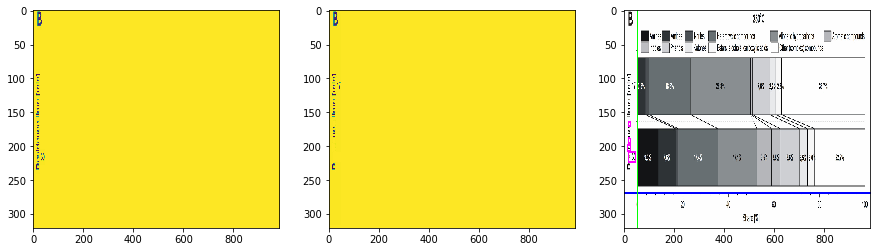

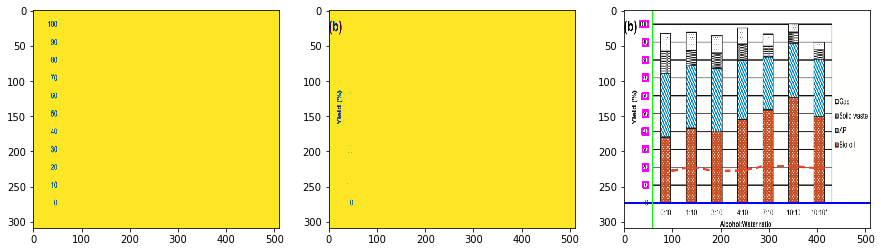

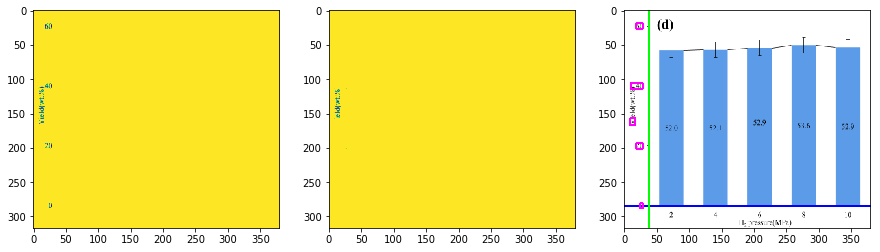

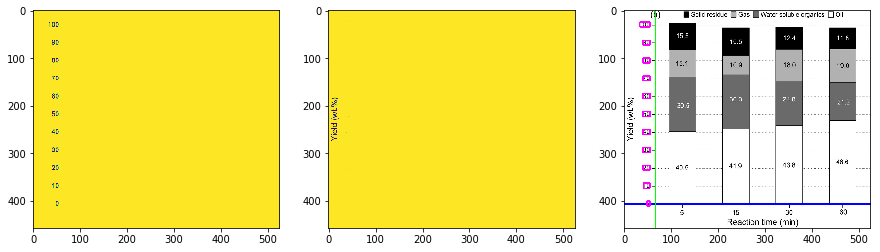

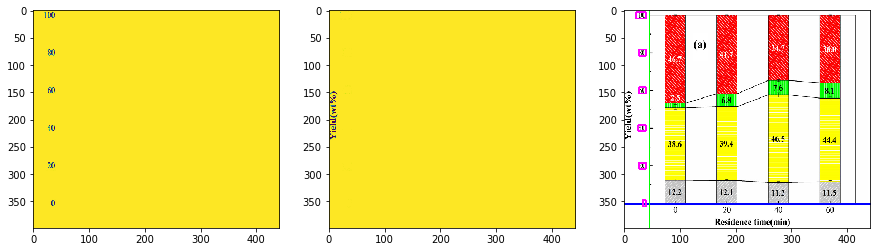

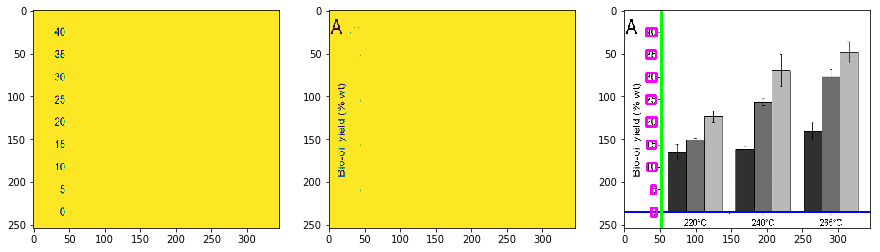

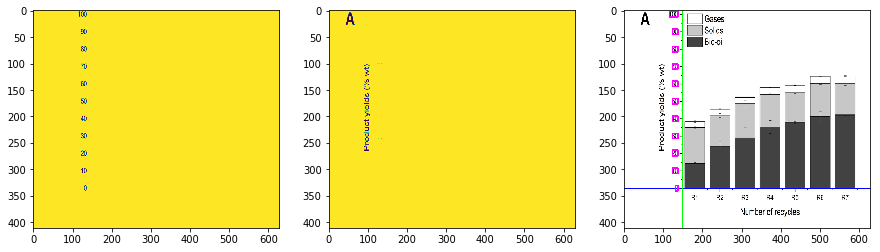

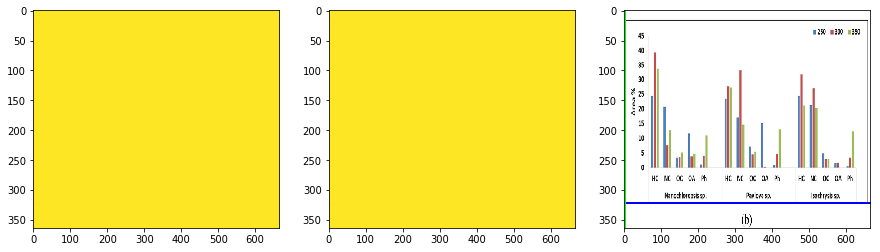

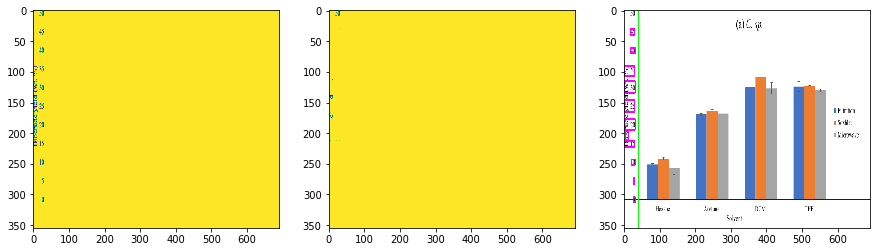

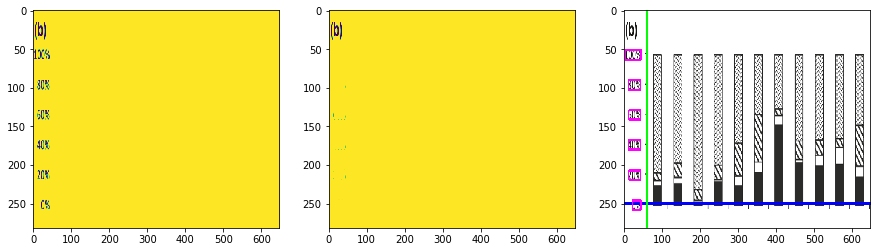

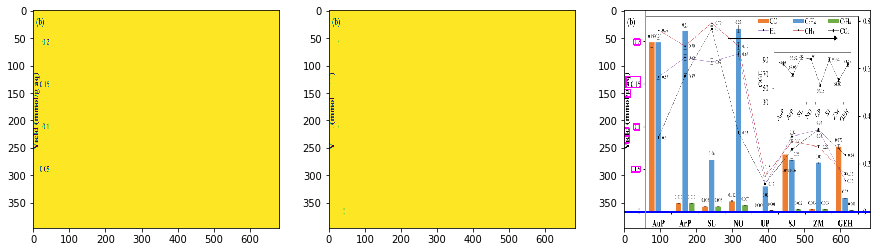

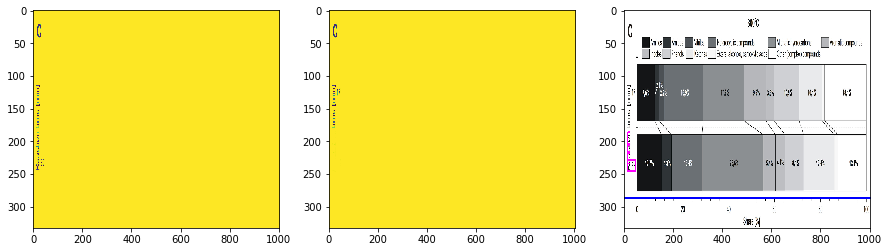

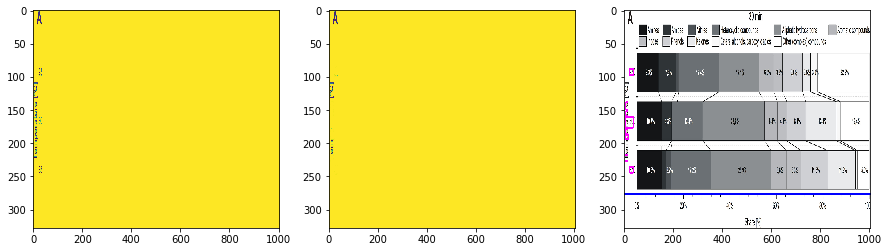

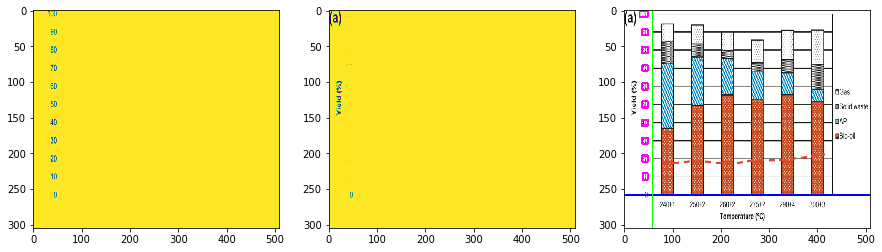

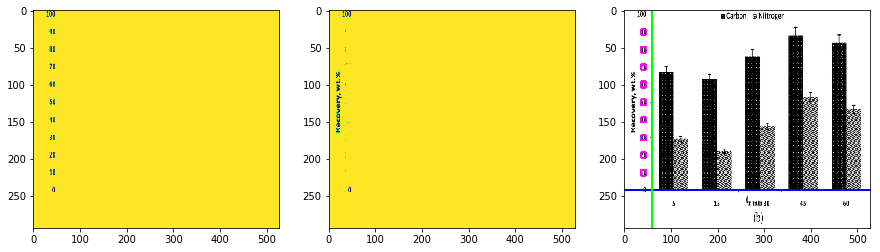

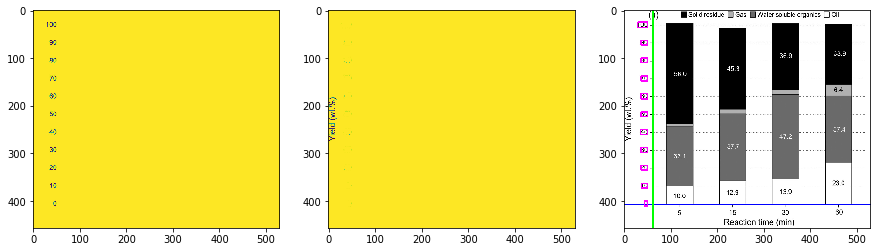

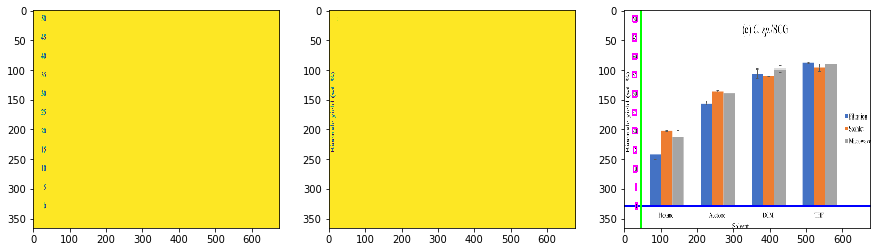

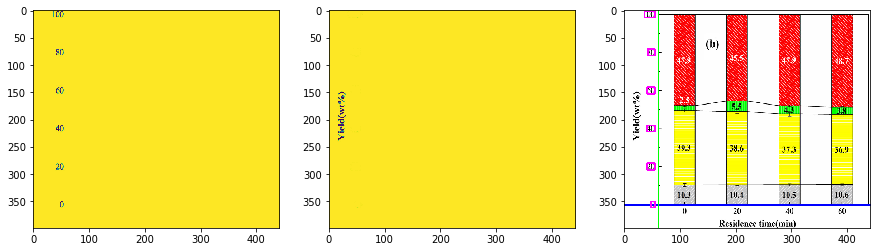

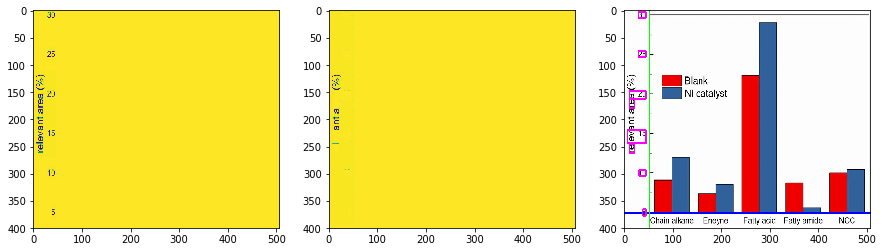

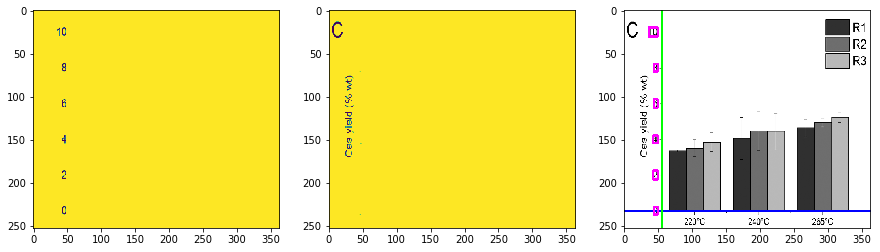

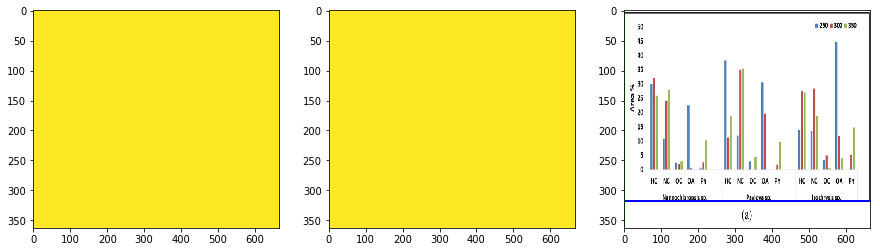

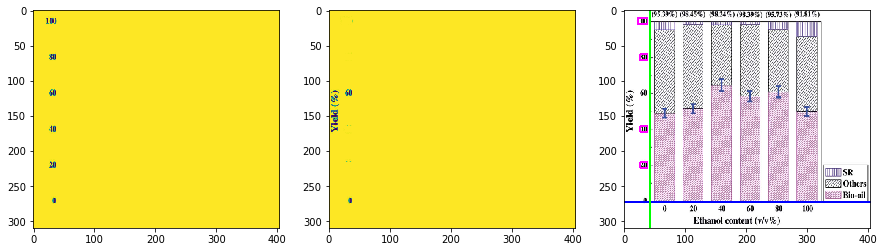

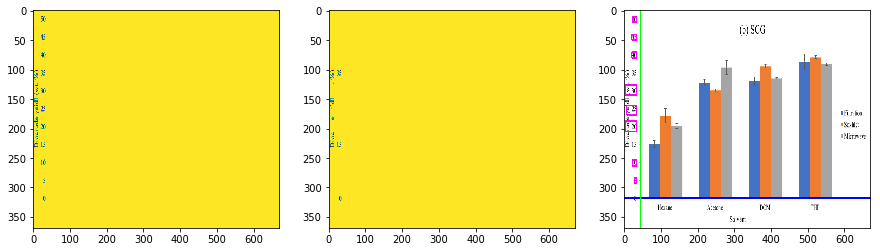

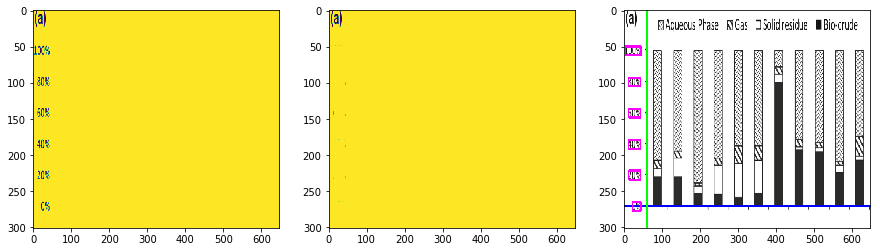

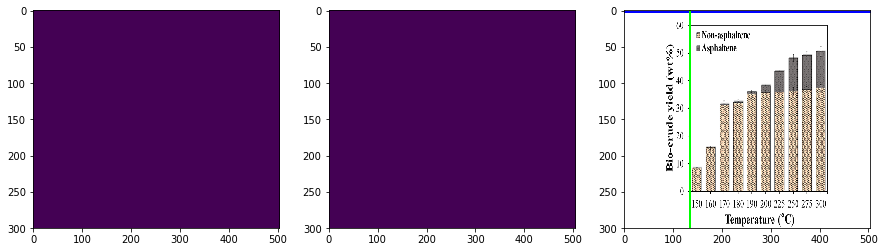

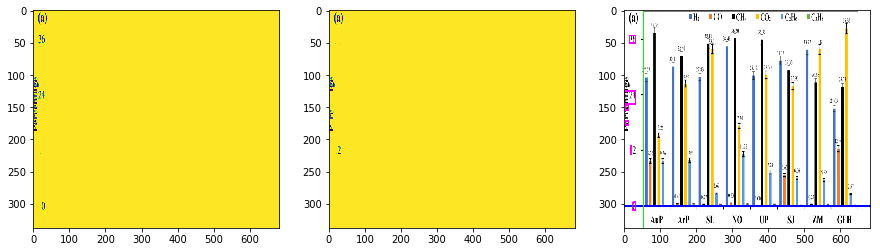

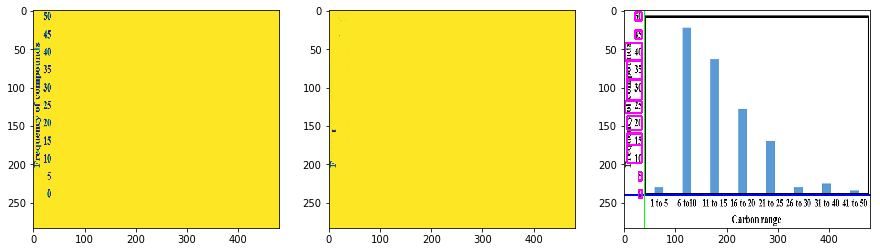

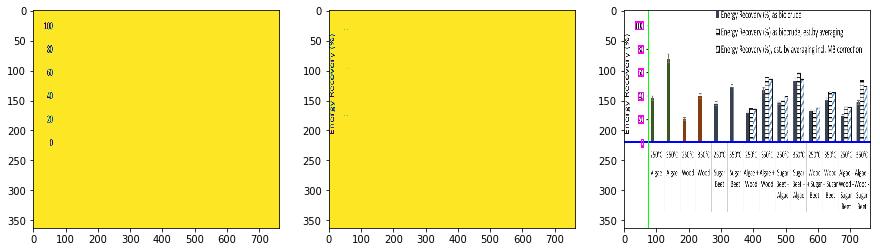

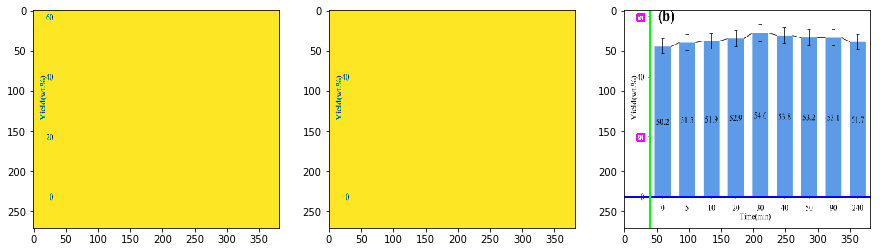

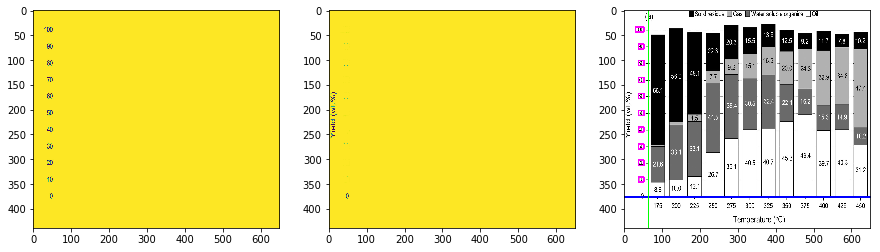

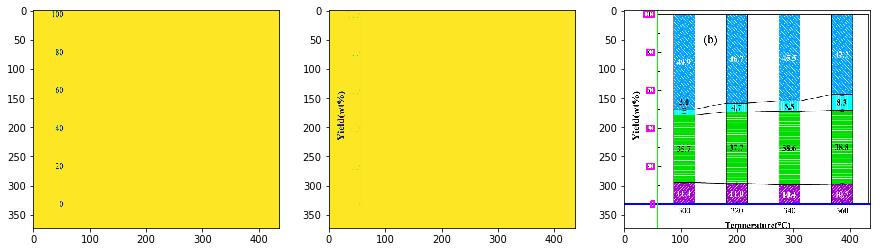

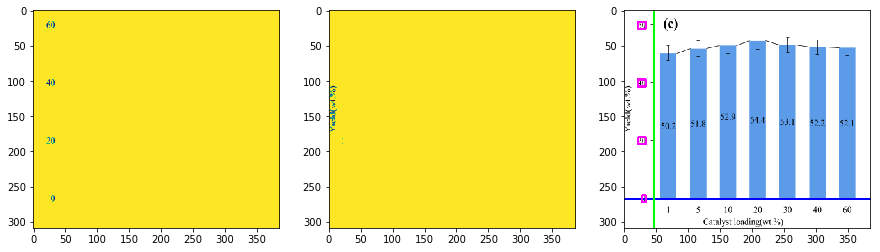

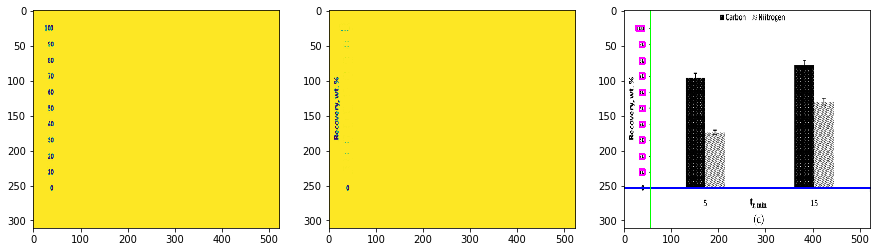

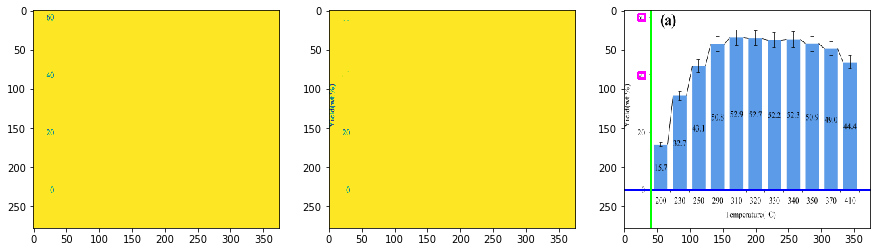

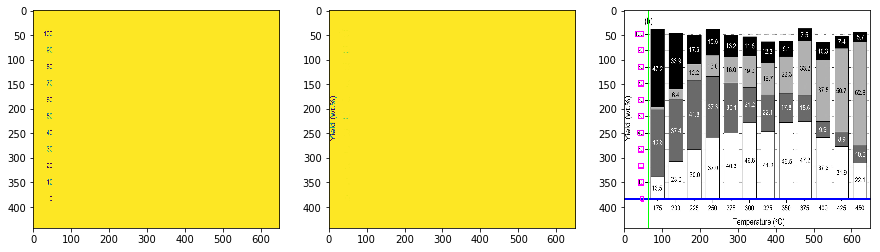

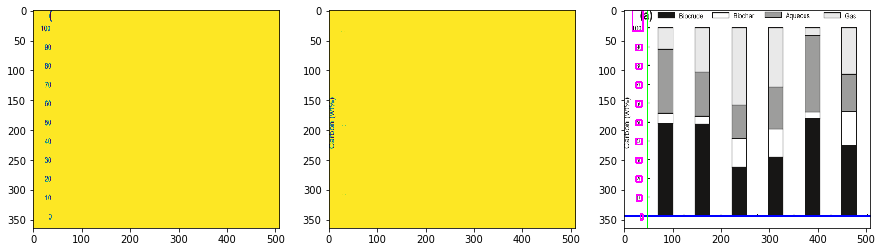

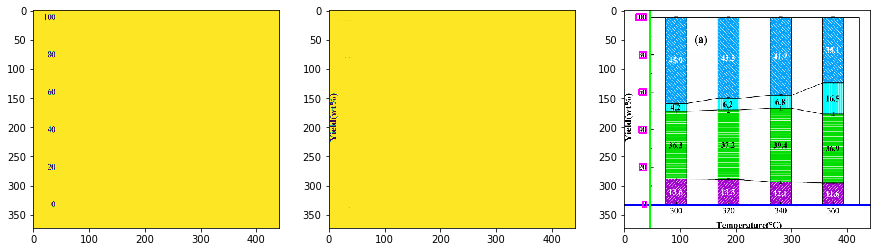

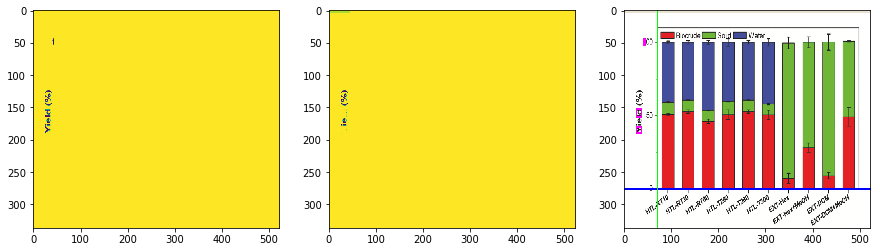

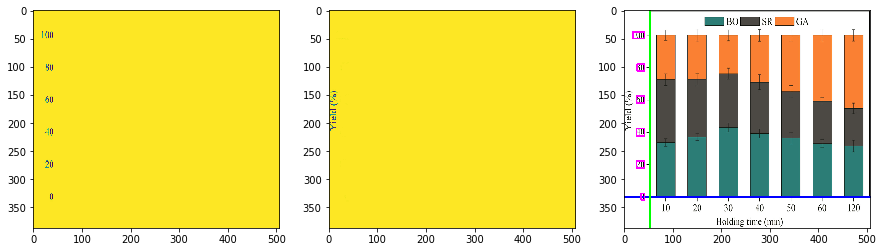

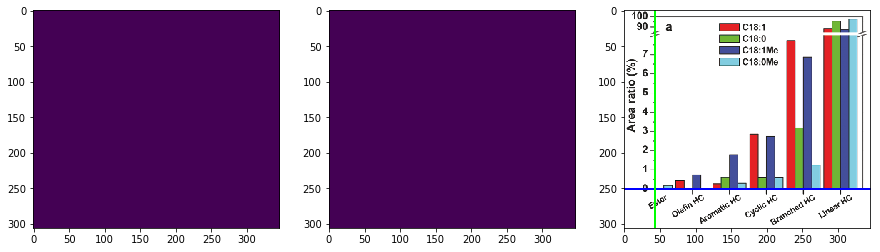

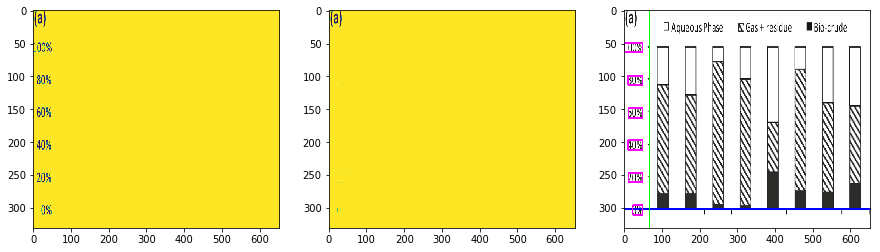

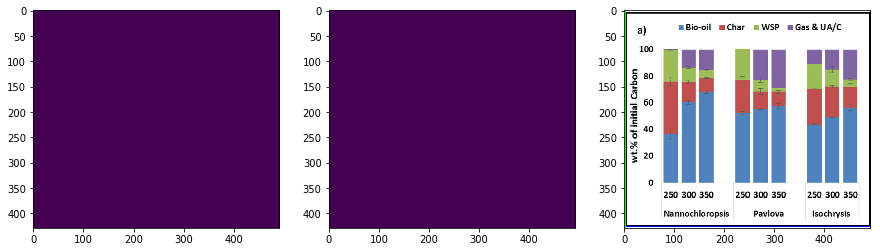

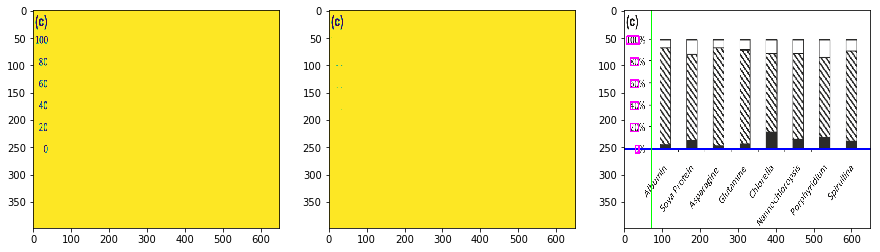

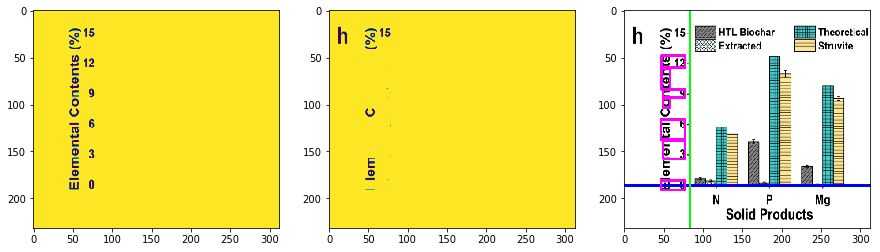

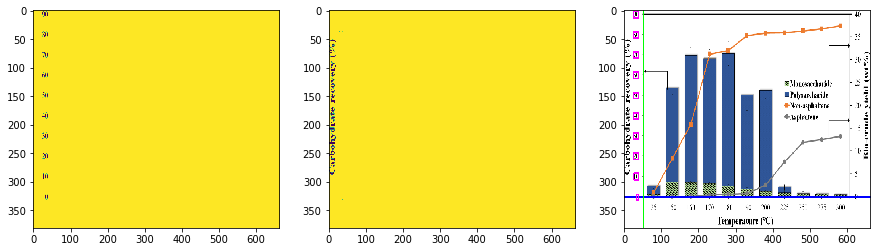

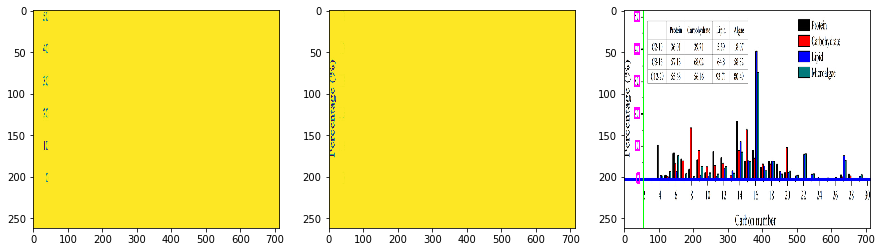

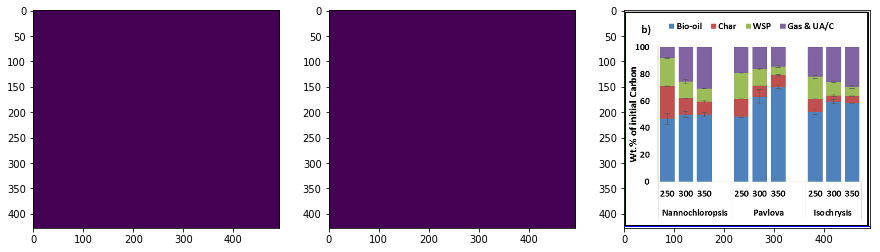

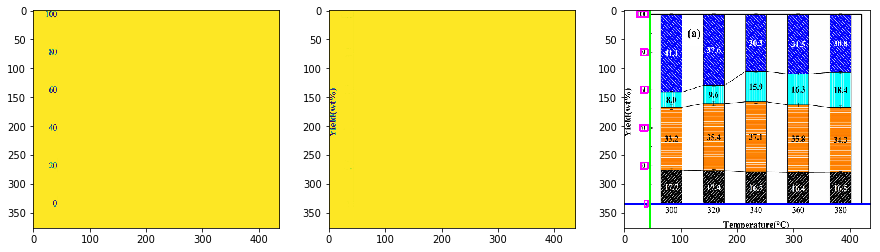

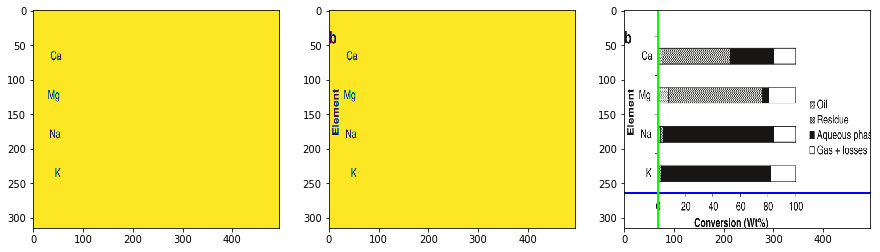

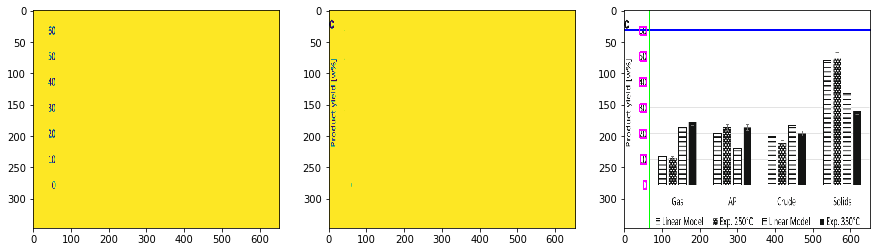

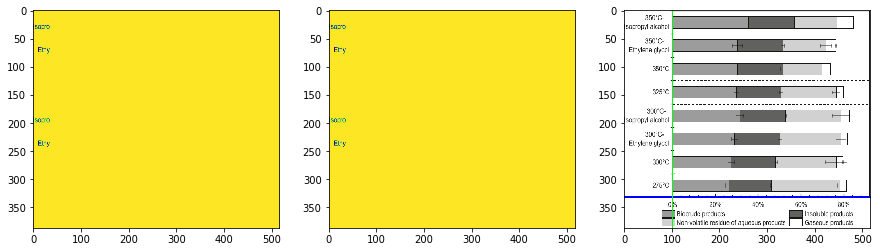

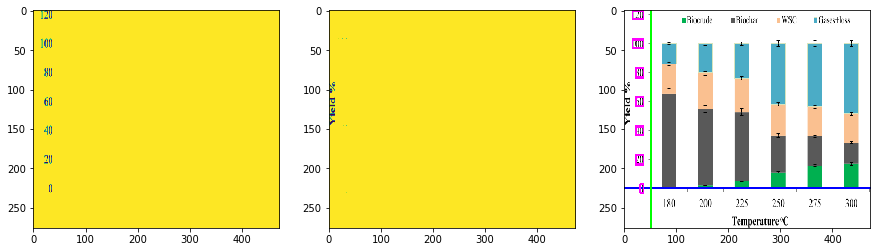

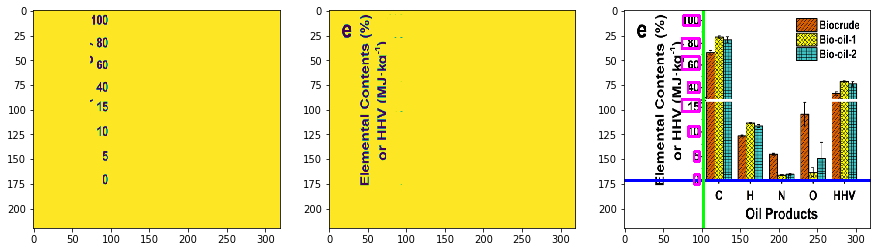

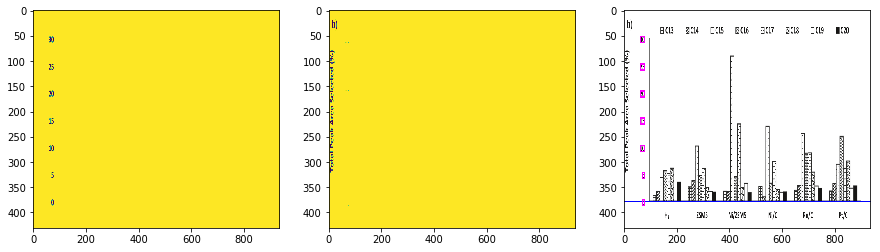

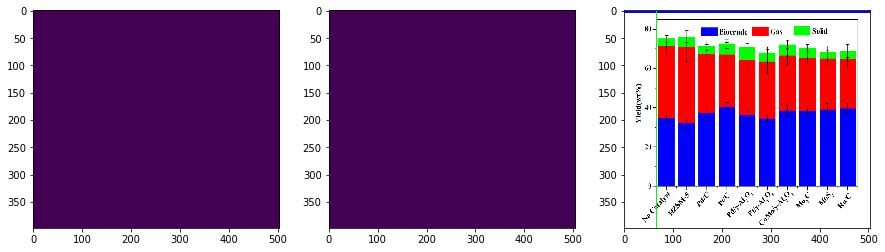

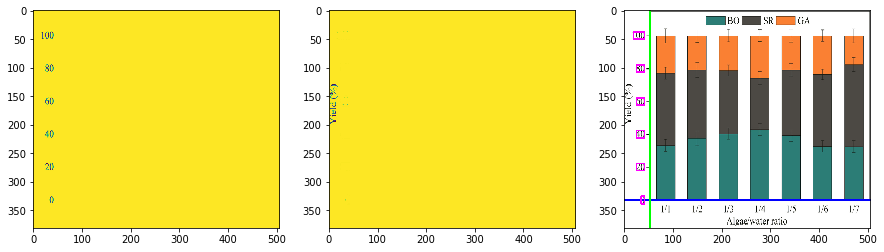

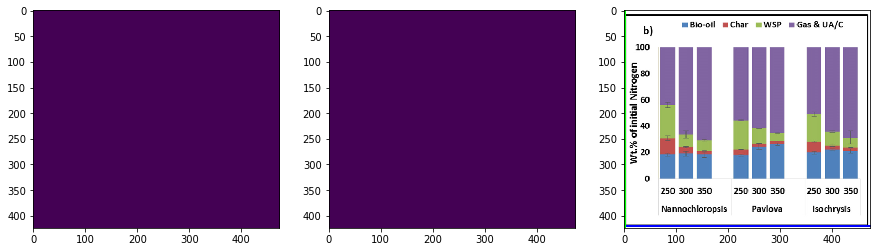

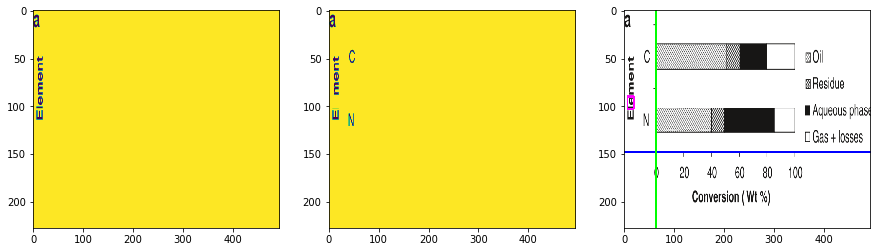

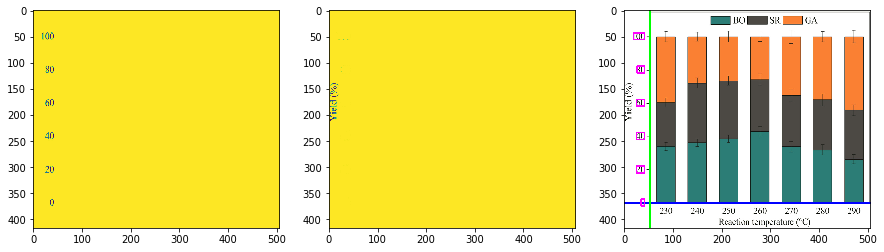

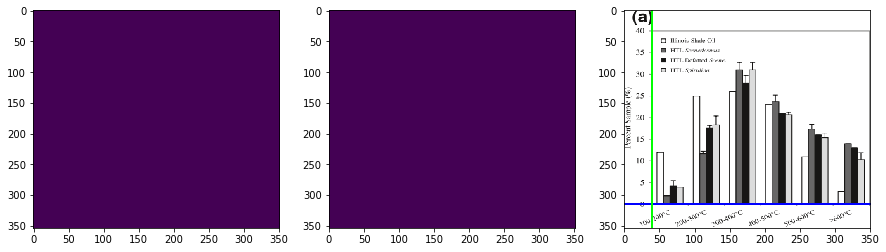

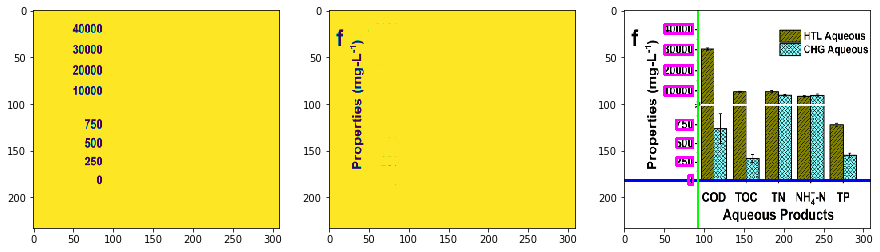

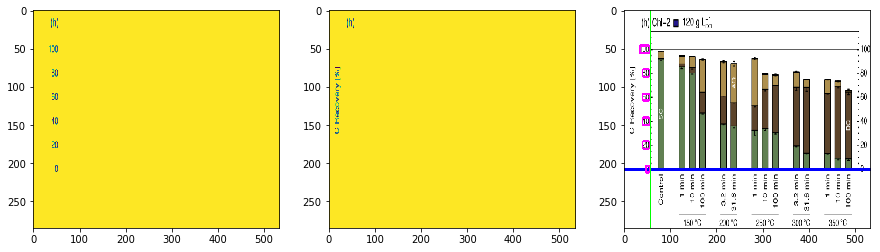

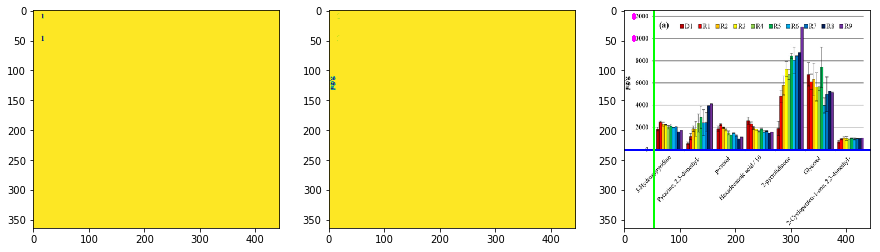

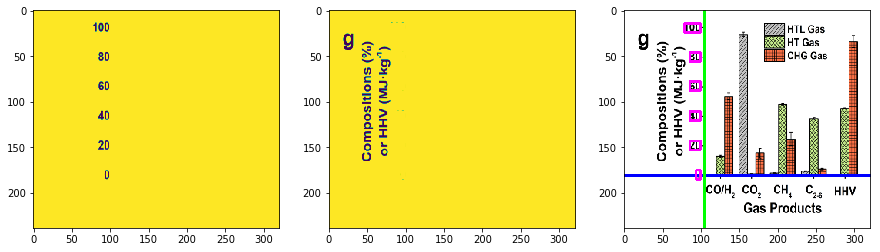

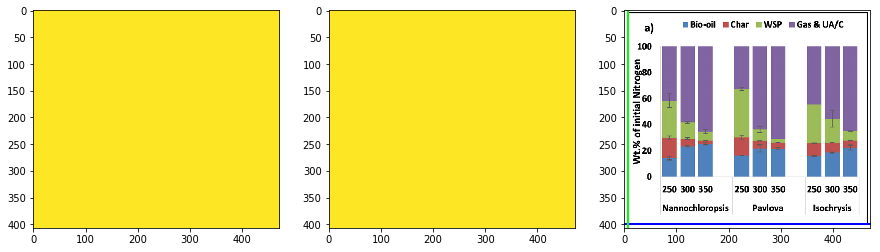

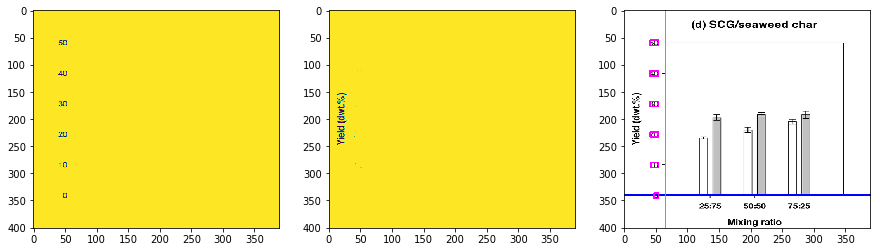

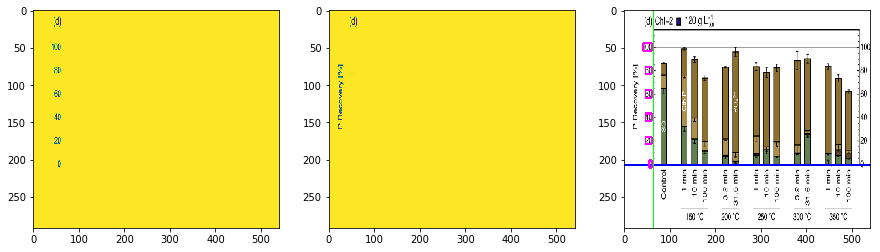

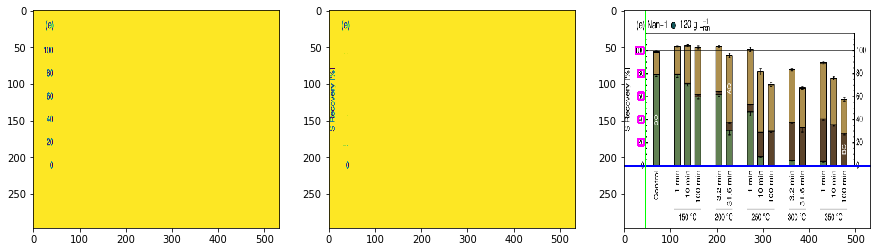

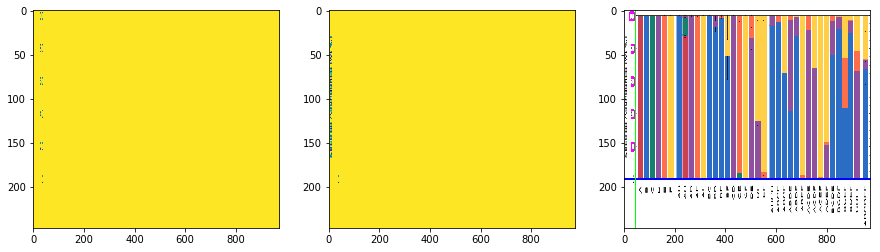

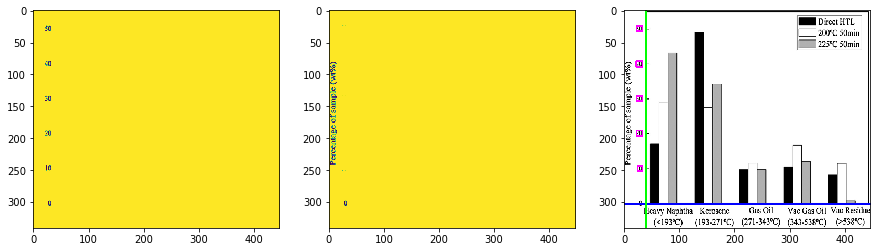

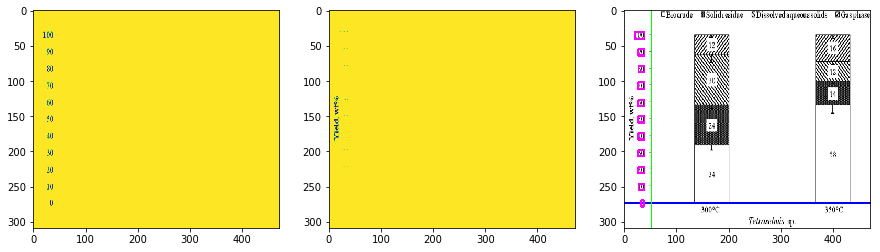

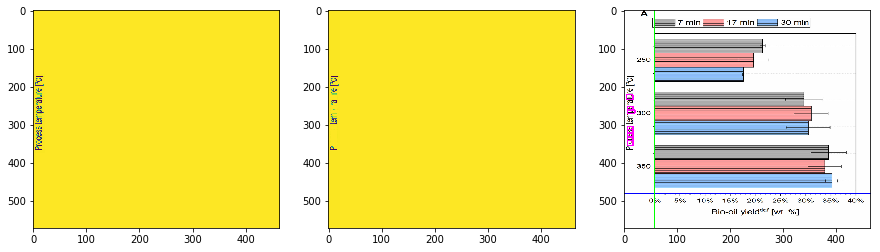

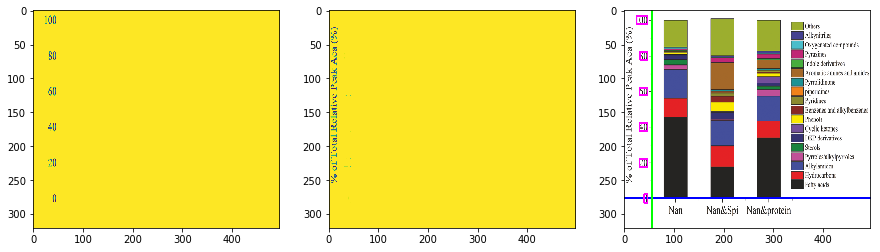

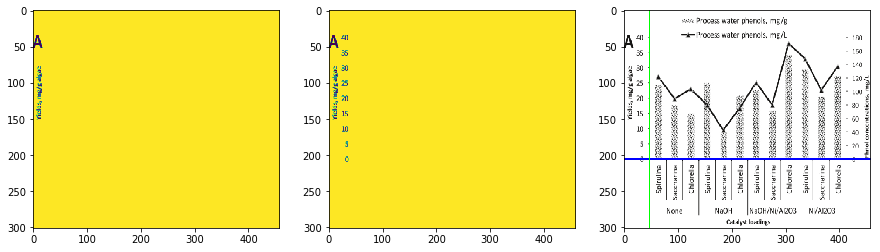

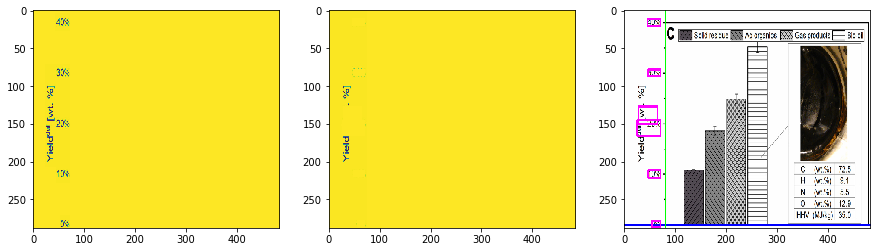

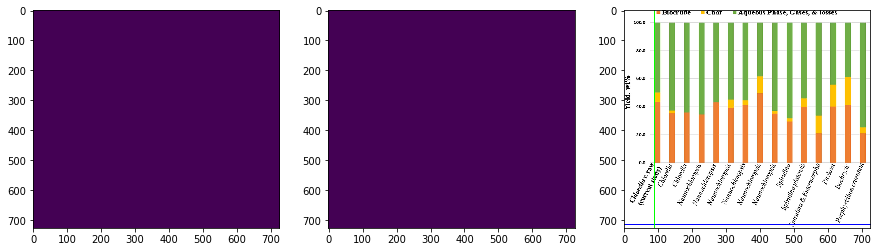

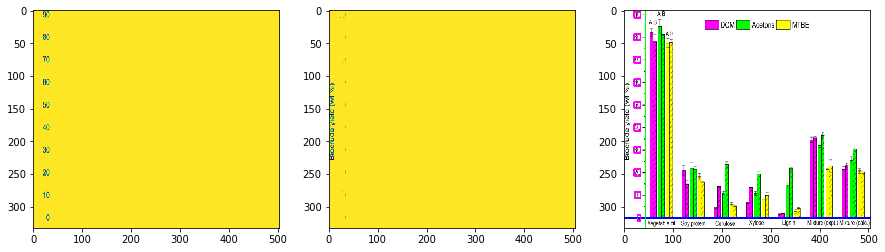

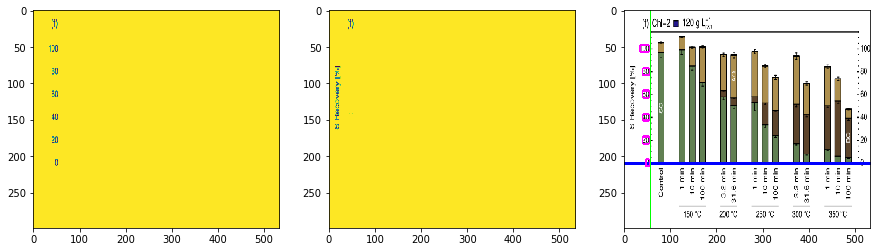

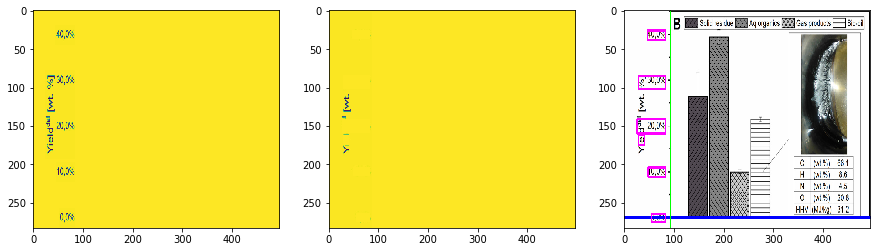

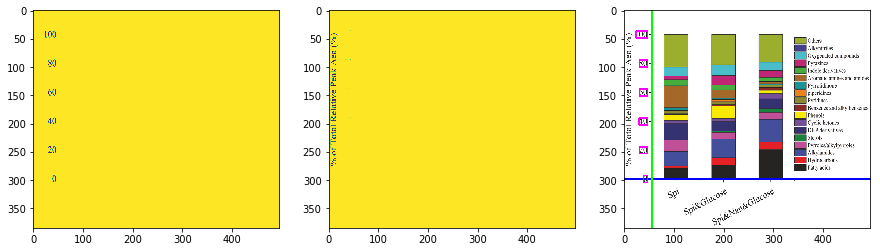

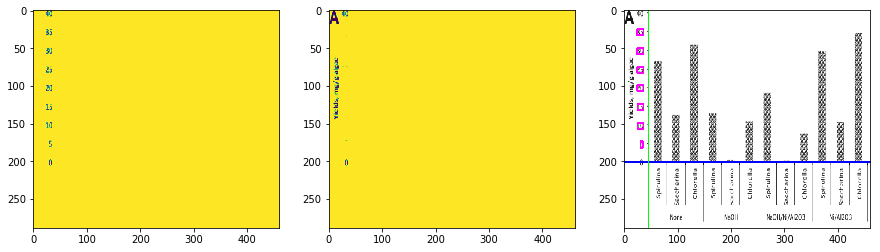

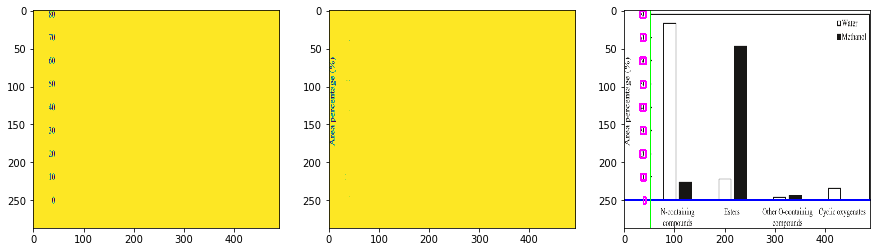

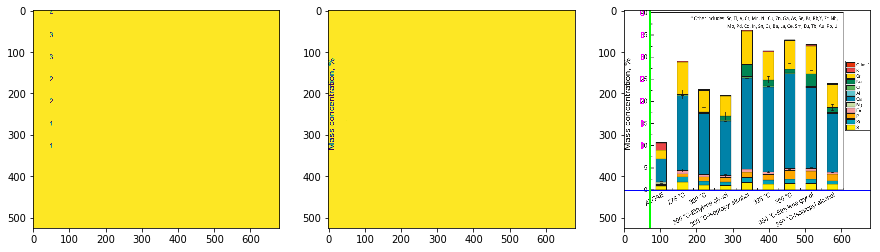

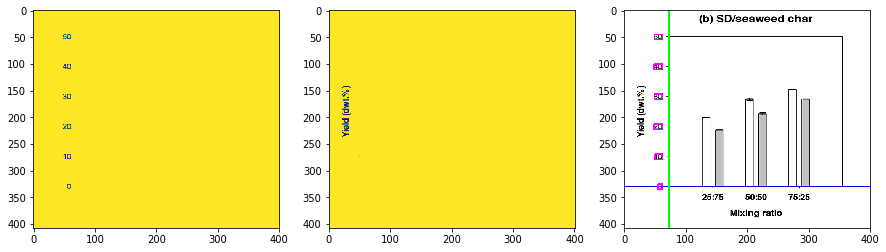

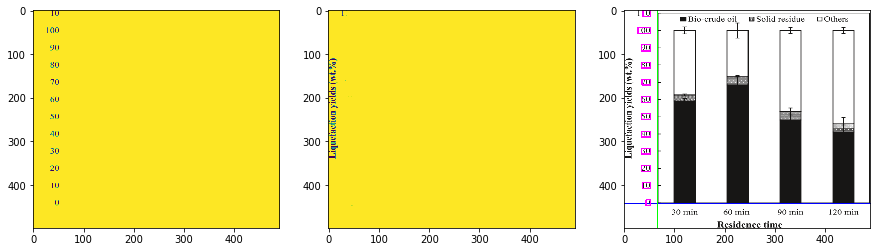

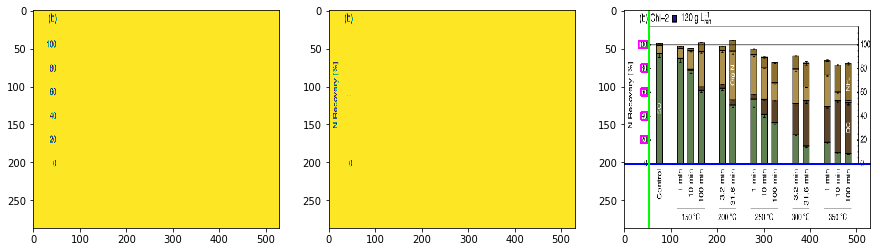

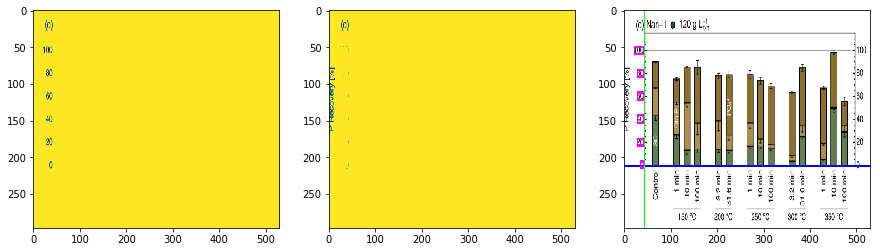

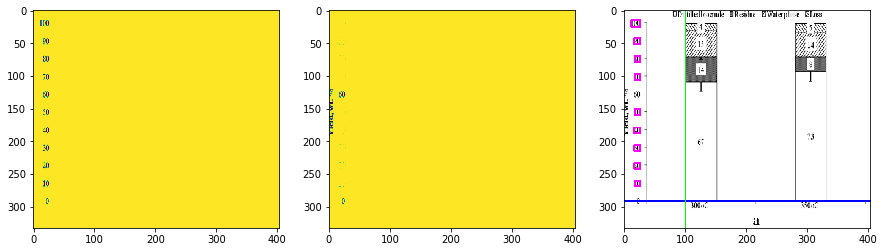

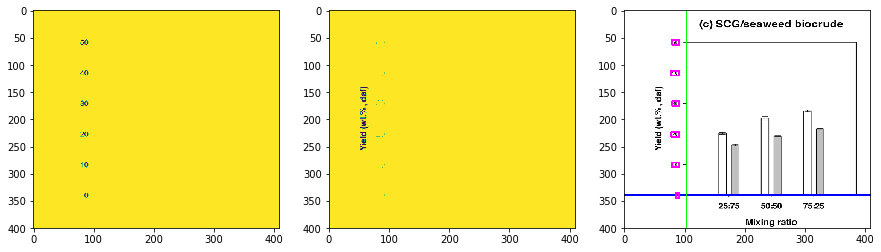

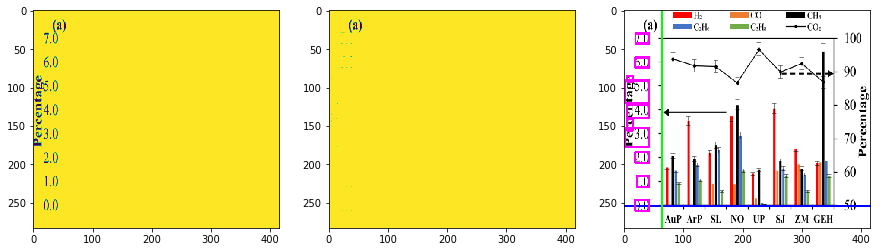

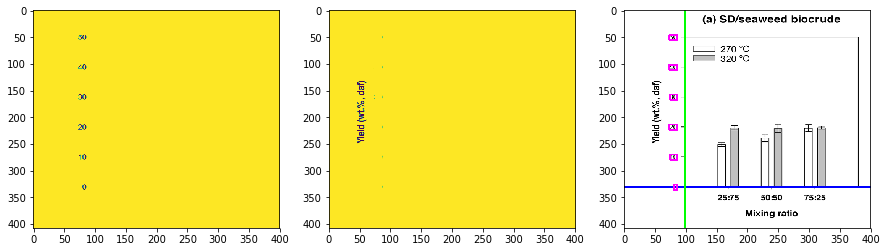

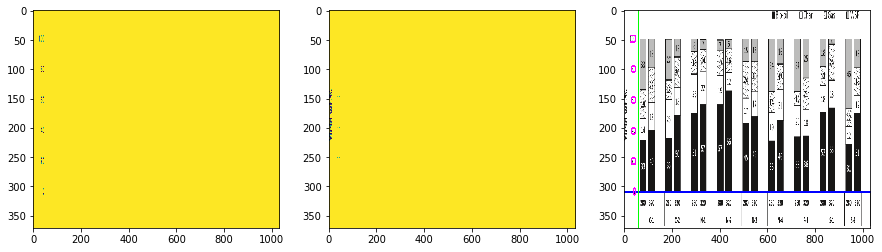

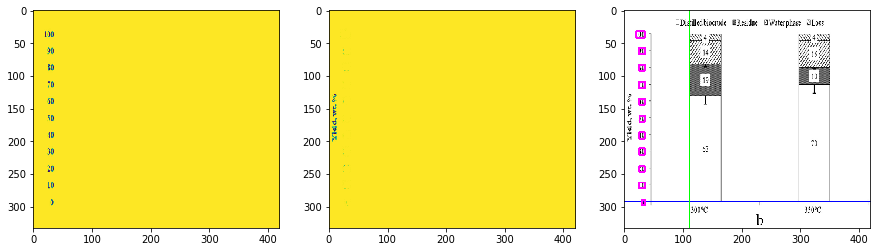

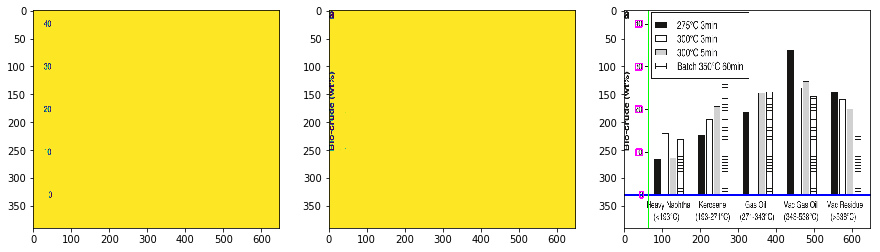

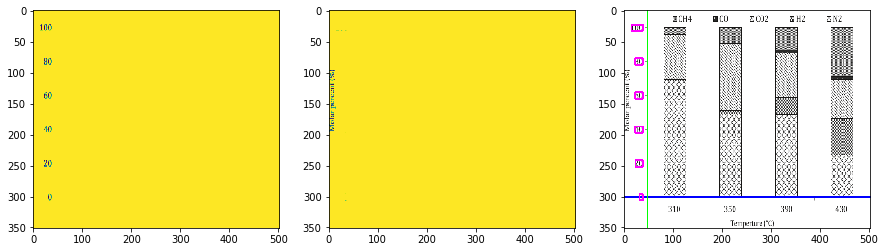

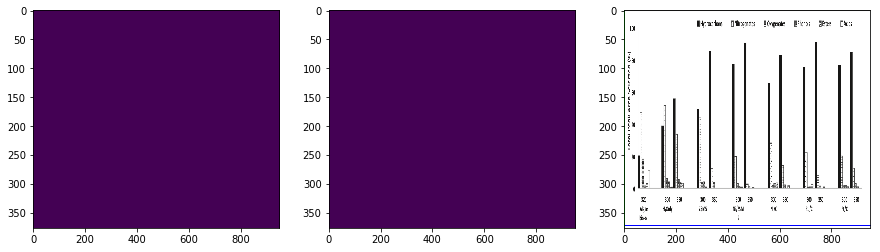

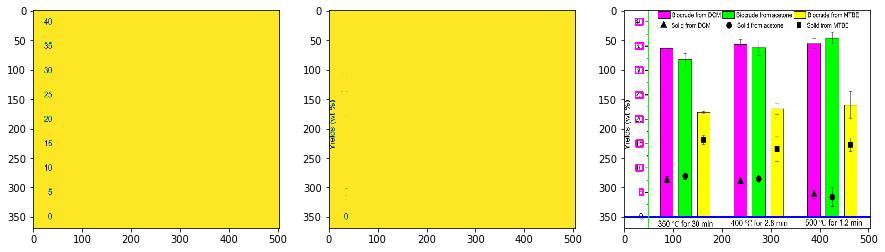

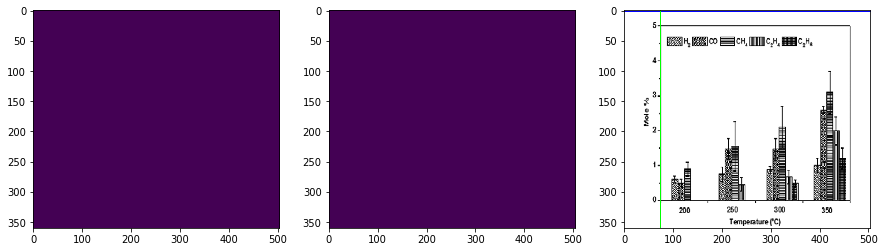

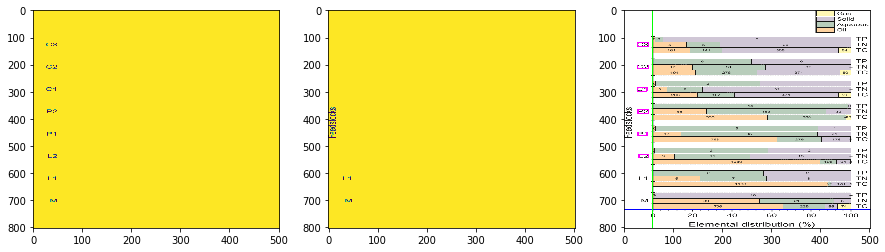

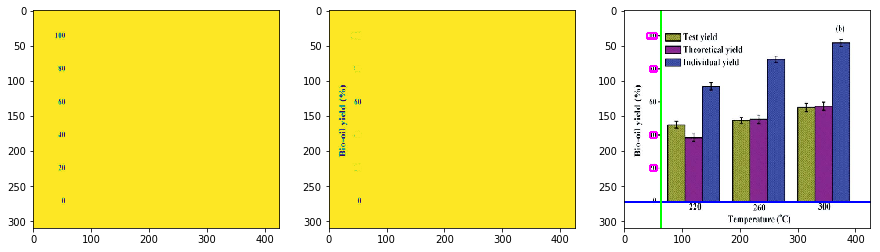

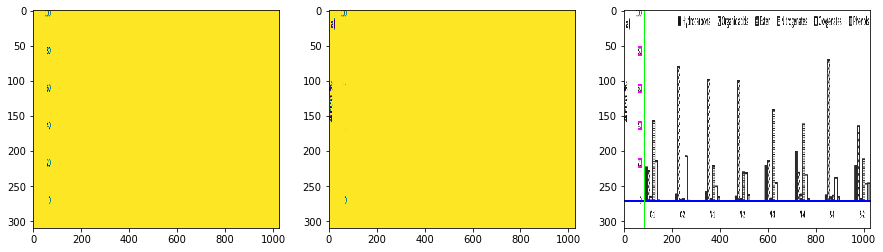

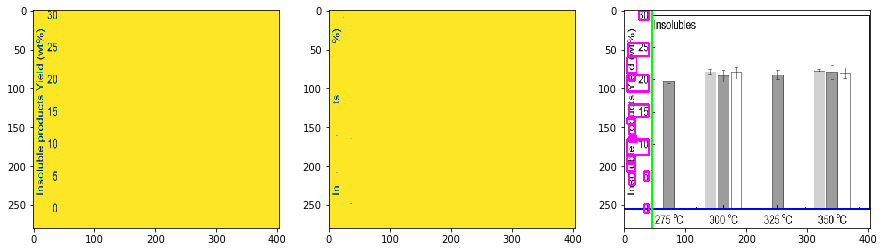

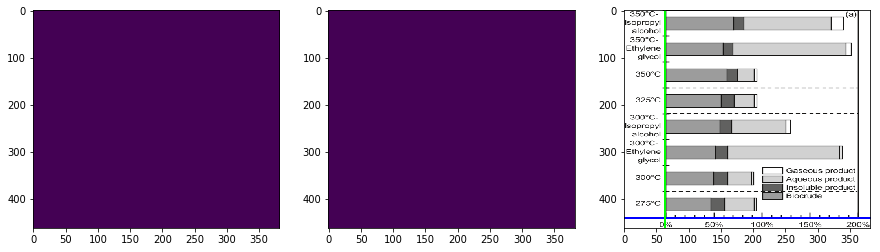

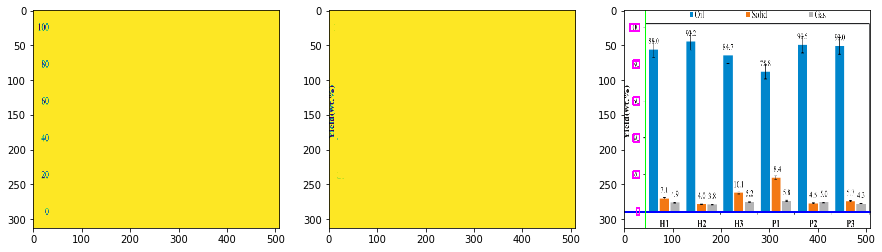

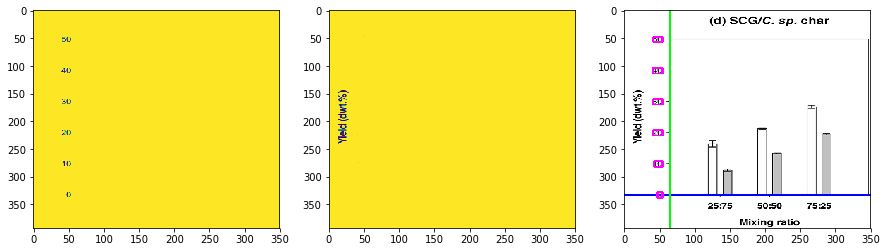

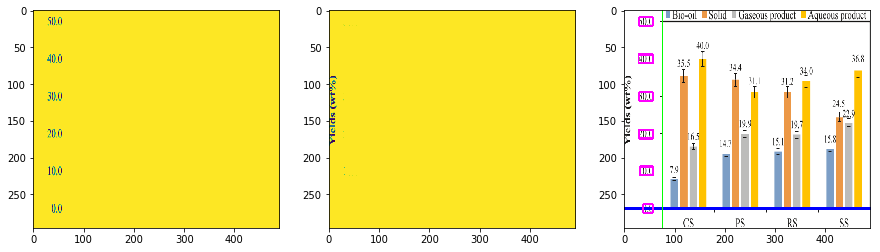

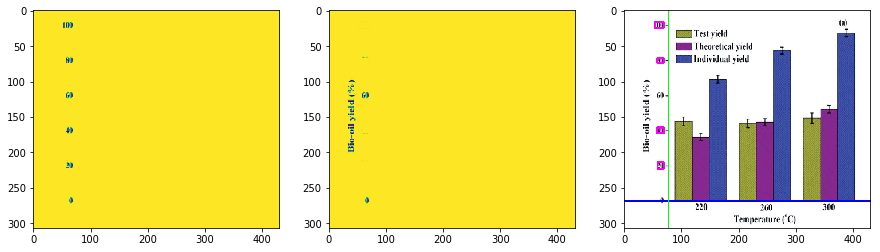

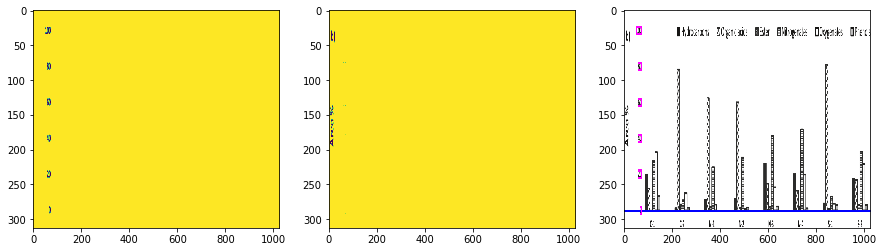

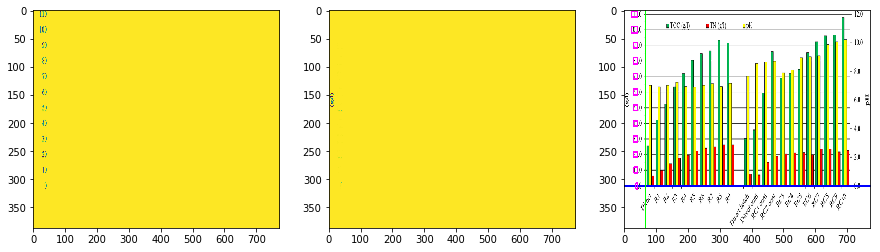

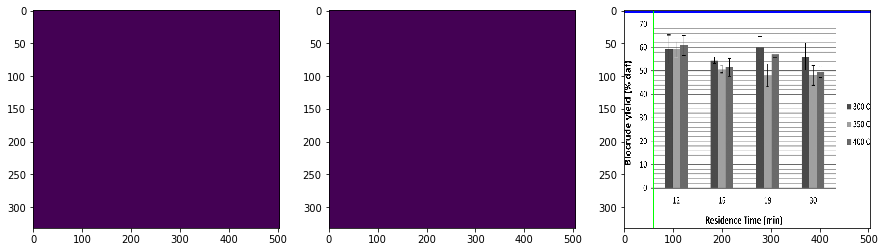

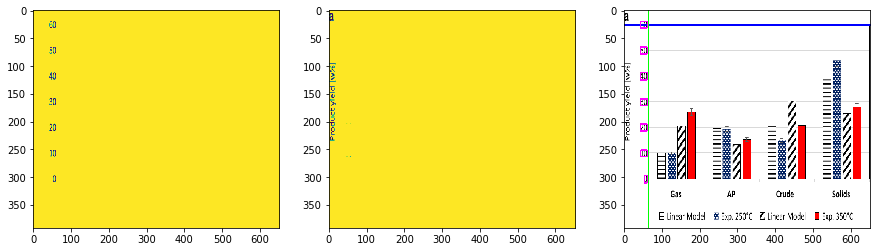

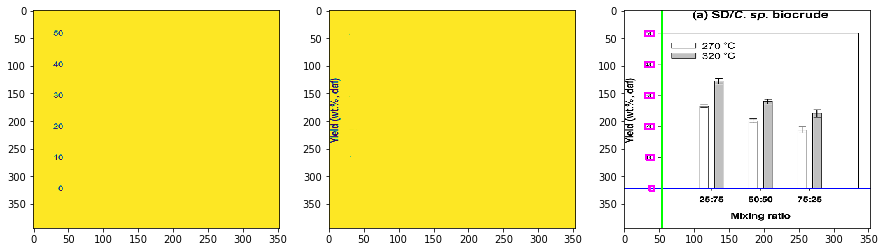

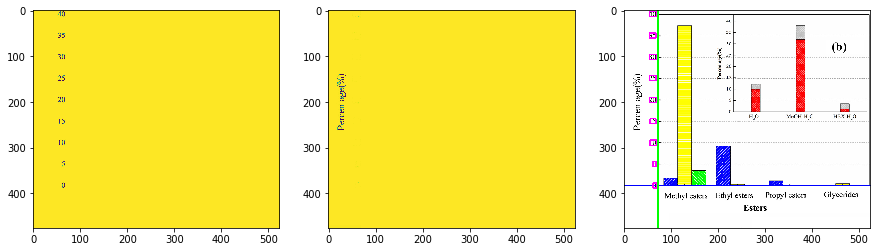

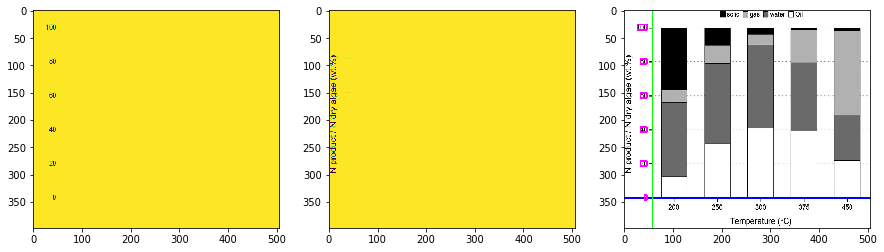

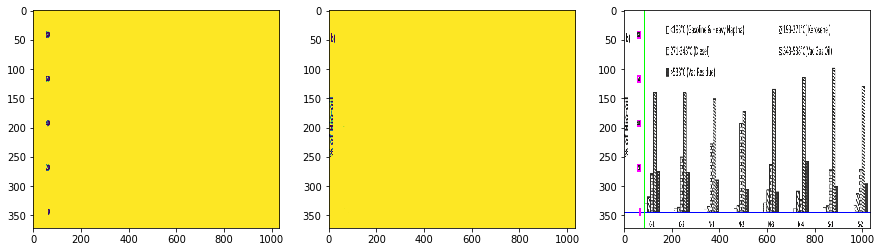

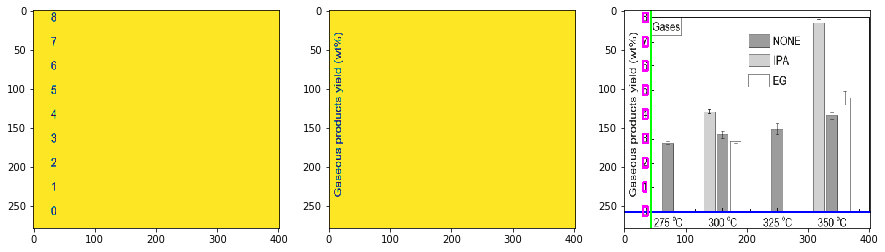

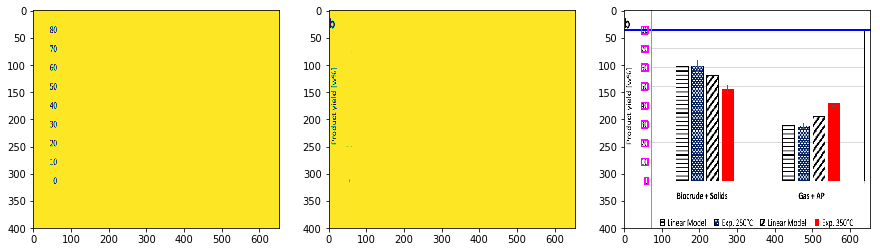

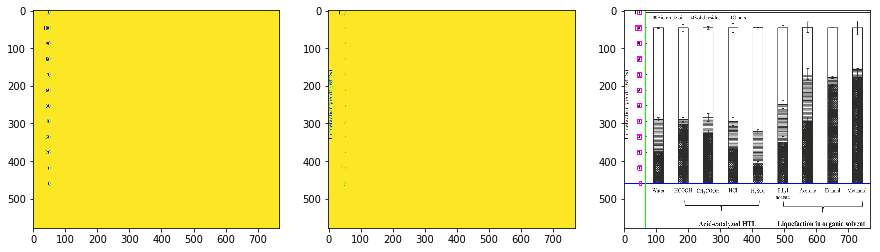

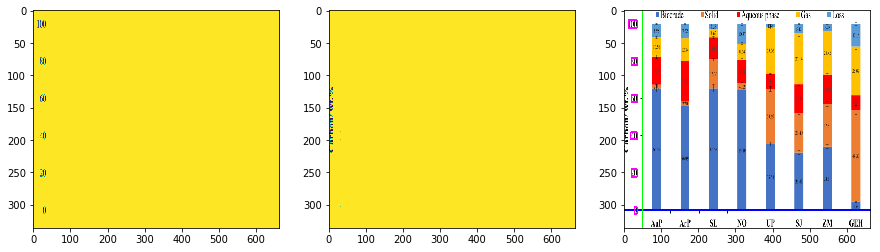

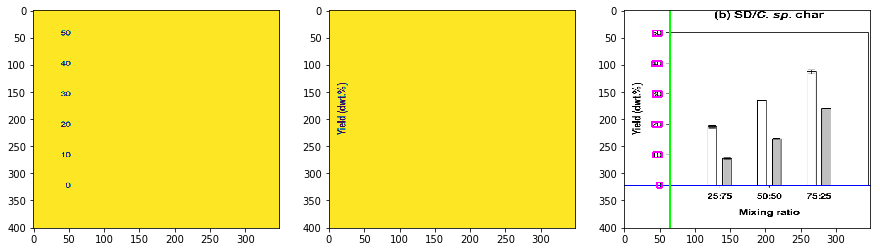

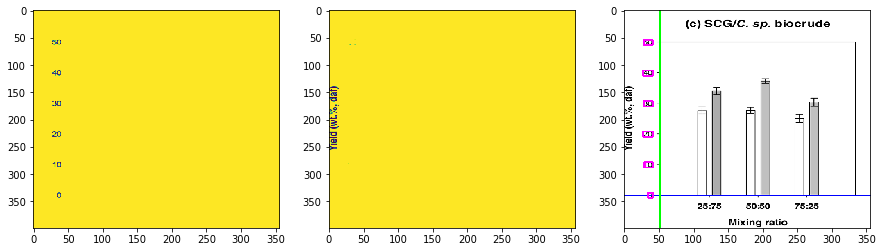

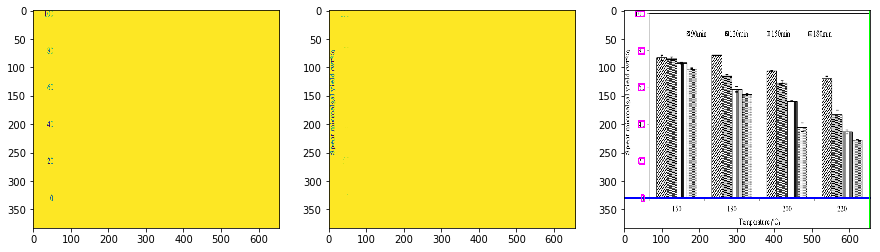

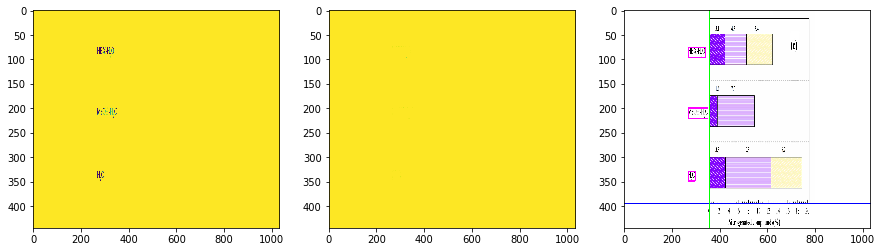

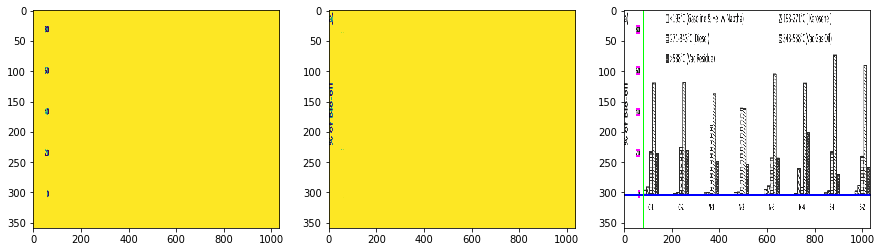

In [23]:
workbook = xlsxwriter.Workbook('FigureData1.xlsx')

for path in Path(img_dir).iterdir():
    if path.name.endswith('.png') or path.name.endswith('.jpg') or path.name.endswith('.jpeg'):
        if path.name in yValueDict:

            filepath = img_dir + "/" + path.name
            
            
            image = cv2.imread(filepath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            height, width, channels = image.shape
            xaxis, yaxis = detectAxes(filepath)
            y_text, y_labels = [], []

            for (x1, y1, x2, y2) in [xaxis]:
                xaxis = (x1, y1, x2, y2)

            for (x1, y1, x2, y2) in [yaxis]:
                yaxis = (x1, y1, x2, y2)
                
            rcParams['figure.figsize'] = 15, 4
            fig, ax = plt.subplots(1, 3)

            # Make a backward pass to skip the ticks
            gray = maskImageBackwardPass(filepath, yaxis[0])

            # Processing the image so that the contours are drawn to labels and text
            ret, thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
            rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
            thresh = cv2.dilate(thresh, rect_kernel, iterations = 1)
            rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
            thresh = cv2.dilate(thresh, rect_kernel, iterations = 1)

            contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours = contours[0] if len(contours) == 2 else contours[1]
            rects = [cv2.boundingRect(contour) for contour in contours]
            print("number of contours: ", len(contours))

            image_text = getTextFromImage(filepath, bw=True)
            image, y_labels = getProbableYLabels(image, rects, xaxis, yaxis)
            white_bg = 255 * np.ones_like(gray.copy())

            for (textx, texty, w, h) in y_labels:
                roi = gray[texty:texty + h, textx:textx + w]
                white_bg[texty:texty + h, textx:textx + w] = roi

            # Get y-labels
            y_labels_list = getTextFromImageArray(white_bg, 'y-labels')
            ax[0].imshow(white_bg, aspect = 'auto')

            # Sort bounding rects by y coordinate
            def getYFromRect(item):
                return item[1][1]

            # Whiten y-labels and get y-text
            y_labels_list.sort(key = getYFromRect)
            y_labels = []
            for text, (textx, texty, w, h) in y_labels_list:
                roi = 255 * np.ones_like(gray[texty:texty + h, textx:textx + w])
                gray[texty:texty + h, textx:textx + w] = roi
                y_labels.append(text)

            y_text_list = getTextFromImageArray(gray, 'y-text')

            # Sort bounding rects by x coordinate
            def getXFromRect(item):
                return item[1][0]

            y_text_list.sort(key = getXFromRect)        
            for text, (textx, texty, w, h) in y_text_list:
                y_text.append(text)

            # Get the remaining: x-labels and legends
            image_text = getTextFromImage(filepath, bw=True)
            image, x_labels, _, legends = getProbableLabels(image, image_text, xaxis, yaxis)
            
            # Append doi values for each image.
            if path.name[:-16]+'.pdf' in doidata['Dois']:
                doi = doidata['Dois'][path.name[:-16]+'.pdf']
            else:
                doi = ''
             
            
            

            # Write to Excel
            worksheet = workbook.add_worksheet()            
            
            #addToExcel("caption", [urldata[path.name]], 0)
            addToExcel("doi",doi, 0)
            addToExcel("file name", [path.name[::-4] + ".pdf"], 1)
            addToExcel("x-labels", x_labels, 2)
            addToExcel("y-text", y_text, 3)
            addToExcel("y-labels", y_labels, 4)
            addToExcel("legends", legends, 5)
            
            for col_num, data in enumerate(yValueDict[path.name]):
                print(col_num, data)
                if type(data) != list:
                    worksheet.write(9 + col_num, 0, "Y-values:" + "\n\n" + str(data))
                else:
                    for pos,d in enumerate(data):
                        worksheet.write(9 + col_num, pos, str(d))

            # Print the output here!
            print("file name    :  ", path.name)
            print("doi          :  ", doi)
            print("x-labels     :  ", x_labels)
            print("y-text       :  ", y_text)
            print("y-labels     :  ", y_labels)
            print("legends      :  ", legends)
            print("Y- Values    :  ", ' '.join([str(elem) for elem in yValueDict[path.name]]), end = "\n\n")

            for (x1, y1, x2, y2) in [xaxis]:
                cv2.line(image, (x1, y1), (x2, y2),  (0, 0, 255), 2)

            for (x1, y1, x2, y2) in [yaxis]:
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            for text, (textx, texty, w, h) in y_labels_list:
                cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)

            ax[1].imshow(gray, aspect = 'auto')
            ax[2].imshow(image, aspect = 'auto')

            # Insert the image
            worksheet.insert_image('J21', filepath)

# Close the excel workbook!
workbook.close()